# Chapter 3

## Daylight Data

In [1]:
#pip install ephem

In [2]:
import pandas as pd
import datetime
import ephem
import numpy as np

# Define the latitude and longitude ranges
latitudes = np.arange(49.0, 60.1, 0.25)  # Latitude range from 49 to 60 degrees
longitudes = np.arange(-8.0, 2.1, 0.25)  # Longitude range from -8 to 2 degrees

# Define the date range
start_date = datetime.date(2023, 8, 1)
end_date = datetime.date(2024, 4, 30)

# Create an empty list to store the results
sun_data_list = []

# Loop through each location and each date
for lat in latitudes:
    for lon in longitudes:
        current_date = start_date
        observer = ephem.Observer()
        observer.lat = str(lat)
        observer.lon = str(lon)
        
        while current_date <= end_date:
            observer.date = current_date
            try:
                # Calculate sunrise and sunset times
                sunrise = observer.next_rising(ephem.Sun()).datetime()
                sunset = observer.next_setting(ephem.Sun()).datetime()
                
                # Append the data to the list
                sun_data_list.append({
                    "Date": current_date,
                    "Latitude": lat,
                    "Longitude": lon,
                    "Sunrise": sunrise.time().strftime("%H:%M:%S"),
                    "Sunset": sunset.time().strftime("%H:%M:%S")
                })
            except (ephem.AlwaysUpError, ephem.NeverUpError):
                # Handle polar day/night situations where the sun never rises or sets
                sun_data_list.append({
                    "Date": current_date,
                    "Latitude": lat,
                    "Longitude": lon,
                    "Sunrise": "N/A",
                    "Sunset": "N/A"
                })
            
            # Move to the next day
            current_date += datetime.timedelta(days=1)

# Convert the list of dictionaries to a DataFrame
sun_data = pd.DataFrame(sun_data_list)

# Convert 'Sunrise' and 'Sunset' columns to datetime.time format
sun_data['Sunrise'] = pd.to_datetime(sun_data['Sunrise'], format='%H:%M:%S').dt.time
sun_data['Sunset'] = pd.to_datetime(sun_data['Sunset'], format='%H:%M:%S').dt.time

# Calculate the total minutes of daylight
sun_data['Daylight Minutes'] = (
    pd.to_datetime(sun_data['Sunset'].astype(str), format='%H:%M:%S') - 
    pd.to_datetime(sun_data['Sunrise'].astype(str), format='%H:%M:%S')
).dt.total_seconds() / 60

# Save the data to a CSV file
sun_data.to_csv("daylight_data.csv", index=False)

print("Data generation complete. CSV file created as 'daylight_data.csv'.")
print(sun_data.shape)
sun_data.head()

Data generation complete. CSV file created as 'daylight_data.csv'.
(505530, 6)


Date  Latitude  Longitude   Sunrise    Sunset  Daylight Minutes
0  2023-08-01      49.0       -8.0  05:04:03  20:11:48        907.750000
1  2023-08-02      49.0       -8.0  05:05:24  20:10:19        904.916667
2  2023-08-03      49.0       -8.0  05:06:45  20:08:48        902.050000
3  2023-08-04      49.0       -8.0  05:08:07  20:07:15        899.133333
4  2023-08-05      49.0       -8.0  05:09:29  20:05:41        896.200000

In [16]:
import pandas as pd
import datetime

# Convert columns to appropriate types
sun_data['Date'] = pd.to_datetime(sun_data['Date'])
sun_data['Sunrise'] = pd.to_datetime(sun_data['Sunrise'], format='%H:%M:%S').dt.time
sun_data['Sunset'] = pd.to_datetime(sun_data['Sunset'], format='%H:%M:%S').dt.time

# Calculate the total minutes of daylight
sun_data['Daylight Minutes'] = (
    pd.to_datetime(sun_data['Sunset'].astype(str), format='%H:%M:%S') - 
    pd.to_datetime(sun_data['Sunrise'].astype(str), format='%H:%M:%S')
).dt.total_seconds() / 60

# Function to classify the month period based on custom logic
def classify_month_period(dt):
    if dt >= datetime.datetime(2023, 8, 1) and dt <= datetime.datetime(2023, 8, 31):
        return "August"
    elif dt >= datetime.datetime(2023, 9, 1) and dt <= datetime.datetime(2023, 9, 30):
        return "September"
    elif dt >= datetime.datetime(2023, 10, 1) and dt <= datetime.datetime(2023, 10, 22):
        return "October - Not Included"
    elif dt >= datetime.datetime(2023, 10, 23) and dt <= datetime.datetime(2023, 11, 19):
        return "October"
    elif dt >= datetime.datetime(2023, 11, 20) and dt <= datetime.datetime(2023, 12, 17):
        return "November"
    elif dt >= datetime.datetime(2023, 12, 18) and dt <= datetime.datetime(2023, 12, 31):
        return "December"
    elif dt >= datetime.datetime(2024, 1, 1) and dt <= datetime.datetime(2024, 1, 14):
        return "January"
    elif dt >= datetime.datetime(2024, 2, 12) and dt <= datetime.datetime(2024, 3, 10):
        return "February"
    elif dt >= datetime.datetime(2024, 3, 11) and dt <= datetime.datetime(2024, 4, 7):
        return "March"
    else:
        return "Others"

# Apply the classification function
sun_data['Month Period'] = sun_data['Date'].apply(classify_month_period)

# Filter the data to only include August to March periods
focus_periods = ["August", "September", "October", "November", "December", "January", "February", "March"]
sun_data = sun_data[sun_data['Month Period'].isin(focus_periods)]

# Add a column for Weekend or Weekday
sun_data['Day Type'] = sun_data['Date'].dt.weekday.apply(lambda x: 'Weekend - All' if x >= 5 else 'Weekday - All')

# Group by Latitude, Longitude, Month Period, and Day Type, then calculate the mean of daylight minutes
grouped = sun_data.groupby(['Latitude', 'Longitude', 'Month Period', 'Day Type'])['Daylight Minutes'].mean().reset_index()
grouped.rename(columns={
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'Month Period': 'Month',
    'Day Type': 'Time Aggregation',
    'Daylight Minutes': 'Daylight Minutes (Mean)'
}, inplace=True)


print(grouped.shape)
grouped.head()

(29520, 5)


latitude  longitude     Month Time Aggregation  Daylight Minutes (Mean)
0      49.0       -8.0    August    Weekday - All               860.981884
1      49.0       -8.0    August    Weekend - All               861.252083
2      49.0       -8.0  December    Weekday - All               495.236667
3      49.0       -8.0  December    Weekend - All               496.370833
4      49.0       -8.0  February    Weekday - All               644.105833

In [17]:
grouped['Time Aggregation'].unique()

array(['Weekday - All', 'Weekend - All'], dtype=object)

# Chapter 4

## 4.1 Mobility Data

In [83]:
import pandas as pd
import mercantile
import netCDF4 as nc
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

### 4.1.1 Reading Data

In [84]:
#Reading Files
Aug = pd.read_csv('Vodafone/20230801_20230831/footfall/part-00000-b05a82a5-75f5-49c5-977b-8fbc4a9423b3-c000.csv')
Sep = pd.read_csv('Vodafone/20230901_20230930/footfall/part-00000-e6b3a36a-0966-4fab-8f3f-3bb1f4ec4afa-c000.csv')
Oct23_Nov19 = pd.read_csv('Vodafone/20231023_20231119/footfall/part-00000-5044b085-2545-42f7-8577-27766d5e6fa3-c000.csv')
Nov20_Dec17 = pd.read_csv('Vodafone/20231120_20231217/footfall/part-00000-9aae211b-b88b-4d5d-9f06-74f601043e39-c000.csv')
Dec18_Jan14 = pd.read_csv('Vodafone/20231218_20240114/footfall/part-00000-35f63a2a-9114-46f2-ae96-6c189cd95752-c000.csv')
Jan15_Feb11 = pd.read_csv('Vodafone/20240115_20240211/footfall/part-00000-173f628c-f8f7-4ba2-ab95-aa0703b5fc11-c000.csv')
Feb12_Mar10 = pd.read_csv('Vodafone/20240212_20240310/footfall/part-00000-e93f30aa-3982-4f32-b354-8bc50abef547-c000.csv')
Mar11_Apr7 = pd.read_csv('Vodafone/20240311_20240407/footfall/part-00000-8039a013-7742-43eb-af6b-a1de2566232b-c000.csv')

# Create a dictionary with month names as keys and corresponding DataFrames as values
dataframes = {
    'August': Aug,
    'September': Sep,
    'October': Oct23_Nov19,
    'November': Nov20_Dec17,
    'December': Dec18_Jan14,
    'January': Jan15_Feb11,
    'February': Feb12_Mar10,
    'March': Mar11_Apr7,
}

# Loop through the dictionary and add a 'Month' column to each DataFrame
for month_abbr, df in dataframes.items():
    df['Month'] = month_abbr

# Save each DataFrame with its month name as a variable
August = dataframes['August']
September = dataframes['September']
October = dataframes['October']
November = dataframes['November']
December = dataframes['December']
January = dataframes['January']
February = dataframes['February']
March = dataframes['March']

#Merging all time periods as one dataframe
Mobility_Dataset = pd.concat(dataframes.values(), ignore_index=True)

Mobility_Dataset.head()

qk_id   time_aggregation  n_visitors   Month
0  3113113013203      weekend - all        1664  August
1  3113131000300  weekend - evening         152  August
2  3113213320202  weekday - evening       56956  August
3  3113301300300  weekend - workday        4137  August
4  3113303010023  weekend - evening        7162  August

### 4.1.2 Fixing Zoom Level 13 to 14 and 4.1.3 getting Latitudes and Longitudes

In [85]:
#Fixing Zoom Level 13
# Ensure the qk_id is treated as a string and correct the quadkeys that start with "3"
Mobility_Dataset['corrected_qk_id'] = Mobility_Dataset['qk_id'].astype(str).apply(lambda x: '0' + x if x.startswith('3') else x)

#Conversion to Coordinates:
# Function to calculate the centroid of a quadkey using mercantile
def quadkey_to_centroid(quadkey):
    tile = mercantile.quadkey_to_tile(quadkey)
    bounds = mercantile.bounds(tile)
    # Calculate the centroid of the tile
    latitude = (bounds.south + bounds.north) / 2
    longitude = (bounds.west + bounds.east) / 2
    return latitude, longitude

# Recalculate centroids for the corrected quadkeys
centroids = Mobility_Dataset['corrected_qk_id'].apply(quadkey_to_centroid)
centroids_df = pd.DataFrame(centroids.tolist(), columns=['latitude', 'longitude'])

# Round the latitude and longitude to 2 decimal places
centroids_df['latitude'] = centroids_df['latitude'].round(2)
centroids_df['longitude'] = centroids_df['longitude'].round(2)

# Add the latitude and longitude back to the original DataFrame
Mobility_Dataset['latitude'] = centroids_df['latitude']
Mobility_Dataset['longitude'] = centroids_df['longitude']

# Create a GeoDataFrame with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(Mobility_Dataset['longitude'], Mobility_Dataset['latitude'])]
geo_df = gpd.GeoDataFrame(Mobility_Dataset, geometry=geometry)

# Ensure the CRS is set to WGS84
geo_df.set_crs(epsg=4326, inplace=True)
geo_df.head()

qk_id   time_aggregation  n_visitors   Month corrected_qk_id  \
0  3113113013203      weekend - all        1664  August  03113113013203   
1  3113131000300  weekend - evening         152  August  03113131000300   
2  3113213320202  weekday - evening       56956  August  03113213320202   
3  3113301300300  weekend - workday        4137  August  03113301300300   
4  3113303010023  weekend - evening        7162  August  03113303010023   

   latitude  longitude                   geometry  
0     60.79      -0.85  POINT (-0.85000 60.79000)  
1     60.19      -1.31  POINT (-1.31000 60.19000)  
2     57.45      -6.32  POINT (-6.32000 57.45000)  
3     58.40      -3.42  POINT (-3.42000 58.40000)  
4     58.04      -3.83  POINT (-3.83000 58.04000)

### 4.1.4 KDtree to nearest coordinates

In [86]:
# Match to the Nearest coordinates of ERA5 Data:
# Extract latitude and longitude arrays from weather data
weather_latitudes = np.array([49.0, 49.25, 49.5, 49.75, 50.0, 50.25, 50.5, 50.75, 51.0,
                              51.25, 51.5, 51.75, 52.0, 52.25, 52.5, 52.75, 53.0, 53.25,
                              53.5, 53.75, 54.0, 54.25, 54.5, 54.75, 55.0, 55.25, 55.5,
                              55.75, 56.0, 56.25, 56.5, 56.75, 57.0, 57.25, 57.5, 57.75,
                              58.0, 58.25, 58.5, 58.75, 59.0, 59.25, 59.5, 59.75, 60.0])

weather_longitudes = np.array([-8.0, -7.75, -7.5, -7.25, -7.0, -6.75, -6.5, -6.25, -6.0,
                               -5.75, -5.5, -5.25, -5.0, -4.75, -4.5, -4.25, -4.0, -3.75,
                               -3.5, -3.25, -3.0, -2.75, -2.5, -2.25, -2.0, -1.75, -1.5,
                               -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75,
                               1.0, 1.25, 1.5, 1.75, 2.0])

# Create a KDTree for quick lookup of nearest neighbors
weather_coords = np.array([(lat, lon) for lat in weather_latitudes for lon in weather_longitudes])
weather_tree = cKDTree(weather_coords)

# Extract mobility coordinates
mobility_coords = np.array(list(zip(geo_df['latitude'], geo_df['longitude'])))

# Find the closest weather coordinates for each mobility coordinate
distances, indices = weather_tree.query(mobility_coords)

# Replace latitude and longitude in mobility data with the closest weather latitude and longitude
closest_weather_coords = weather_coords[indices]
geo_df['latitude'] = closest_weather_coords[:, 0]
geo_df['longitude'] = closest_weather_coords[:, 1]

Mobility_Data = geo_df
Mobility_Data.head()

qk_id   time_aggregation  n_visitors   Month corrected_qk_id  \
0  3113113013203      weekend - all        1664  August  03113113013203   
1  3113131000300  weekend - evening         152  August  03113131000300   
2  3113213320202  weekday - evening       56956  August  03113213320202   
3  3113301300300  weekend - workday        4137  August  03113301300300   
4  3113303010023  weekend - evening        7162  August  03113303010023   

   latitude  longitude                   geometry  
0      60.0      -0.75  POINT (-0.85000 60.79000)  
1      60.0      -1.25  POINT (-1.31000 60.19000)  
2      57.5      -6.25  POINT (-6.32000 57.45000)  
3      58.5      -3.50  POINT (-3.42000 58.40000)  
4      58.0      -3.75  POINT (-3.83000 58.04000)

## 4.2 Meteorological ERA5 Data

### 4.2.1 Dataset 1: Weather Data (Daily)

In [7]:
# Conversion to Pandas Dataframe
# Working on 2023 first!
# Load the NetCDF file
file_path23 = 'ERA5/adaptor.mars.internal-1721856561.1070611-1835-12-e8a32e2e-096c-4f59-a2f2-37a2e926b482(Aug23-Dec23).nc'
data = nc.Dataset(file_path23, 'r')

# Extract relevant variables
time = data.variables['time'][:]
latitude = data.variables['latitude'][:]
longitude = data.variables['longitude'][:]
variables = ['u10', 'v10', 'fg10', 'd2m', 't2m', 'i10fg', 'mtpr', 'ptype', 'rsn', 'sd', 'sf', 'ssr', 'str', 'sp', 'ssrd', 'tp']

# Create a DataFrame with time, latitude, and longitude
times, lats, lons = np.meshgrid(time, latitude, longitude, indexing='ij')
df = pd.DataFrame({
    'time': times.flatten(),
    'latitude': lats.flatten(),
    'longitude': lons.flatten()
})

# Add data for each variable
for var in variables:
    data_var = data.variables[var][:]
    scale_factor = getattr(data.variables[var], 'scale_factor', 1)
    add_offset = getattr(data.variables[var], 'add_offset', 0)
    fill_value = getattr(data.variables[var], '_FillValue', None)

    # Apply scale factor and offset only to missing values
    if fill_value is not None:
        missing_value_indices = data_var == fill_value
        data_var = data_var.astype(float)  # Convert to float to handle scaling
        data_var[missing_value_indices] = (data_var[missing_value_indices] * scale_factor) + add_offset
    else:
        data_var = data_var * scale_factor + add_offset
    
    # Flatten the data and add to the DataFramer
    df[var] = data_var.flatten()

# Store the dataframe in df23 variable for future ease in concatenation
df23 = df

#Working on 2024 now!
# Load the NetCDF file
file_path24 = 'ERA5/adaptor.mars.internal-1722165117.2444587-9919-18-2447c9b4-5cd6-4fb7-8a73-4b95480e95ae(Jan24-Apr24).nc'
data = nc.Dataset(file_path24, 'r')

# Extract relevant variables
time = data.variables['time'][:]
latitude = data.variables['latitude'][:]
longitude = data.variables['longitude'][:]
variables = ['u10', 'v10', 'fg10', 'd2m', 't2m', 'i10fg', 'mtpr', 'ptype', 'rsn', 'sd', 'sf', 'ssr', 'str', 'sp', 'ssrd', 'tp']

# Create a DataFrame with time, latitude, and longitude
times, lats, lons = np.meshgrid(time, latitude, longitude, indexing='ij')
df = pd.DataFrame({
    'time': times.flatten(),
    'latitude': lats.flatten(),
    'longitude': lons.flatten()
})

# Add data for each variable
for var in variables:
    data_var = data.variables[var][:]
    scale_factor = getattr(data.variables[var], 'scale_factor', 1)
    add_offset = getattr(data.variables[var], 'add_offset', 0)
    fill_value = getattr(data.variables[var], '_FillValue', None)

    # Apply scale factor and offset only to missing values
    if fill_value is not None:
        missing_value_indices = data_var == fill_value
        data_var = data_var.astype(float)  # Convert to float to handle scaling
        data_var[missing_value_indices] = (data_var[missing_value_indices] * scale_factor) + add_offset
    else:
        data_var = data_var * scale_factor + add_offset
    
    # Flatten the data and add to the DataFramer
    df[var] = data_var.flatten()

# Store the dataframe in df23 variable for future ease in concatenation
df24 = df

#Merging two dataframes together
weather_df = pd.concat([df23, df24])

# Conersion of Time to standard time
df = weather_df

# Convert 'time' column to datetime if it's not already in datetime format
df['time'] = pd.to_datetime(df['time'], unit='h', origin='1900-01-01')

# Create a new column for just the date (without hours)
df['date'] = df['time'].dt.date

# Group by the required columns and calculate the mean or sum for each group
df_grouped = df.groupby(['date', 'latitude', 'longitude']).agg({
    't2m': 'mean',     # Mean temperature
    'u10': 'mean',     # Mean wind speed (u component)
    'v10': 'mean',     # Mean wind speed (v component)
    'fg10': 'mean',    # Mean wind gust
    'd2m': 'mean',     # Mean dew point temperature
    'i10fg': 'mean',   # Mean maximum wind gust in 10 meters
    'mtpr': 'mean',    # Mean total precipitation rate
    'rsn': 'sum',      # Total snow depth
    'sd': 'sum',       # Total snow density
    'sf': 'sum',       # Total snow fall
    'ssr': 'sum',      # Total surface solar radiation downwards
    'str': 'sum',      # Total surface thermal radiation downwards
    'sp': 'mean',      # Mean surface pressure
    'ssrd': 'sum',     # Total solar radiation
    'tp': 'sum'        # Total precipitation
}).reset_index()

# Rename the columns to reflect the aggregated data
df_grouped = df_grouped.rename(columns={
    't2m': 'Temperature (Mean)',
    'u10': 'Wind Speed U Component (Mean)',
    'v10': 'Wind Speed V Component (Mean)',
    'fg10': 'Wind Gust (Mean)',
    'd2m': 'Dew Point Temperature (Mean)',
    'i10fg': 'Max Wind Gust (Mean)',
    'mtpr': 'Total Precipitation Rate (Mean)',
    'rsn': 'Snow Depth (Total)',
    'sd': 'Snow Density (Total)',
    'sf': 'Snowfall (Total)',
    'ssr': 'Surface Solar Radiation (Total)',
    'str': 'Surface Thermal Radiation (Total)',
    'sp': 'Surface Pressure (Mean)',
    'ssrd': 'Solar Radiation (Total)',
    'tp': 'Precipitation (Total)'
})

weather_daily = df_grouped
ddf = weather_daily

print(weather_daily.shape)
weather_daily.head()

(505530, 18)


date  latitude  longitude  Temperature (Mean)  \
0  2023-08-01      49.0      -8.00          290.935604   
1  2023-08-01      49.0      -7.75          290.955482   
2  2023-08-01      49.0      -7.50          290.978828   
3  2023-08-01      49.0      -7.25          290.991859   
4  2023-08-01      49.0      -7.00          290.995673   

   Wind Speed U Component (Mean)  Wind Speed V Component (Mean)  \
0                       9.739130                       3.855531   
1                       9.658124                       3.751059   
2                       9.564773                       3.644561   
3                       9.453436                       3.557422   
4                       9.343227                       3.480240   

   Wind Gust (Mean)  Dew Point Temperature (Mean)  Max Wind Gust (Mean)  \
0         14.548916                    289.142042             14.363070   
1         14.507827                    289.119486             14.305549   
2         14.466180                    289.115820             14.214127   
3         14.458456                    289.077854             14.199122   
4         14.436755                    289.045561             14.180353   

   Total Precipitation Rate (Mean)  Snow Depth (Total)  Snow Density (Total)  \
0                         0.000084         2399.999634                   0.0   
1                         0.000082         2399.999634                   0.0   
2                         0.000091         2399.999634                   0.0   
3                         0.000089         2399.999634                   0.0   
4                         0.000090         2399.999634                   0.0   

   Snowfall (Total)  Surface Solar Radiation (Total)  \
0               0.0                     4.845061e+06   
1               0.0                     5.161188e+06   
2               0.0                     5.572851e+06   
3               0.0                     6.145159e+06   
4               0.0                     6.778508e+06   

   Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
0                      -1.615693e+06            100447.428634   
1                      -1.664531e+06            100459.520572   
2                      -1.714508e+06            100477.920575   
3                      -1.759848e+06            100476.632308   
4                      -1.826479e+06            100479.244380   

   Solar Radiation (Total)  Precipitation (Total)  
0             5.151264e+06               0.007248  
1             5.483782e+06               0.007106  
2             5.916502e+06               0.007831  
3             6.519238e+06               0.007714  
4             7.186793e+06               0.007788

### 4.2.2 Dataset 2: Weather Data (Aggregated)

In [8]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from datetime import datetime

# Load the datasets using xarray
file_2023 = 'ERA5/adaptor.mars.internal-1721856561.1070611-1835-12-e8a32e2e-096c-4f59-a2f2-37a2e926b482(Aug23-Dec23).nc'
file_2024 = 'ERA5/adaptor.mars.internal-1722165117.2444587-9919-18-2447c9b4-5cd6-4fb7-8a73-4b95480e95ae(Jan24-Apr24).nc'

ds_2023 = xr.open_dataset(file_2023)
ds_2024 = xr.open_dataset(file_2024)

# Concatenate the datasets along the time dimension to create a unified dataset
ds = xr.concat([ds_2023, ds_2024], dim='time')

# Convert dataset to Pandas DataFrame for easier handling
df = ds.to_dataframe().reset_index()

# Function to classify each date into the appropriate month period
def classify_month_period(dt):
    if dt >= datetime(2023, 8, 1) and dt <= datetime(2023, 8, 31):
        return "August"
    elif dt >= datetime(2023, 9, 1) and dt <= datetime(2023, 9, 30):
        return "September"
    elif dt >= datetime(2023, 10, 1) and dt <= datetime(2023, 10, 22):
        return "October - Not Included"
    elif dt >= datetime(2023, 10, 23) and dt <= datetime(2023, 11, 19):
        return "October"
    elif dt >= datetime(2023, 11, 20) and dt <= datetime(2023, 12, 17):
        return "November"
    elif dt >= datetime(2023, 12, 18) and dt <= datetime(2023, 12, 31):
        return "December"
    elif dt >= datetime(2024, 1, 1) and dt <= datetime(2024, 1, 14):
        return "January"
    elif dt >= datetime(2024, 2, 12) and dt <= datetime(2024, 3, 10):
        return "February"
    elif dt >= datetime(2024, 3, 11) and dt <= datetime(2024, 4, 7):
        return "March"
    else:
        return "Others"

# Apply month period classification
df['Month Period'] = df['time'].apply(classify_month_period)

# Function to classify time aggregation (weekday/weekend and time of day)
def classify_time_aggregation(dt):
    day_of_week = dt.weekday()  # Monday = 0, Sunday = 6
    hour = dt.hour
    
    if day_of_week < 5:  # Weekday
        if 0 <= hour < 8:
            return "Weekday - Night"
        elif 8 <= hour < 10 or 16 <= hour < 18:
            return "Weekday - Other"
        elif 10 <= hour < 16:
            return "Weekday - Workday"
        else:
            return "Weekday - Evening"
    else:  # Weekend
        if 0 <= hour < 8:
            return "Weekend - Night"
        elif 8 <= hour < 10 or 16 <= hour < 18:
            return "Weekend - Other"
        elif 10 <= hour < 16:
            return "Weekend - Workday"
        else:
            return "Weekend - Evening"

# Apply time aggregation classification
df['Time Aggregation'] = df['time'].apply(classify_time_aggregation)

# Now, add the "Weekday - All" and "Weekend - All" time aggregations
df['Time Aggregation All'] = df['time'].apply(lambda dt: 'Weekday - All' if dt.weekday() < 5 else 'Weekend - All')

# Group by latitude, longitude, Month Period, and Time Aggregation (original 8 aggregations)
df_grouped = df.groupby(['latitude', 'longitude', 'Month Period', 'Time Aggregation']).agg({
    't2m': 'mean',     # Mean temperature
    'u10': 'mean',     # Mean wind speed (u component)
    'v10': 'mean',     # Mean wind speed (v component)
    'fg10': 'mean',    # Mean wind gust
    'd2m': 'mean',     # Mean dew point temperature
    'i10fg': 'mean',   # Mean maximum wind gust in 10 meters
    'mtpr': 'sum',     # Total precipitation rate
    'rsn': 'sum',      # Total snow depth
    'sd': 'sum',       # Total snow density
    'sf': 'sum',       # Total snow fall
    'ssr': 'sum',      # Total surface solar radiation downwards
    'str': 'sum',      # Total surface thermal radiation downwards
    'sp': 'mean',      # Mean surface pressure
    'ssrd': 'sum',     # Total solar radiation
    'tp': 'sum'        # Total precipitation
}).reset_index()

# Apply the same renaming for consistency
df_grouped = df_grouped.rename(columns={
    't2m': 'Temperature (Mean)',
    'u10': 'Wind Speed U Component (Mean)',
    'v10': 'Wind Speed V Component (Mean)',
    'fg10': 'Wind Gust (Mean)',
    'd2m': 'Dew Point Temperature (Mean)',
    'i10fg': 'Max Wind Gust (Mean)',
    'mtpr': 'Total Precipitation Rate (Sum)',
    'rsn': 'Snow Depth (Total)',
    'sd': 'Snow Density (Total)',
    'sf': 'Snowfall (Total)',
    'ssr': 'Surface Solar Radiation (Total)',
    'str': 'Surface Thermal Radiation (Total)',
    'sp': 'Surface Pressure (Mean)',
    'ssrd': 'Solar Radiation (Total)',
    'tp': 'Precipitation (Total)'
})

# Group by latitude, longitude, Month Period, and "Weekday - All" / "Weekend - All" (new aggregations)
df_grouped_all = df.groupby(['latitude', 'longitude', 'Month Period', 'Time Aggregation All']).agg({
    't2m': 'mean',     # Mean temperature
    'u10': 'mean',     # Mean wind speed (u component)
    'v10': 'mean',     # Mean wind speed (v component)
    'fg10': 'mean',    # Mean wind gust
    'd2m': 'mean',     # Mean dew point temperature
    'i10fg': 'mean',   # Mean maximum wind gust in 10 meters
    'mtpr': 'sum',     # Total precipitation rate
    'rsn': 'sum',      # Total snow depth
    'sd': 'sum',       # Total snow density
    'sf': 'sum',       # Total snow fall
    'ssr': 'sum',      # Total surface solar radiation downwards
    'str': 'sum',      # Total surface thermal radiation downwards
    'sp': 'mean',      # Mean surface pressure
    'ssrd': 'sum',     # Total solar radiation
    'tp': 'sum'        # Total precipitation
}).reset_index()

# Apply the same renaming for the aggregated dataframe
df_grouped_all = df_grouped_all.rename(columns={
    't2m': 'Temperature (Mean)',
    'u10': 'Wind Speed U Component (Mean)',
    'v10': 'Wind Speed V Component (Mean)',
    'fg10': 'Wind Gust (Mean)',
    'd2m': 'Dew Point Temperature (Mean)',
    'i10fg': 'Max Wind Gust (Mean)',
    'mtpr': 'Total Precipitation Rate (Sum)',
    'rsn': 'Snow Depth (Total)',
    'sd': 'Snow Density (Total)',
    'sf': 'Snowfall (Total)',
    'ssr': 'Surface Solar Radiation (Total)',
    'str': 'Surface Thermal Radiation (Total)',
    'sp': 'Surface Pressure (Mean)',
    'ssrd': 'Solar Radiation (Total)',
    'tp': 'Precipitation (Total)'
})

# Append the results for 'Weekday - All' and 'Weekend - All' to the main grouped dataframe
df_grouped_all = df_grouped_all.rename(columns={'Time Aggregation All': 'Time Aggregation'})
df_final = pd.concat([df_grouped, df_grouped_all], ignore_index=True)

# Convert to GeoPandas DataFrame
gdf_final = gpd.GeoDataFrame(
    df_final, 
    geometry=gpd.points_from_xy(df_final.longitude, df_final.latitude),
    crs="EPSG:4326"
)


weather_aggregation=gdf_final
print(weather_aggregation.shape)
weather_aggregation.head()

(184500, 20)


latitude  longitude Month Period   Time Aggregation  Temperature (Mean)  \
0      49.0       -8.0       August  Weekday - Evening          290.442658   
1      49.0       -8.0       August    Weekday - Night          290.054663   
2      49.0       -8.0       August    Weekday - Other          290.213066   
3      49.0       -8.0       August  Weekday - Workday          290.175520   
4      49.0       -8.0       August  Weekend - Evening          290.266157   

   Wind Speed U Component (Mean)  Wind Speed V Component (Mean)  \
0                       4.383612                       0.815269   
1                       3.666002                      -0.062740   
2                       3.424443                       0.315942   
3                       2.657428                       0.938532   
4                       5.429744                      -0.468809   

   Wind Gust (Mean)  Dew Point Temperature (Mean)  Max Wind Gust (Mean)  \
0         10.415262                    287.581547             10.170288   
1          9.489392                    287.622810              9.235706   
2          9.687226                    287.279004              9.475769   
3          9.775653                    287.081848              9.593313   
4         11.232884                    287.690231             10.937965   

   Total Precipitation Rate (Sum)  Snow Depth (Total)  Snow Density (Total)  \
0                        0.002792        13199.997986                   0.0   
1                        0.001694        17699.997299                   0.0   
2                        0.001143         8799.998657                   0.0   
3                        0.007313        13199.997986                   0.0   
4                        0.000384         4799.999268                   0.0   

   Snowfall (Total)  Surface Solar Radiation (Total)  \
0               0.0                     2.195929e+07   
1               0.0                     5.277422e+06   
2               0.0                     8.677701e+07   
3               0.0                     2.222897e+08   
4               0.0                     9.630635e+06   

   Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
0                      -2.369947e+07            101529.075967   
1                      -2.953896e+07            101571.655123   
2                      -1.399912e+07            101547.010740   
3                      -2.188471e+07            101579.073640   
4                      -1.081948e+07            101867.063045   

   Solar Radiation (Total)  Precipitation (Total)                   geometry  
0             2.395415e+07               0.010060  POINT (-8.00000 49.00000)  
1             5.780775e+06               0.006099  POINT (-8.00000 49.00000)  
2             9.252007e+07               0.004114  POINT (-8.00000 49.00000)  
3             2.338173e+08               0.026327  POINT (-8.00000 49.00000)  
4             1.056019e+07               0.001383  POINT (-8.00000 49.00000)

### 4.3 Data Merge for Statistical Modelling

In [15]:
# Capitalize the 'Time Aggregation' values
Mobility_Data['time_aggregation'] = Mobility_Data['time_aggregation'].str.title()

# Ensure that the column names match exactly for the merge operation
weather_aggregation.rename(columns={"Month Period": "Month"}, inplace=True)
Mobility_Data.rename(columns={"time_aggregation": "Time Aggregation"}, inplace=True)

# Perform the merge based on 'Month', 'Time Aggregation', 'latitude', and 'longitude'
Merged_Dataset = pd.merge(Mobility_Data, weather_aggregation, how='inner', 
                     left_on=['Month', 'Time Aggregation', 'latitude', 'longitude'],
                     right_on=['Month', 'Time Aggregation', 'latitude', 'longitude'])

Merged_Dataset = Merged_Dataset.drop(columns=['qk_id', 'geometry_x', 'geometry_y'])
print(Merged_Dataset.shape)
Merged_Dataset.head()

(5198283, 21)


Time Aggregation  n_visitors   Month corrected_qk_id  latitude  longitude  \
0    Weekend - All        1664  August  03113113013203      60.0      -0.75   
1    Weekend - All        3383  August  03113113031000      60.0      -0.75   
2    Weekend - All        2361  August  03113113031001      60.0      -0.75   
3    Weekend - All        1162  August  03113113033233      60.0      -0.75   
4    Weekend - All        2730  August  03113113013221      60.0      -0.75   

   Temperature (Mean)  Wind Speed U Component (Mean)  \
0          286.652857                      -0.738622   
1          286.652857                      -0.738622   
2          286.652857                      -0.738622   
3          286.652857                      -0.738622   
4          286.652857                      -0.738622   

   Wind Speed V Component (Mean)  Wind Gust (Mean)  ...  Max Wind Gust (Mean)  \
0                       0.480853          6.977686  ...              6.770689   
1                       0.480853          6.977686  ...              6.770689   
2                       0.480853          6.977686  ...              6.770689   
3                       0.480853          6.977686  ...              6.770689   
4                       0.480853          6.977686  ...              6.770689   

   Total Precipitation Rate (Sum)  Snow Depth (Total)  Snow Density (Total)  \
0                        0.002954         19199.99707                   0.0   
1                        0.002954         19199.99707                   0.0   
2                        0.002954         19199.99707                   0.0   
3                        0.002954         19199.99707                   0.0   
4                        0.002954         19199.99707                   0.0   

   Snowfall (Total)  Surface Solar Radiation (Total)  \
0               0.0                     1.129614e+08   
1               0.0                     1.129614e+08   
2               0.0                     1.129614e+08   
3               0.0                     1.129614e+08   
4               0.0                     1.129614e+08   

   Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
0                      -3.247485e+07            100933.180715   
1                      -3.247485e+07            100933.180715   
2                      -3.247485e+07            100933.180715   
3                      -3.247485e+07            100933.180715   
4                      -3.247485e+07            100933.180715   

   Solar Radiation (Total)  Precipitation (Total)  
0             1.201798e+08               0.010633  
1             1.201798e+08               0.010633  
2             1.201798e+08               0.010633  
3             1.201798e+08               0.010633  
4             1.201798e+08               0.010633  

[5 rows x 21 columns]

### Time Aggregation - Weekday All and Weekend All

In [19]:
merged_df = pd.merge(Merged_Dataset, grouped, 
                     on=['latitude', 'longitude', 'Month', 'Time Aggregation'], 
                     how='inner')

# Step 3: Display the merged DataFrame
print(merged_df.shape)
merged_df.head()

(1305216, 22)


Time Aggregation  n_visitors   Month corrected_qk_id  latitude  longitude  \
0    Weekend - All        1664  August  03113113013203      60.0      -0.75   
1    Weekend - All        3383  August  03113113031000      60.0      -0.75   
2    Weekend - All        2361  August  03113113031001      60.0      -0.75   
3    Weekend - All        1162  August  03113113033233      60.0      -0.75   
4    Weekend - All        2730  August  03113113013221      60.0      -0.75   

   Temperature (Mean)  Wind Speed U Component (Mean)  \
0          286.652857                      -0.738622   
1          286.652857                      -0.738622   
2          286.652857                      -0.738622   
3          286.652857                      -0.738622   
4          286.652857                      -0.738622   

   Wind Speed V Component (Mean)  Wind Gust (Mean)  ...  \
0                       0.480853          6.977686  ...   
1                       0.480853          6.977686  ...   
2                       0.480853          6.977686  ...   
3                       0.480853          6.977686  ...   
4                       0.480853          6.977686  ...   

   Total Precipitation Rate (Sum)  Snow Depth (Total)  Snow Density (Total)  \
0                        0.002954         19199.99707                   0.0   
1                        0.002954         19199.99707                   0.0   
2                        0.002954         19199.99707                   0.0   
3                        0.002954         19199.99707                   0.0   
4                        0.002954         19199.99707                   0.0   

   Snowfall (Total)  Surface Solar Radiation (Total)  \
0               0.0                     1.129614e+08   
1               0.0                     1.129614e+08   
2               0.0                     1.129614e+08   
3               0.0                     1.129614e+08   
4               0.0                     1.129614e+08   

   Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
0                      -3.247485e+07            100933.180715   
1                      -3.247485e+07            100933.180715   
2                      -3.247485e+07            100933.180715   
3                      -3.247485e+07            100933.180715   
4                      -3.247485e+07            100933.180715   

   Solar Radiation (Total)  Precipitation (Total)  Daylight Minutes (Mean)  
0             1.201798e+08               0.010633               935.714583  
1             1.201798e+08               0.010633               935.714583  
2             1.201798e+08               0.010633               935.714583  
3             1.201798e+08               0.010633               935.714583  
4             1.201798e+08               0.010633               935.714583  

[5 rows x 22 columns]

In [94]:
# Reorder the DataFrame columns
column_order = [
    'Time Aggregation', 'n_visitors', 'Month', 'corrected_qk_id', 
    'latitude', 'longitude', 'Daylight Minutes (Mean)', 
    'Temperature (Mean)', 'Wind Speed U Component (Mean)', 
    'Wind Speed V Component (Mean)', 'Wind Gust (Mean)', 
    'Total Precipitation Rate (Sum)', 'Snow Depth (Total)', 
    'Snow Density (Total)', 'Snowfall (Total)', 
    'Surface Solar Radiation (Total)', 'Surface Thermal Radiation (Total)', 
    'Surface Pressure (Mean)', 'Solar Radiation (Total)', 
    'Precipitation (Total)'
]
dfff = merged_df[column_order]

# Display the DataFrame to ensure columns are reordered correctly
dfff.head()

Time Aggregation  n_visitors   Month corrected_qk_id  latitude  longitude  \
0    Weekend - All        1664  August  03113113013203      60.0      -0.75   
1    Weekend - All        3383  August  03113113031000      60.0      -0.75   
2    Weekend - All        2361  August  03113113031001      60.0      -0.75   
3    Weekend - All        1162  August  03113113033233      60.0      -0.75   
4    Weekend - All        2730  August  03113113013221      60.0      -0.75   

   Daylight Minutes (Mean)  Temperature (Mean)  Wind Speed U Component (Mean)  \
0               935.714583          286.652857                      -0.738622   
1               935.714583          286.652857                      -0.738622   
2               935.714583          286.652857                      -0.738622   
3               935.714583          286.652857                      -0.738622   
4               935.714583          286.652857                      -0.738622   

   Wind Speed V Component (Mean)  Wind Gust (Mean)  \
0                       0.480853          6.977686   
1                       0.480853          6.977686   
2                       0.480853          6.977686   
3                       0.480853          6.977686   
4                       0.480853          6.977686   

   Total Precipitation Rate (Sum)  Snow Depth (Total)  Snow Density (Total)  \
0                        0.002954         19199.99707                   0.0   
1                        0.002954         19199.99707                   0.0   
2                        0.002954         19199.99707                   0.0   
3                        0.002954         19199.99707                   0.0   
4                        0.002954         19199.99707                   0.0   

   Snowfall (Total)  Surface Solar Radiation (Total)  \
0               0.0                     1.129614e+08   
1               0.0                     1.129614e+08   
2               0.0                     1.129614e+08   
3               0.0                     1.129614e+08   
4               0.0                     1.129614e+08   

   Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
0                      -3.247485e+07            100933.180715   
1                      -3.247485e+07            100933.180715   
2                      -3.247485e+07            100933.180715   
3                      -3.247485e+07            100933.180715   
4                      -3.247485e+07            100933.180715   

   Solar Radiation (Total)  Precipitation (Total)  
0             1.201798e+08               0.010633  
1             1.201798e+08               0.010633  
2             1.201798e+08               0.010633  
3             1.201798e+08               0.010633  
4             1.201798e+08               0.010633

In [95]:

dfff = dfff[(dfff['latitude']==60.0) & (dfff['longitude']==-1.25) & (dfff['Month']=='August')]
print(dfff.shape)
dfff[(dfff['latitude']==60.0) & (dfff['longitude']==-1.25) & (dfff['Month']=='August')].head()

(523, 20)


Time Aggregation  n_visitors   Month corrected_qk_id  latitude  \
9790    Weekday - All        1231  August  03113113221213      60.0   
9791    Weekday - All        4799  August  03113113203022      60.0   
9792    Weekday - All        7535  August  03113113220011      60.0   
9793    Weekday - All        3851  August  03113131020131      60.0   
9794    Weekday - All       16414  August  03113131003220      60.0   

      longitude  Daylight Minutes (Mean)  Temperature (Mean)  \
9790      -1.25               935.499275          286.008006   
9791      -1.25               935.499275          286.008006   
9792      -1.25               935.499275          286.008006   
9793      -1.25               935.499275          286.008006   
9794      -1.25               935.499275          286.008006   

      Wind Speed U Component (Mean)  Wind Speed V Component (Mean)  \
9790                        0.88409                      -1.484068   
9791                        0.88409                      -1.484068   
9792                        0.88409                      -1.484068   
9793                        0.88409                      -1.484068   
9794                        0.88409                      -1.484068   

      Wind Gust (Mean)  Total Precipitation Rate (Sum)  Snow Depth (Total)  \
9790          8.463993                        0.010644        52899.991928   
9791          8.463993                        0.010644        52899.991928   
9792          8.463993                        0.010644        52899.991928   
9793          8.463993                        0.010644        52899.991928   
9794          8.463993                        0.010644        52899.991928   

      Snow Density (Total)  Snowfall (Total)  Surface Solar Radiation (Total)  \
9790                   0.0               0.0                     3.106356e+08   
9791                   0.0               0.0                     3.106356e+08   
9792                   0.0               0.0                     3.106356e+08   
9793                   0.0               0.0                     3.106356e+08   
9794                   0.0               0.0                     3.106356e+08   

      Surface Thermal Radiation (Total)  Surface Pressure (Mean)  \
9790                      -8.437681e+07            100934.495459   
9791                      -8.437681e+07            100934.495459   
9792                      -8.437681e+07            100934.495459   
9793                      -8.437681e+07            100934.495459   
9794                      -8.437681e+07            100934.495459   

      Solar Radiation (Total)  Precipitation (Total)  
9790             3.305371e+08               0.038336  
9791             3.305371e+08               0.038336  
9792             3.305371e+08               0.038336  
9793             3.305371e+08               0.038336  
9794             3.305371e+08               0.038336

# Chapter 5

## 5.2 Seasonal Considerations

/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_89350/3135488150.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekend_means = weekend_mobdata.groupby('Month')['n_visitors'].mean().reindex(month_order)
/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_89350/3135488150.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_means = weekday_mobdata.groupby('Month')['n_visitors'].mean().reindex(month_order)


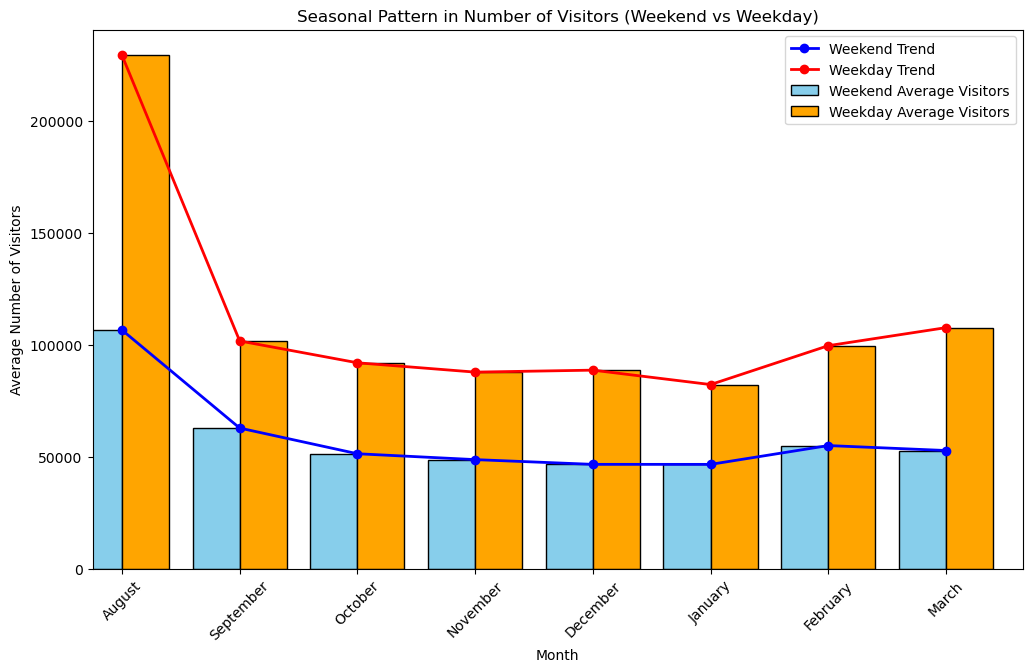

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the 'Month' column is in the correct order
month_order = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March']
weekend_mobdata = merged_df[merged_df['Time Aggregation'] == 'Weekend - All'].copy()
weekday_mobdata = merged_df[merged_df['Time Aggregation'] == 'Weekday - All'].copy()

# Process the weekend data
weekend_mobdata['Month'] = pd.Categorical(weekend_mobdata['Month'], categories=month_order, ordered=True)
weekend_means = weekend_mobdata.groupby('Month')['n_visitors'].mean().reindex(month_order)

# Process the weekday data
weekday_mobdata['Month'] = pd.Categorical(weekday_mobdata['Month'], categories=month_order, ordered=True)
weekday_means = weekday_mobdata.groupby('Month')['n_visitors'].mean().reindex(month_order)

# Plotting the combined data
plt.figure(figsize=(12, 7))

# Plotting weekend data
ax = weekend_means.plot(kind='bar', color='skyblue', width=0.4, position=1, edgecolor='black', label='Weekend Average Visitors')

# Plotting weekday data
weekday_means.plot(kind='bar', color='orange', width=0.4, position=0, edgecolor='black', label='Weekday Average Visitors', ax=ax)

# Add a line plot for the trend
weekend_means.plot(kind='line', color='blue', marker='o', linewidth=2, label='Weekend Trend', ax=ax)
weekday_means.plot(kind='line', color='red', marker='o', linewidth=2, label='Weekday Trend', ax=ax)

# Labels and title
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.title('Seasonal Pattern in Number of Visitors (Weekend vs Weekday)')
plt.xticks(rotation=45)
plt.legend()

plt.show()


## 5.3 Correlation Analysis

### 5.3.1 Initial Correlation between Meteorological Variables and Mobility Data

Correlation values with n_visitors (filtered) in order:
n_visitors                           1.000000
Solar Radiation (Total)              0.185252
Surface Solar Radiation (Total)      0.183180
longitude                            0.160136
Temperature (Mean)                   0.145444
Dew Point Temperature (Mean)         0.134103
Snow Depth (Total)                   0.128900
Daylight Minutes (Mean)              0.124793
Surface Pressure (Mean)              0.110303
Wind Speed U Component (Mean)        0.040563
Precipitation (Total)                0.021735
Total Precipitation Rate (Sum)       0.021729
Wind Speed V Component (Mean)        0.001926
Wind Gust (Mean)                    -0.056871
Max Wind Gust (Mean)                -0.058310
Snowfall (Total)                    -0.058909
Snow Density (Total)                -0.062598
latitude                            -0.150258
Surface Thermal Radiation (Total)   -0.152499
Name: n_visitors, dtype: float64


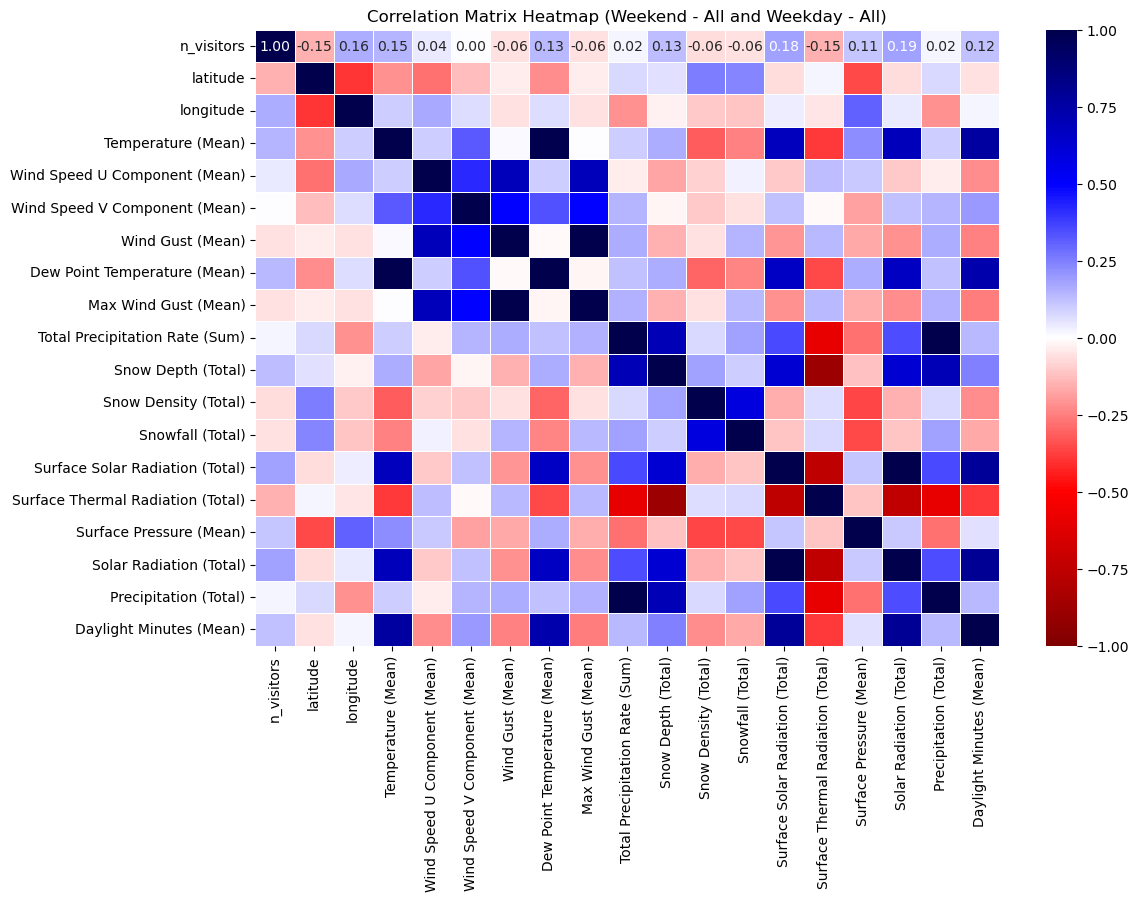

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data to focus only on 'Weekend - All' and 'Weekday - All'
filtered_df = merged_df[(merged_df['Time Aggregation']=='Weekend - All') | (merged_df['Time Aggregation']=='Weekday - All')]

# Select only numeric columns from the filtered data
numeric_cols_filtered = filtered_df.select_dtypes(include=[float, int])

# Calculate the correlation matrix for numeric columns
corr_matrix_filtered = numeric_cols_filtered.corr()

# Filter the correlations with n_visitors
n_visitors_corr_filtered = corr_matrix_filtered['n_visitors'].sort_values(ascending=False)

# Print the correlation values in order
print("Correlation values with n_visitors (filtered) in order:")
print(n_visitors_corr_filtered)

# Plotting the correlation matrix using seaborn heatmap for filtered data
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='seismic_r', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (Weekend - All and Weekday - All)")
plt.show()


### 5.3.2 Correlation between Meteorological Variables and Mobility Data in Specific Regions (Rural & Urban)

n_visitors                           1.000000
longitude                            0.233782
Surface Solar Radiation (Total)      0.220453
Solar Radiation (Total)              0.217178
Surface Pressure (Mean)              0.183618
Temperature (Mean)                   0.164382
Snow Depth (Total)                   0.154676
Dew Point Temperature (Mean)         0.144171
Daylight Minutes (Mean)              0.133123
Wind Speed U Component (Mean)        0.029548
Precipitation (Total)                0.010139
Total Precipitation Rate (Sum)       0.010133
Wind Speed V Component (Mean)        0.001912
Wind Gust (Mean)                    -0.050216
Max Wind Gust (Mean)                -0.051707
Snowfall (Total)                    -0.098402
Snow Density (Total)                -0.113819
latitude                            -0.181847
Surface Thermal Radiation (Total)   -0.216217
Name: n_visitors, dtype: float64


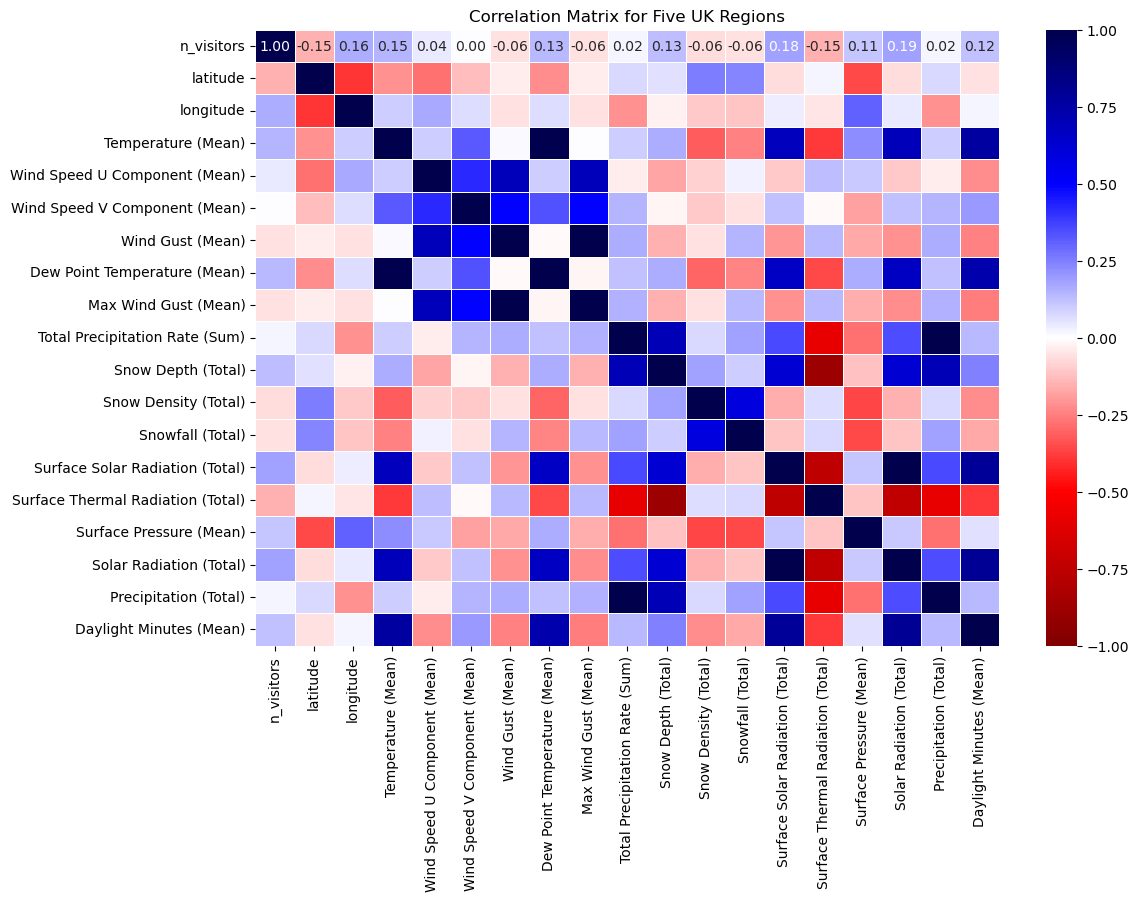

In [23]:
df = pd.DataFrame(merged_df)
# Step 1: Define regions based on the given coordinates logic
London = df[(df['longitude'] >= -0.5) & (df['longitude'] <= 0.5) & (df['latitude'] >= 51.25) & (df['latitude'] <= 51.75)]
Edinburgh = df[(df['longitude'] <= -3) & (df['longitude'] >= -3.5) & (df['latitude'] >= 55.75) & (df['latitude'] <= 56)]
SI_Cornwall = df[(df['longitude'] <= -5.25) & (df['longitude'] >= -5.5) & (df['latitude'] >= 50) & (df['latitude'] <= 50.25)]
W_LakeDistrict = df[(df['longitude'] >= -3) & (df['longitude'] <= -2.75) & (df['latitude'] >= 54.25) & (df['latitude'] <= 54.5)]
Manchester = df[(df['longitude'] >= -2.75) & (df['longitude'] <= -2) & (df['latitude'] >= 53.25) & (df['latitude'] <= 53.75)]

# Step 2: Concatenate the regional data into one DataFrame
regions_combined = pd.concat([London, Edinburgh, SI_Cornwall, W_LakeDistrict, Manchester])

# Step 3: Drop non-numeric columns (if any exist)
regions_combined_numeric = regions_combined.select_dtypes(include=[float, int])

# Step 4: Calculate the correlation matrix
correlation_matrix = regions_combined_numeric.corr()

# Step 5: Sort the correlations for a specific variable (for example, 'n_visitors')
sorted_correlations = correlation_matrix['n_visitors'].sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlations)

# Step 6: Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='seismic_r', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Five UK Regions')
plt.show()

### 5.5.3 Surface Solar Radiation (Total) - Clear Days & Cloudy Days

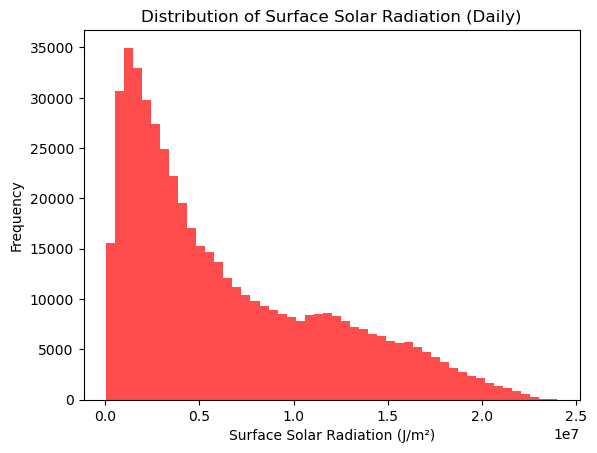

count    5.055300e+05
mean     6.553378e+06
std      5.354293e+06
min      5.172062e+04
25%      2.159652e+06
50%      4.763346e+06
75%      1.021523e+07
max      2.398164e+07
Name: Surface Solar Radiation (Total), dtype: float64


In [29]:
import matplotlib.pyplot as plt

# Explore the distribution of Surface Solar Radiation (Total)
plt.hist(weather_daily['Surface Solar Radiation (Total)'], bins=50, color=(1, 0, 0, 0.7))
plt.title('Distribution of Surface Solar Radiation (Daily)')
plt.xlabel('Surface Solar Radiation (J/m²)')
plt.ylabel('Frequency')
plt.show()

# Explore some descriptive statistics for Solar Radiation to fine-tune the threshold
print(weather_daily['Surface Solar Radiation (Total)'].describe())


### 5.5 Generating Additional Weather Variables

In [31]:
import pandas as pd
import numpy as np

# Assuming 'weather_daily' DataFrame has already been created and processed as you described

# Add 'Month Period' based on your custom function
def classify_month_period(dt):
    if dt >= pd.to_datetime('2023-08-01').date() and dt <= pd.to_datetime('2023-08-31').date():
        return "August"
    elif dt >= pd.to_datetime('2023-09-01').date() and dt <= pd.to_datetime('2023-09-30').date():
        return "September"
    elif dt >= pd.to_datetime('2023-10-01').date() and dt <= pd.to_datetime('2023-10-22').date():
        return "October - Not Included"
    elif dt >= pd.to_datetime('2023-10-23').date() and dt <= pd.to_datetime('2023-11-19').date():
        return "October"
    elif dt >= pd.to_datetime('2023-11-20').date() and dt <= pd.to_datetime('2023-12-17').date():
        return "November"
    elif dt >= pd.to_datetime('2023-12-18').date() and dt <= pd.to_datetime('2023-12-31').date():
        return "December"
    elif dt >= pd.to_datetime('2024-01-01').date() and dt <= pd.to_datetime('2024-01-14').date():
        return "January"
    elif dt >= pd.to_datetime('2024-02-12').date() and dt <= pd.to_datetime('2024-03-10').date():
        return "February"
    elif dt >= pd.to_datetime('2024-03-11').date() and dt <= pd.to_datetime('2024-04-07').date():
        return "March"
    else:
        return "Others"

# Apply the classification function to create the 'Month Period' column
weather_daily['Month Period'] = weather_daily['date'].apply(classify_month_period)

# Filter out 'Others' and 'October - Not Included'
weather_daily = weather_daily.loc[~weather_daily['Month Period'].isin(['Others', 'October - Not Included'])]

# Function to categorize day as weekday or weekend
def categorize_day_of_week(date):
    day_of_week = pd.Timestamp(date).dayofweek
    if day_of_week < 5:  # Weekdays are 0-4 (Monday to Friday)
        return 'weekday'
    else:  # Weekends are 5-6 (Saturday and Sunday)
        return 'weekend'

# Apply the day categorization
weather_daily['day_type'] = weather_daily['date'].apply(categorize_day_of_week)

# Updated Thresholds for Clear/Cloudy Days, Comfortable Days, and Dry/Wet Days
clear_radiation_threshold = 1.021523e7  # 10.2 million J/m² as the threshold for Clear days
comfortable_temp_range = (291.15, 295.15)  # Comfortable temperature range in Kelvin (18°C to 22°C)
dry_precipitation_threshold = 0.0001  # Threshold for defining dry days
wet_precipitation_threshold = 0.025  # Threshold for defining wet days

# Categorize days based on conditions and use .loc to avoid SettingWithCopyWarning
weather_daily.loc[:, 'Clear/Cloudy'] = np.where(weather_daily['Surface Solar Radiation (Total)'] >= clear_radiation_threshold, 'Clear', 'Cloudy')
weather_daily.loc[:, 'Comfortable Day'] = np.where(
    (weather_daily['Temperature (Mean)'] >= comfortable_temp_range[0]) & (weather_daily['Temperature (Mean)'] <= comfortable_temp_range[1]),
    'Comfortable', 'Not Comfortable'
)
weather_daily.loc[:, 'Dry/Wet'] = np.where(weather_daily['Precipitation (Total)'] < dry_precipitation_threshold, 'Dry',
                                    np.where(weather_daily['Precipitation (Total)'] >= wet_precipitation_threshold, 'Wet', 'Neither'))

# Group by 'Month Period', 'latitude', 'longitude', and 'day_type' and count occurrences for each day type (weekday and weekend)
monthly_stats = weather_daily.groupby(['Month Period', 'latitude', 'longitude', 'day_type']).agg(
    Clear_Days=('Clear/Cloudy', lambda x: (x == 'Clear').sum()),
    Cloudy_Days=('Clear/Cloudy', lambda x: (x == 'Cloudy').sum()),
    Comfortable_Days=('Comfortable Day', lambda x: (x == 'Comfortable').sum()),
    Uncomfortable_Days=('Comfortable Day', lambda x: (x == 'Not Comfortable').sum()),
    Dry_Days=('Dry/Wet', lambda x: (x == 'Dry').sum()),
    Wet_Days=('Dry/Wet', lambda x: (x == 'Wet').sum())
).reset_index()

# Pivot the table to separate weekday and weekend data for all the variables
pivoted_stats = monthly_stats.pivot_table(index=['Month Period', 'latitude', 'longitude'],
                                          columns='day_type',
                                          values=['Clear_Days', 'Cloudy_Days', 'Comfortable_Days', 
                                                  'Uncomfortable_Days', 'Dry_Days', 'Wet_Days'],
                                          fill_value=0).reset_index()

# Flatten the column MultiIndex
pivoted_stats.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in pivoted_stats.columns.values]

weekend_mobdata = Mobility_Data[Mobility_Data['Time Aggregation']=='Weekend - All']
weekday_mobdata = Mobility_Data[Mobility_Data['Time Aggregation']=='Weekday - All']


/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_89350/3238532671.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_daily['day_type'] = weather_daily['date'].apply(categorize_day_of_week)
/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_89350/3238532671.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_daily.loc[:, 'Clear/Cloudy'] = np.where(weather_daily['Surface Solar Radiation (Total)'] >= clear_radiation_threshold, 'Clear', 'Cloudy')
/var/folders/y6/rbs796bx78jc

In [32]:
# Selecting columns that end with '_weekend'
weekend_variables = pivoted_stats.filter(like='_weekend')

# Selecting the columns with '_weekend' as well as 'Month', 'latitude_', and 'longitude_'
weekend_variables_with_location = pivoted_stats[['Month Period_', 'latitude_', 'longitude_']].join(weekend_variables)

# Selecting columns that end with '_weekday'
weekday_variables = pivoted_stats.filter(like='_weekday')

# Selecting the columns with '_weekday' as well as 'Month', 'latitude_', and 'longitude_'
weekday_variables_with_location = pivoted_stats[['Month Period_', 'latitude_', 'longitude_']].join(weekday_variables)

# Step 1: Rename columns for consistency
weekend_variables_with_location.rename(columns={
    'latitude_': 'latitude',
    'longitude_': 'longitude',
    'Month Period_': 'Month'
}, inplace=True)

weekday_variables_with_location.rename(columns={
    'latitude_': 'latitude',
    'longitude_': 'longitude',
    'Month Period_': 'Month'
}, inplace=True)

# Step 2: Merge the datasets based on Month, Time Aggregation, Latitude, and Longitude
merged_weekend = pd.merge(weekend_mobdata, weekend_variables_with_location, 
                     on=['latitude', 'longitude', 'Month'], 
                     how='inner')
merged_weekday = pd.merge(weekday_mobdata, weekday_variables_with_location, 
                     on=['latitude', 'longitude', 'Month'], 
                     how='inner')
print(merged_weekend.shape)
merged_weekend.head()

(652019, 14)


qk_id Time Aggregation  n_visitors   Month corrected_qk_id  \
0  3113113013203    Weekend - All        1664  August  03113113013203   
1  3113113031000    Weekend - All        3383  August  03113113031000   
2  3113113031001    Weekend - All        2361  August  03113113031001   
3  3113113033233    Weekend - All        1162  August  03113113033233   
4  3113113013221    Weekend - All        2730  August  03113113013221   

   latitude  longitude                   geometry  Clear_Days_weekend  \
0      60.0      -0.75  POINT (-0.85000 60.79000)                 6.0   
1      60.0      -0.75  POINT (-0.87000 60.75000)                 6.0   
2      60.0      -0.75  POINT (-0.85000 60.75000)                 6.0   
3      60.0      -0.75  POINT (-0.80000 60.59000)                 6.0   
4      60.0      -0.75  POINT (-0.85000 60.78000)                 6.0   

   Cloudy_Days_weekend  Comfortable_Days_weekend  Dry_Days_weekend  \
0                  2.0                       0.0               1.0   
1                  2.0                       0.0               1.0   
2                  2.0                       0.0               1.0   
3                  2.0                       0.0               1.0   
4                  2.0                       0.0               1.0   

   Uncomfortable_Days_weekend  Wet_Days_weekend  
0                         8.0               0.0  
1                         8.0               0.0  
2                         8.0               0.0  
3                         8.0               0.0  
4                         8.0               0.0

In [33]:
print(merged_weekday.shape)
merged_weekday.head()

(653197, 14)


qk_id Time Aggregation  n_visitors   Month corrected_qk_id  \
0  3131103002320    Weekday - All       35840  August  03131103002320   
1  3131103002322    Weekday - All       40946  August  03131103002322   
2  3131103003202    Weekday - All        5481  August  03131103003202   
3  3131103002111    Weekday - All       27916  August  03131103002111   
4  3131103003132    Weekday - All       32839  August  03131103003132   

   latitude  longitude                   geometry  Clear_Days_weekday  \
0     54.75       -4.0  POINT (-4.12000 54.79000)                20.0   
1     54.75       -4.0  POINT (-4.12000 54.78000)                20.0   
2     54.75       -4.0  POINT (-4.03000 54.81000)                20.0   
3     54.75       -4.0  POINT (-4.05000 54.87000)                20.0   
4     54.75       -4.0  POINT (-3.90000 54.83000)                20.0   

   Cloudy_Days_weekday  Comfortable_Days_weekday  Dry_Days_weekday  \
0                  3.0                       1.0               3.0   
1                  3.0                       1.0               3.0   
2                  3.0                       1.0               3.0   
3                  3.0                       1.0               3.0   
4                  3.0                       1.0               3.0   

   Uncomfortable_Days_weekday  Wet_Days_weekday  
0                        22.0               0.0  
1                        22.0               0.0  
2                        22.0               0.0  
3                        22.0               0.0  
4                        22.0               0.0

### 5.5.4 Correlation Plot

n_visitors                    1.000000
longitude                     0.170050
Comfortable_Days_weekend      0.135880
Clear_Days_weekend            0.130863
Dry_Days_weekend              0.028290
Uncomfortable_Days_weekend   -0.012007
Wet_Days_weekend             -0.038430
Cloudy_Days_weekend          -0.095138
latitude                     -0.161185
Name: n_visitors, dtype: float64


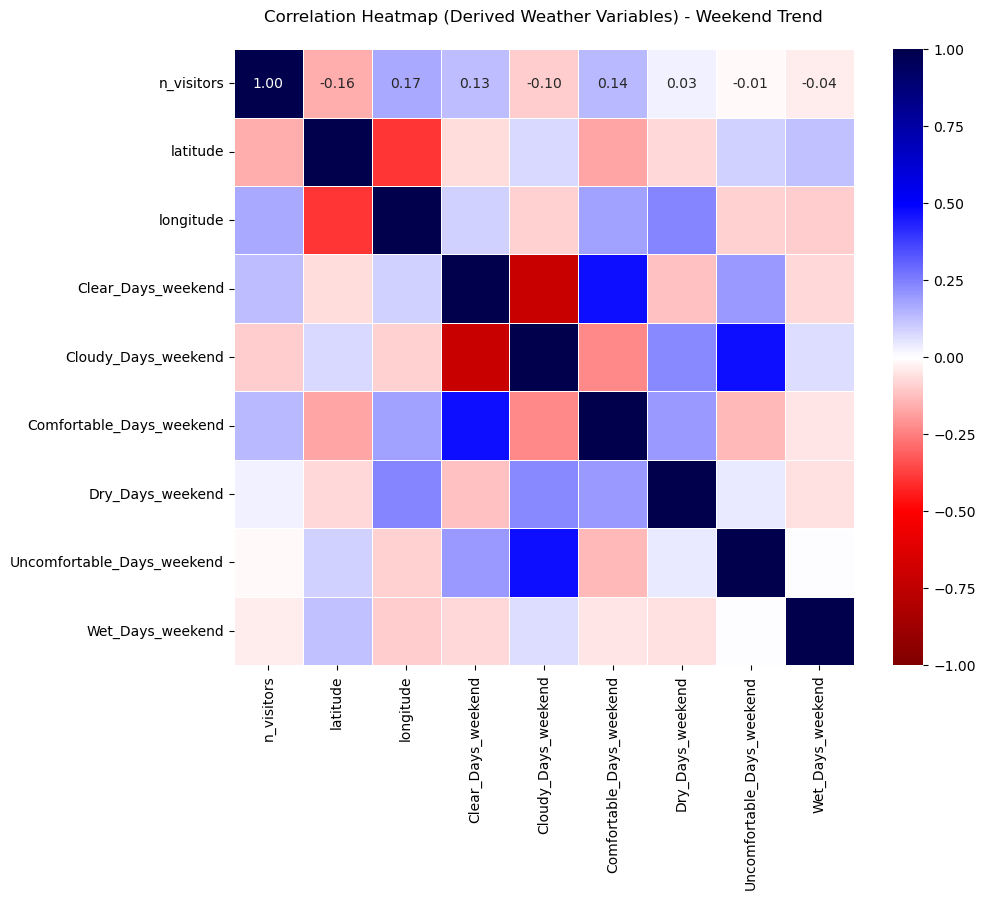

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Drop non-numeric columns (if any exist)
merged_weekend = merged_weekend.select_dtypes(include=[float, int])
merged_weekend_ = merged_weekend.drop(columns=['qk_id'])

# Calculate correlation
correlation = merged_weekend_.corr()

# Sort correlation values based on n_visitors
correlation_sorted = correlation['n_visitors'].sort_values(ascending=False)
print(correlation_sorted)

# Plot the correlation heatmap with values on top of the grid
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='seismic_r', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap (Derived Weather Variables) - Weekend Trend', pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


n_visitors                    1.000000
longitude                     0.168898
Comfortable_Days_weekday      0.163415
Clear_Days_weekday            0.151824
Dry_Days_weekday              0.084622
Uncomfortable_Days_weekday    0.015739
Wet_Days_weekday             -0.052924
Cloudy_Days_weekday          -0.090475
latitude                     -0.157663
Name: n_visitors, dtype: float64


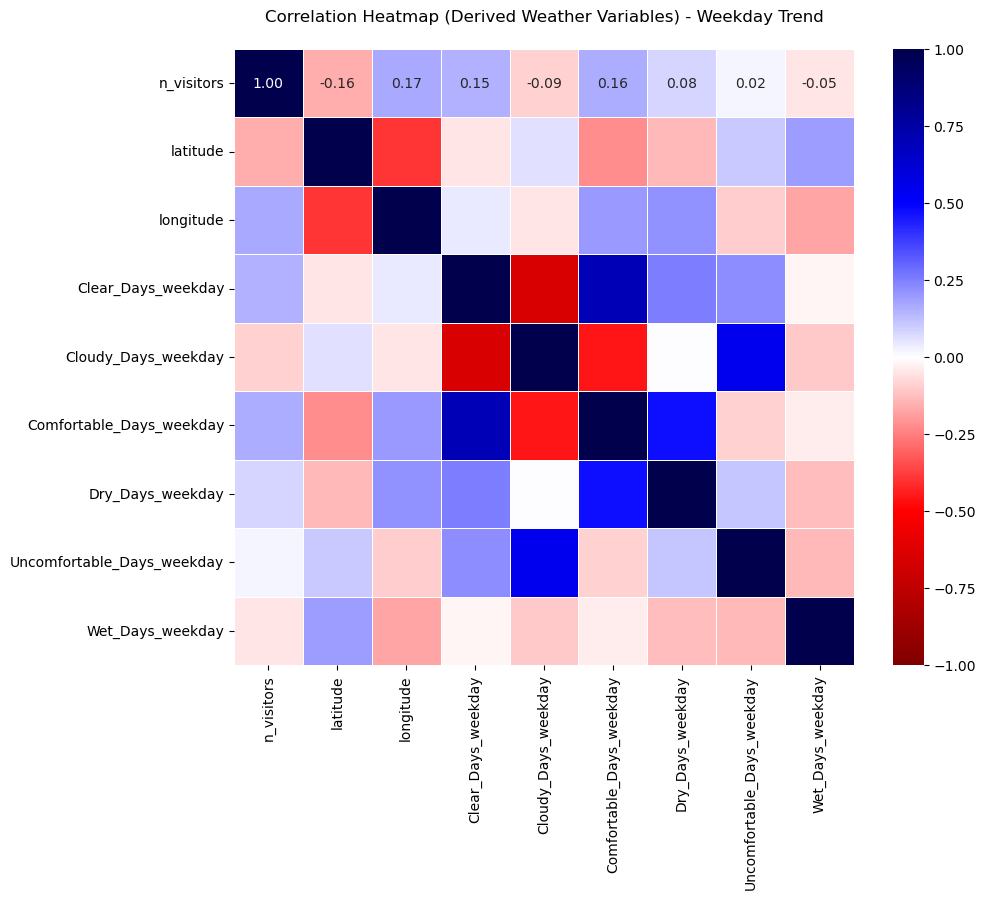

In [37]:
merged_weekday = merged_weekday.select_dtypes(include=[float, int])
merged_weekday_ = merged_weekday.drop(columns=['qk_id'])

# Calculate correlation
correlation = merged_weekday_.corr()

# Sort correlation values based on n_visitors
correlation_sorted = correlation['n_visitors'].sort_values(ascending=False)
print(correlation_sorted)

# Plot the correlation heatmap with values on top of the grid
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='seismic_r', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap (Derived Weather Variables) - Weekday Trend', pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 5.7 Statistical Modelling: Across UK

In [25]:
import pandas as pd
import statsmodels.api as sm

#Linear Regression

# Define the dependent variable (Y) and independent variables (X)
X = merged_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
Y = merged_weekday['n_visitors']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             n_visitors   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5145.
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:39:40   Log-Likelihood:            -9.0477e+06
No. Observations:              653197   AIC:                         1.810e+07
Df Residuals:                  653188   BIC:                         1.810e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                 1.292e+04
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:39:43   Log-Likelihood:            -1.3858e+06
No. Observations:              653197   AIC:                         2.772e+06
Df Residuals:                  653188   BIC:                         2.772e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


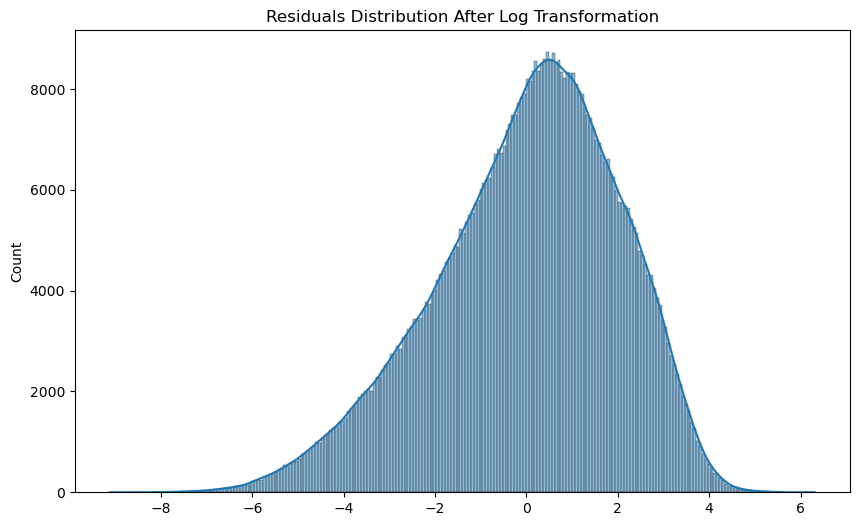

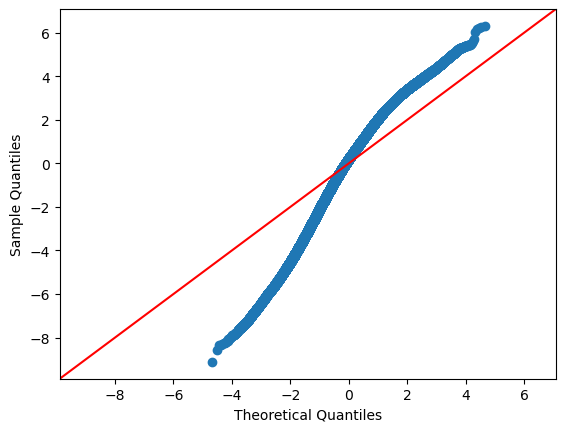

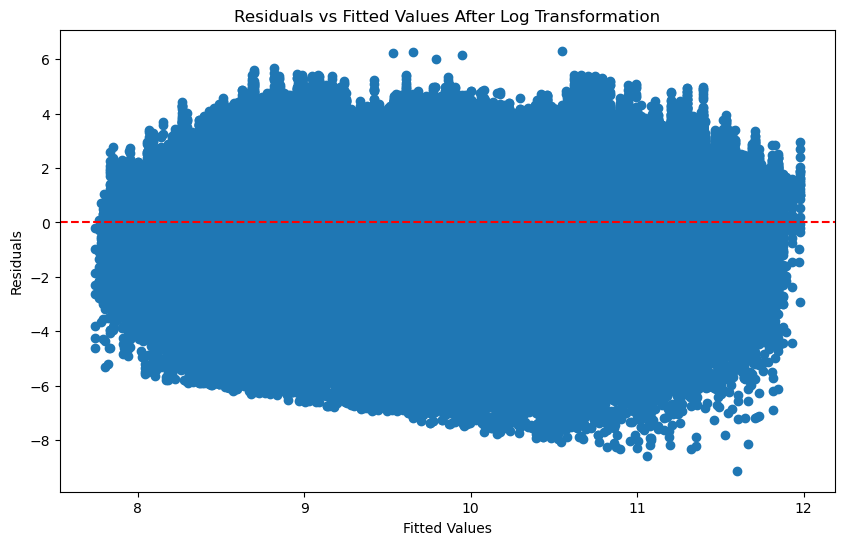

In [26]:
# Log transform the dependent variable
merged_weekday['log_n_visitors'] = np.log1p(merged_weekday['n_visitors'])

# Re-run the regression with the transformed dependent variable
X = merged_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]

X = sm.add_constant(X)
model_log = sm.OLS(merged_weekday['log_n_visitors'], X).fit()

# Print the summary
print(model_log.summary())

# Plot residuals to check for improvements
residuals_log = model_log.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_log, kde=True)
plt.title('Residuals Distribution After Log Transformation')
plt.show()

# Q-Q plot for normality check after transformation
sm.qqplot(residuals_log, line='45')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after transformation
plt.figure(figsize=(10, 6))
plt.scatter(model_log.fittedvalues, residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Log Transformation')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     530.7
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        07:55:58   Log-Likelihood:            -1.3593e+06
No. Observations:              653197   AIC:                         2.719e+06
Df Residuals:                  652881   BIC:                         2.723e+06
Df Model:                         315                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        325.3217     36.402      8.937      0.0

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


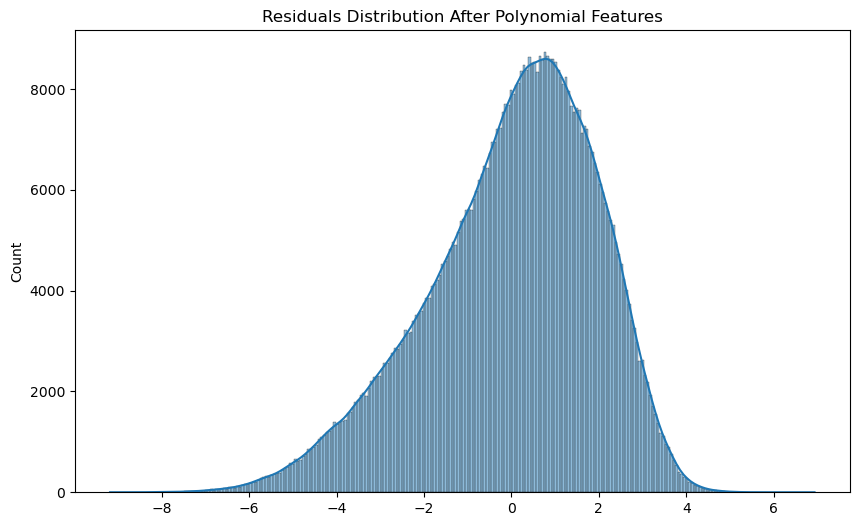

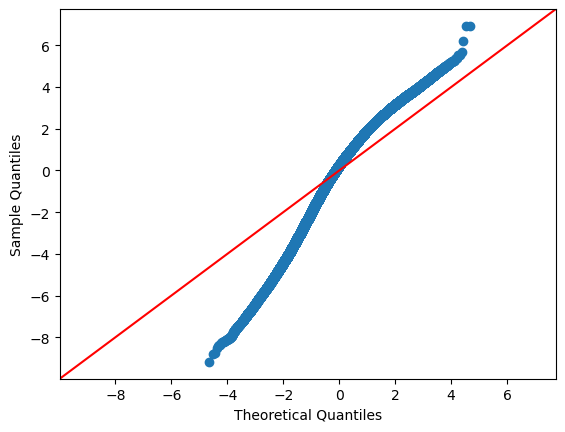

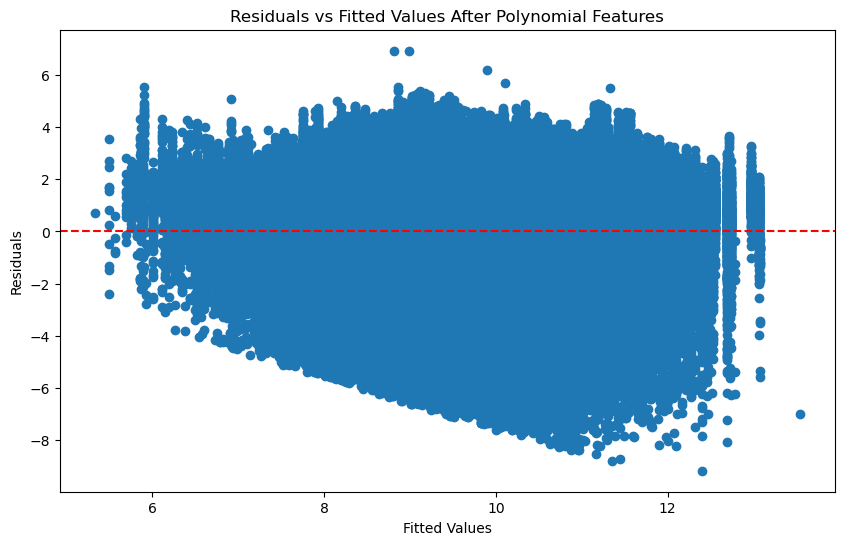

In [27]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features of degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(merged_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']])

# Fit the model with polynomial features
model_poly = sm.OLS(merged_weekday['log_n_visitors'], sm.add_constant(X_poly)).fit()

# Print the summary-
print(model_poly.summary())

# Check residuals after using polynomial features
residuals_poly = model_poly.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_poly, kde=True)
plt.title('Residuals Distribution After Polynomial Features')
plt.show()

# Q-Q plot for normality check after polynomial features
sm.qqplot(residuals_poly, line='45')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after polynomial features
plt.figure(figsize=(10, 6))
plt.scatter(model_poly.fittedvalues, residuals_poly)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Polynomial Features')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


GAM R-squared: 0.2062578525188249
Mean Absolute Error (MAE): 1.5492466456347105
Mean Squared Error (MSE): 3.7474390270595643
Root Mean Squared Error (RMSE): 1.93583031980067


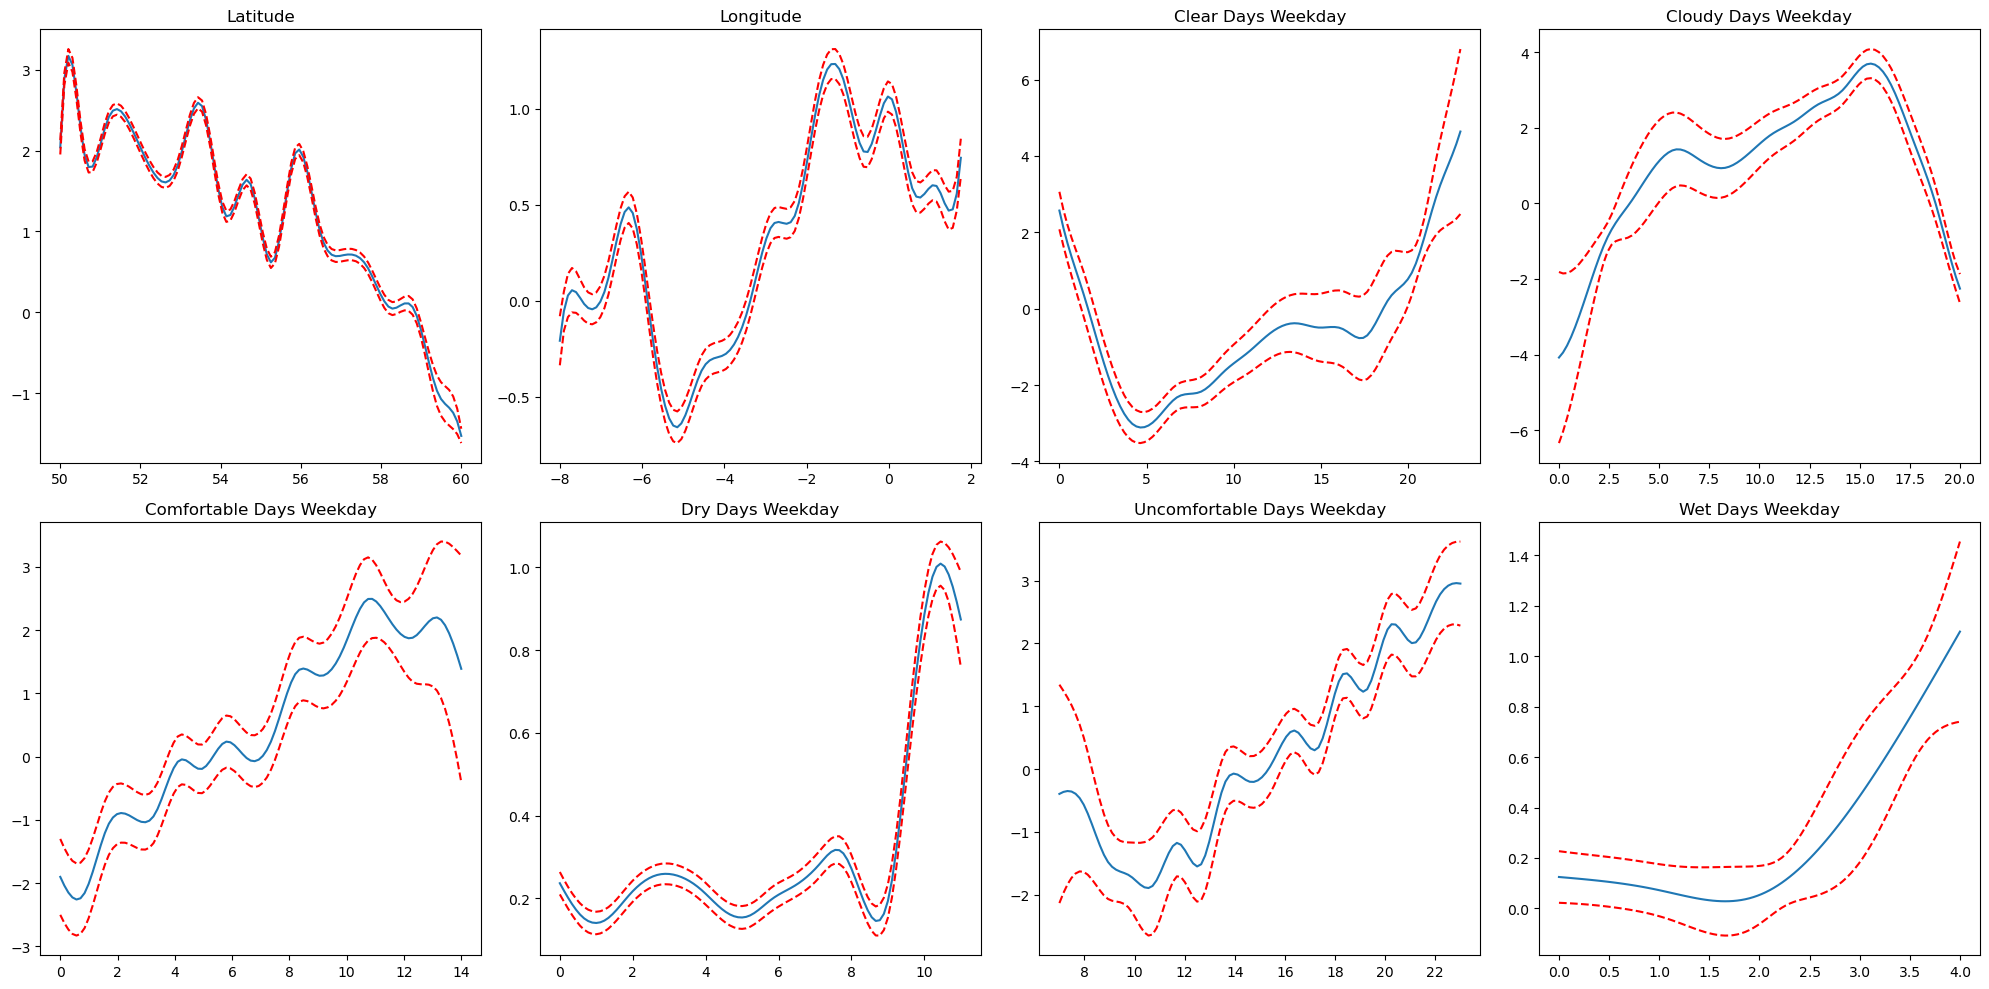

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


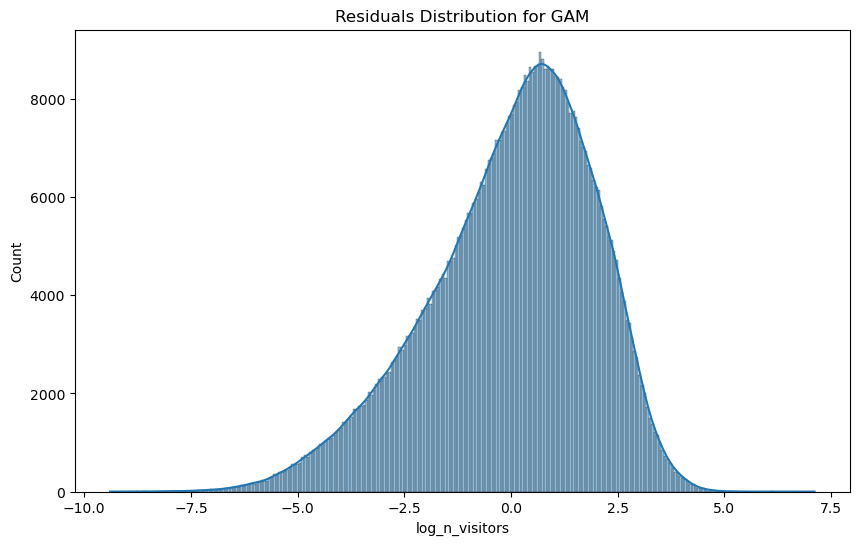

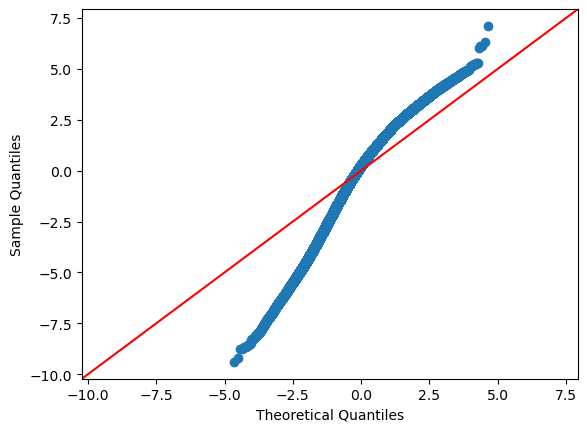

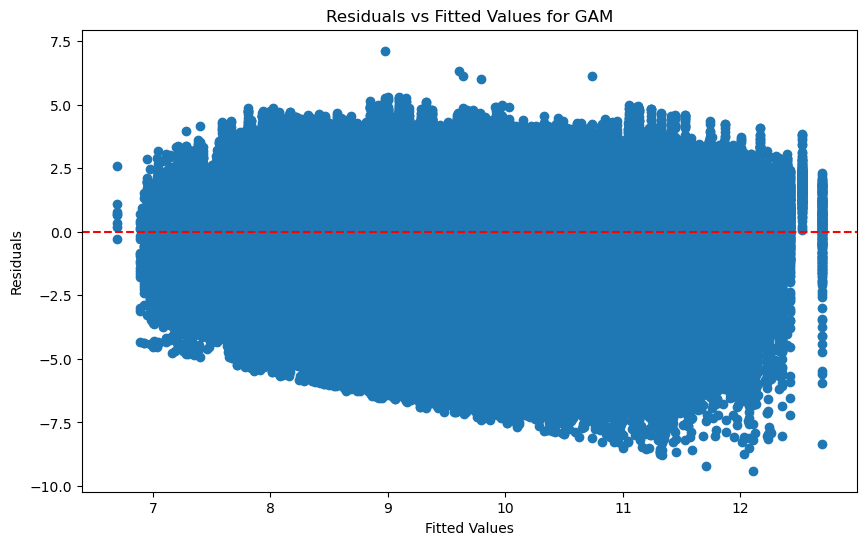

In [30]:
from pygam import LinearGAM, s, f
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a GAM model with smoothing splines for each continuous predictor
X_gam = merged_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
y_gam = merged_weekday['log_n_visitors']

# Include smoothing for all predictors
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_gam, y_gam)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gam = gam.predict(X_gam)
r2 = r2_score(y_gam, y_pred_gam)
mae = mean_absolute_error(y_gam, y_pred_gam)
mse = mean_squared_error(y_gam, y_pred_gam)
rmse = np.sqrt(mse)

print(f"GAM R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the partial dependence of each feature
num_terms = X_gam.shape[1]  # Number of terms in the model
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the grid size based on the number of terms
titles = ['Latitude', 'Longitude', 'Clear Days Weekday', 'Cloudy Days Weekday',
          'Comfortable Days Weekday', 'Dry Days Weekday',
          'Uncomfortable Days Weekday', 'Wet Days Weekday']
axs = axs.flatten()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()

# Residuals plot for GAM
residuals_gam = y_gam - y_pred_gam
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gam, kde=True)
plt.title('Residuals Distribution for GAM')
plt.show()

# Q-Q plot for normality check in GAM
sm.qqplot(residuals_gam, line='45')
plt.show()

# Plot residuals vs fitted values for GAM
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gam, residuals_gam)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for GAM')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Random Forest R-squared: 0.35334859321441614
Mean Absolute Error (MAE): 1.3821485731905603
Mean Squared Error (MSE): 3.0616227439259363
Root Mean Squared Error (RMSE): 1.7497493374554929


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


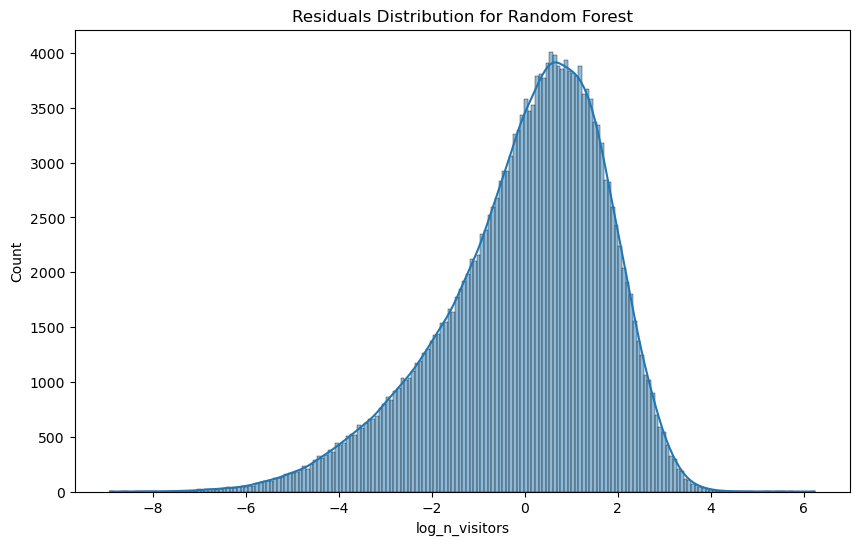

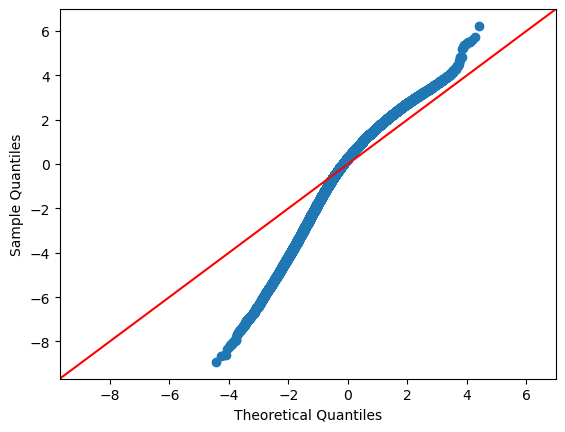

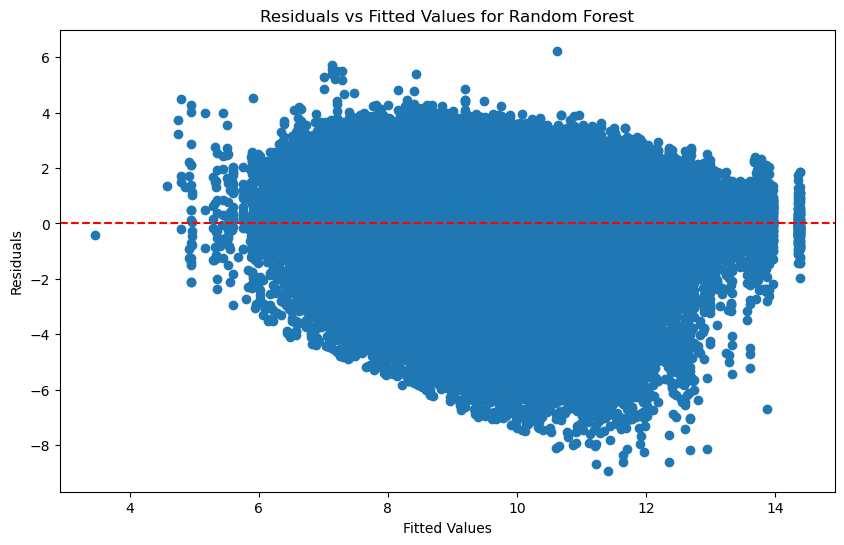

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Prepare data
X_rf = merged_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
y_rf = merged_weekday['log_n_visitors']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_rf = rf.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Random Forest R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True)
plt.title('Residuals Distribution for Random Forest')
plt.show()

# Q-Q plot for normality check in Random Forest
sm.qqplot(residuals_rf, line='45')
plt.show()

# Plot residuals vs fitted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Random Forest')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Gradient Boosting R-squared: 0.26600372504695624
Mean Absolute Error (MAE): 1.4860166308016147
Mean Squared Error (MSE): 3.4751639999111377
Root Mean Squared Error (RMSE): 1.8641791759139297


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


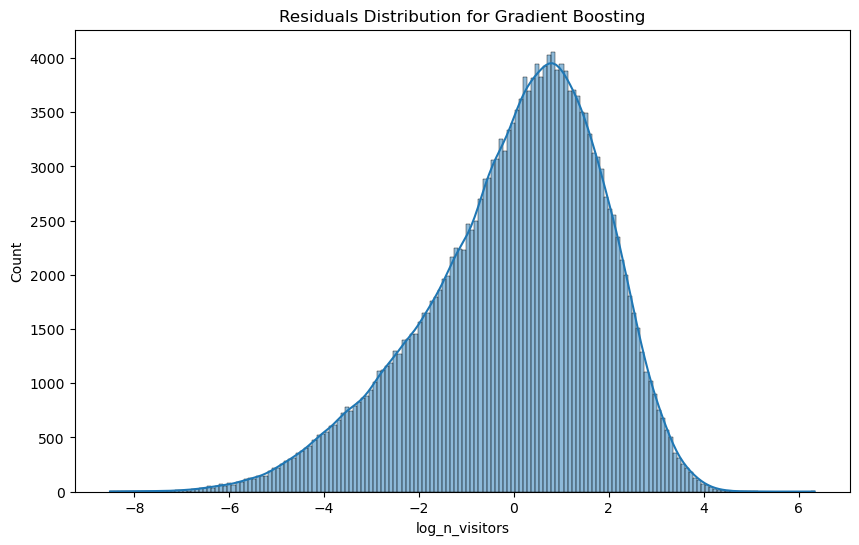

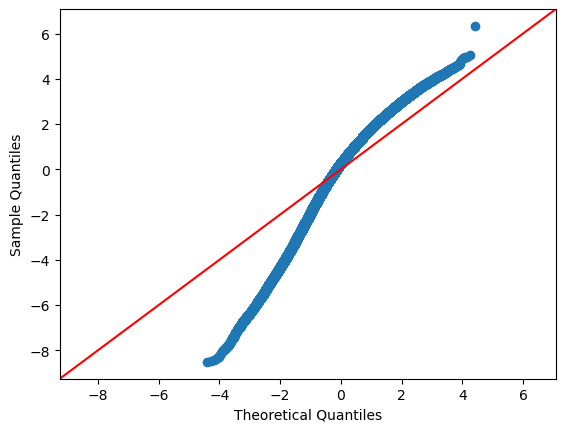

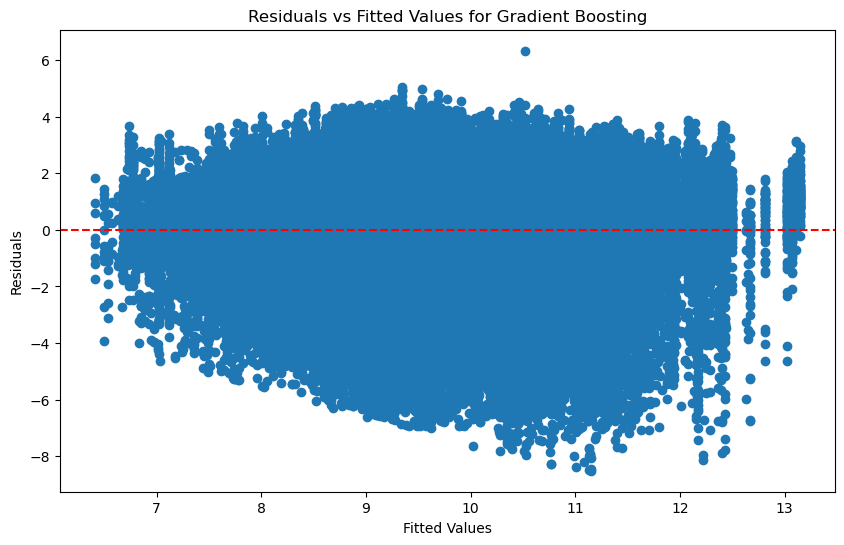

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gb = gb.predict(X_test)
r2 = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
mse = mean_squared_error(y_test, y_pred_gb)
rmse = np.sqrt(mse)

print(f"Gradient Boosting R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Gradient Boosting
residuals_gb = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gb, kde=True)
plt.title('Residuals Distribution for Gradient Boosting')
plt.show()

# Q-Q plot for normality check in Gradient Boosting
sm.qqplot(residuals_gb, line='45')
plt.show()

# Plot residuals vs fitted values for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb, residuals_gb)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Gradient Boosting')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


## 5.8 Statistical Modelling: Urban and Rural locations

In [101]:
# Urban segmentation as before
london = merged_weekday[(merged_weekday['longitude'] >= -0.5) & (merged_weekday['longitude'] <= 0.5) & 
                         (merged_weekday['latitude'] >= 51.25) & (merged_weekday['latitude'] <= 51.75)]

edinburgh = merged_weekday[(merged_weekday['longitude'] <= -3) & (merged_weekday['longitude'] >= -3.5) & 
                            (merged_weekday['latitude'] >= 55.75) & (merged_weekday['latitude'] <= 56)]

si_cornwall = merged_weekday[(merged_weekday['longitude'] <= -5.25) & (merged_weekday['longitude'] >= -5.5) & 
                              (merged_weekday['latitude'] >= 50) & (merged_weekday['latitude'] <= 50.25)]

w_lakedistrict = merged_weekday[(merged_weekday['longitude'] >= -3) & (merged_weekday['longitude'] <= -2.75) & 
                                 (merged_weekday['latitude'] >= 54.25) & (merged_weekday['latitude'] <= 54.5)]

manchester = merged_weekday[(merged_weekday['longitude'] >= -2.75) & (merged_weekday['longitude'] <= -2) & 
                             (merged_weekday['latitude'] >= 53.25) & (merged_weekday['latitude'] <= 53.75)]

# Combine urban and rural dataframes
urban_data_weekday = pd.concat([london, edinburgh, manchester])
rural_data_weekday = pd.concat([si_cornwall, w_lakedistrict])

# Urban segmentation as before
london = merged_weekend[(merged_weekend['longitude'] >= -0.5) & (merged_weekend['longitude'] <= 0.5) & 
                         (merged_weekend['latitude'] >= 51.25) & (merged_weekend['latitude'] <= 51.75)]

edinburgh = merged_weekend[(merged_weekend['longitude'] <= -3) & (merged_weekend['longitude'] >= -3.5) & 
                            (merged_weekend['latitude'] >= 55.75) & (merged_weekend['latitude'] <= 56)]

si_cornwall = merged_weekend[(merged_weekend['longitude'] <= -5.25) & (merged_weekend['longitude'] >= -5.5) & 
                              (merged_weekend['latitude'] >= 50) & (merged_weekend['latitude'] <= 50.25)]

w_lakedistrict = merged_weekend[(merged_weekend['longitude'] >= -3) & (merged_weekend['longitude'] <= -2.75) & 
                                 (merged_weekend['latitude'] >= 54.25) & (merged_weekend['latitude'] <= 54.5)]

manchester = merged_weekend[(merged_weekend['longitude'] >= -2.75) & (merged_weekend['longitude'] <= -2) & 
                             (merged_weekend['latitude'] >= 53.25) & (merged_weekend['latitude'] <= 53.75)]

# Combine urban and rural dataframes
urban_data_weekend = pd.concat([london, edinburgh, manchester])
rural_data_weekend = pd.concat([si_cornwall, w_lakedistrict])

ruralurban_weekday = pd.concat([urban_data_weekday, rural_data_weekday], axis=0)
ruralurban_weekend = pd.concat([urban_data_weekend, rural_data_weekend], axis=0)
print(ruralurban_weekday.shape)
ruralurban_weekday.head()

(59254, 11)


qk_id  n_visitors  latitude  longitude  Clear_Days_weekday  \
7550  12020202030101     2040477      51.5        0.5                19.0   
7551  12020202013233        3518      51.5        0.5                19.0   
7552  12020202013200        4924      51.5        0.5                19.0   
7553  12020202030112     1382683      51.5        0.5                19.0   
7554  12020202011223      593076      51.5        0.5                19.0   

      Cloudy_Days_weekday  Comfortable_Days_weekday  Dry_Days_weekday  \
7550                  4.0                      11.0               6.0   
7551                  4.0                      11.0               6.0   
7552                  4.0                      11.0               6.0   
7553                  4.0                      11.0               6.0   
7554                  4.0                      11.0               6.0   

      Uncomfortable_Days_weekday  Wet_Days_weekday  log_n_visitors  
7550                        12.0               0.0       14.528695  
7551                        12.0               0.0        8.165932  
7552                        12.0               0.0        8.502080  
7553                        12.0               0.0       14.139537  
7554                        12.0               0.0       13.293080

In [97]:
print(ruralurban_weekend.shape)
ruralurban_weekend.head()

(59226, 10)


qk_id  n_visitors  latitude  longitude  Clear_Days_weekend  \
2814  3131311331013       44521     51.75        0.0                 7.0   
2815  3131311331232       66204     51.75        0.0                 7.0   
2816  3131311333123     1780826     51.75        0.0                 7.0   
2817  3131311333310      780250     51.75        0.0                 7.0   
2818  3131311333112      733109     51.75        0.0                 7.0   

      Cloudy_Days_weekend  Comfortable_Days_weekend  Dry_Days_weekend  \
2814                  1.0                       3.0               0.0   
2815                  1.0                       3.0               0.0   
2816                  1.0                       3.0               0.0   
2817                  1.0                       3.0               0.0   
2818                  1.0                       3.0               0.0   

      Uncomfortable_Days_weekend  Wet_Days_weekend  
2814                         5.0               0.0  
2815                         5.0               0.0  
2816                         5.0               0.0  
2817                         5.0               0.0  
2818                         5.0               0.0

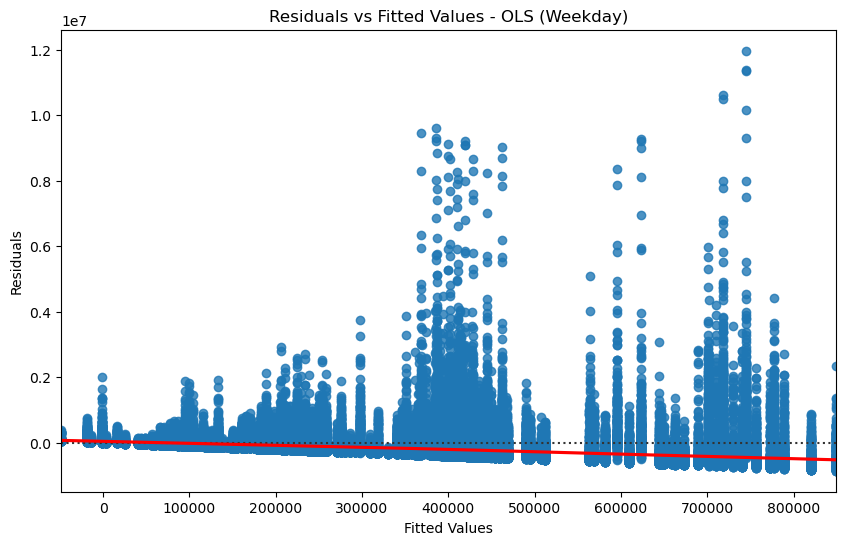

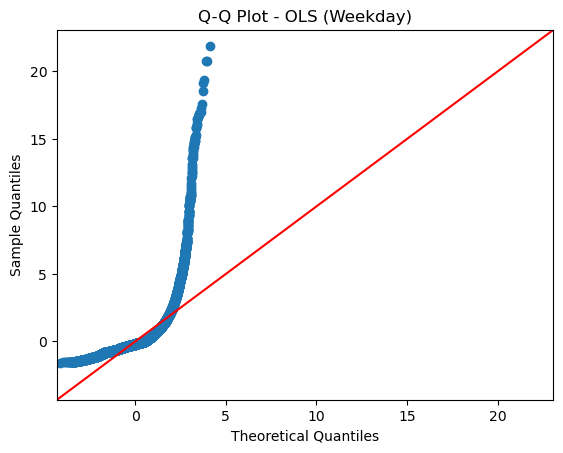

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


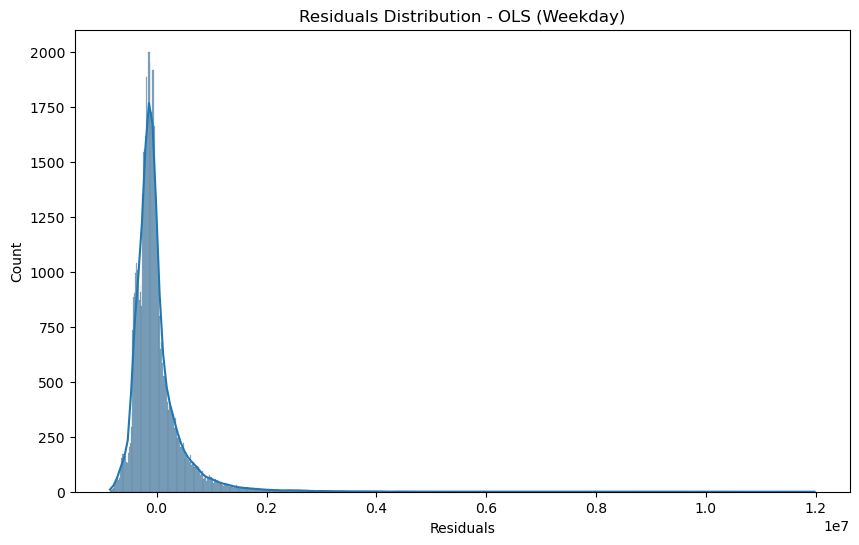

                            OLS Regression Results                            
Dep. Variable:             n_visitors   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     790.5
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:16:58   Log-Likelihood:            -8.6697e+05
No. Observations:               59254   AIC:                         1.734e+06
Df Residuals:                   59245   BIC:                         1.734e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [102]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

#Linear Regression

# Define the dependent variable (Y) and independent variables (X)
X = ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
Y = ruralurban_weekday['n_visitors']


# Add a constant to the model (intercept)
X = sm.add_constant(X)


# Generate the predicted values (fitted values)
fitted_values = model.fittedvalues

# Generate the residuals
residuals = model.resid

# 1. Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - OLS (Weekday)')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot - OLS (Weekday)')
plt.show()

# 3. Residuals Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution - OLS (Weekday)')
plt.show()

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     1348.
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:18:21   Log-Likelihood:            -1.2151e+05
No. Observations:               59254   AIC:                         2.430e+05
Df Residuals:                   59245   BIC:                         2.431e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


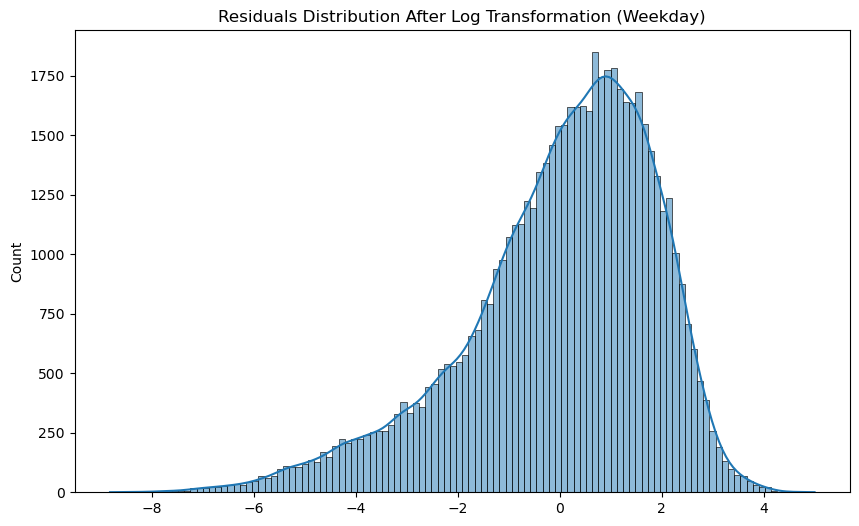

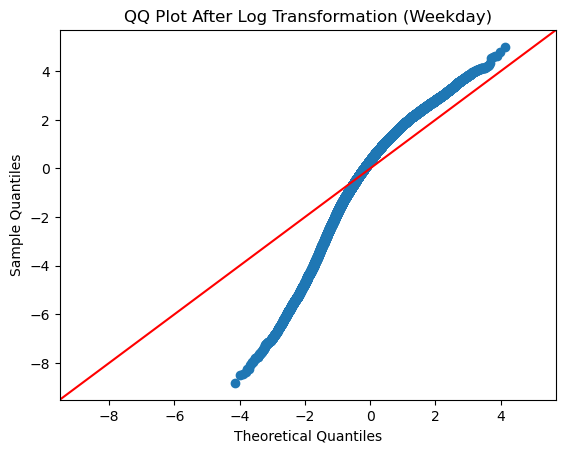

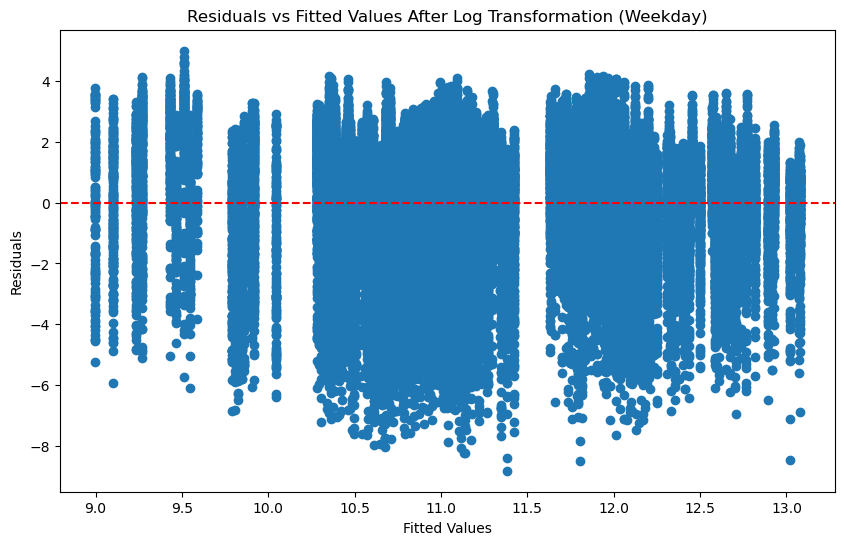

In [104]:
# Log transform the dependent variable
ruralurban_weekday['log_n_visitors'] = np.log1p(ruralurban_weekday['n_visitors'])

# Re-run the regression with the transformed dependent variable
X = ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]

X = sm.add_constant(X)
model_log = sm.OLS(ruralurban_weekday['log_n_visitors'], X).fit()

# Print the summary
print(model_log.summary())

# Plot residuals to check for improvements
residuals_log = model_log.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_log, kde=True)
plt.title('Residuals Distribution After Log Transformation (Weekday)')
plt.show()

# Q-Q plot for normality check after transformation
sm.qqplot(residuals_log, line='45')
plt.title('QQ Plot After Log Transformation (Weekday)')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after transformation
plt.figure(figsize=(10, 6))
plt.scatter(model_log.fittedvalues, residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Log Transformation (Weekday)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     156.2
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:20:22   Log-Likelihood:            -1.1471e+05
No. Observations:               59254   AIC:                         2.298e+05
Df Residuals:                   59069   BIC:                         2.315e+05
Df Model:                         184                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6964      0.404     24.000      0.0

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


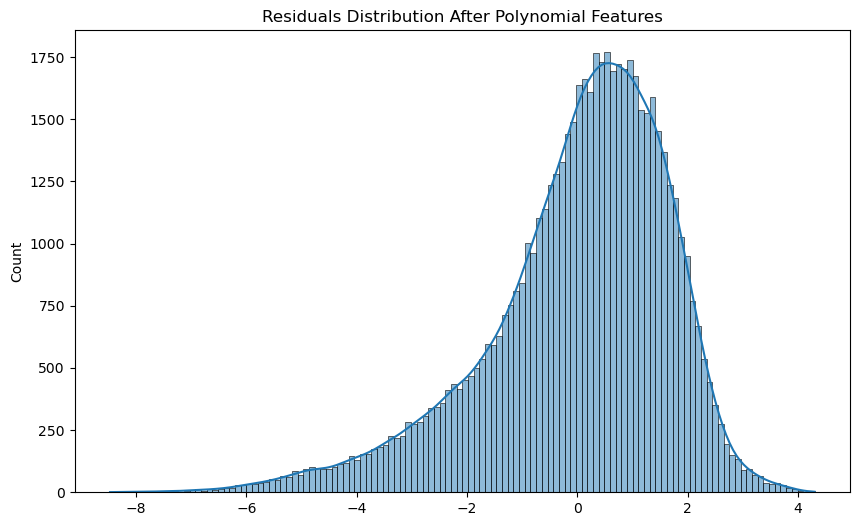

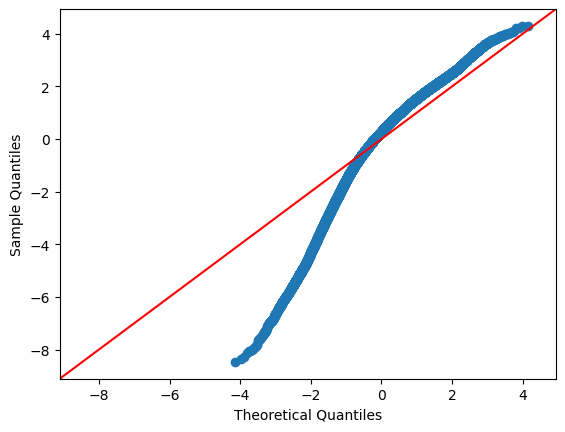

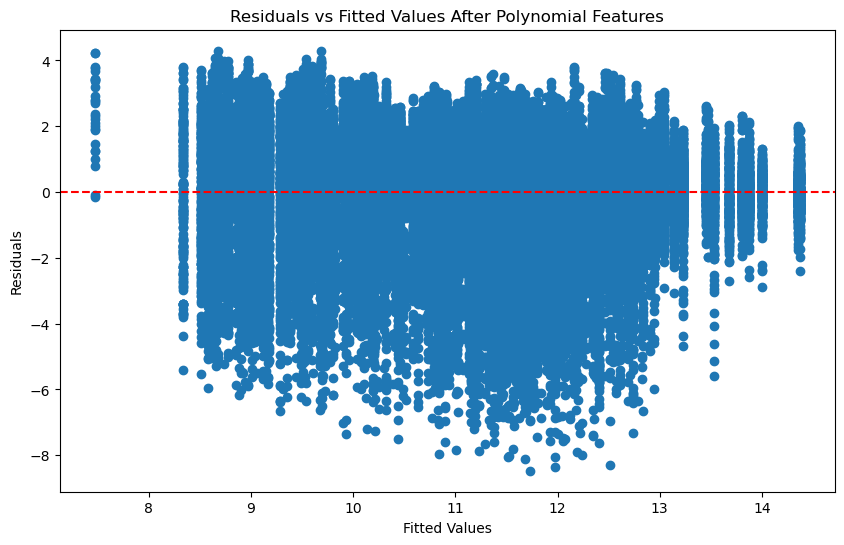

In [47]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features of degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']])

# Fit the model with polynomial features
model_poly = sm.OLS(ruralurban_weekday['log_n_visitors'], sm.add_constant(X_poly)).fit()

# Print the summary-
print(model_poly.summary())

# Check residuals after using polynomial features
residuals_poly = model_poly.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_poly, kde=True)
plt.title('Residuals Distribution After Polynomial Features (Weekday)')
plt.show()

# Q-Q plot for normality check after polynomial features
sm.qqplot(residuals_poly, line='45')
plt.title('QQ Plot ')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after polynomial features
plt.figure(figsize=(10, 6))
plt.scatter(model_poly.fittedvalues, residuals_poly)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Polynomial Features (Weekday)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


GAM R-squared: 0.37437769762552175
Mean Absolute Error (MAE): 1.2234546529974364
Mean Squared Error (MSE): 2.6156540510585735
Root Mean Squared Error (RMSE): 1.617298380342531


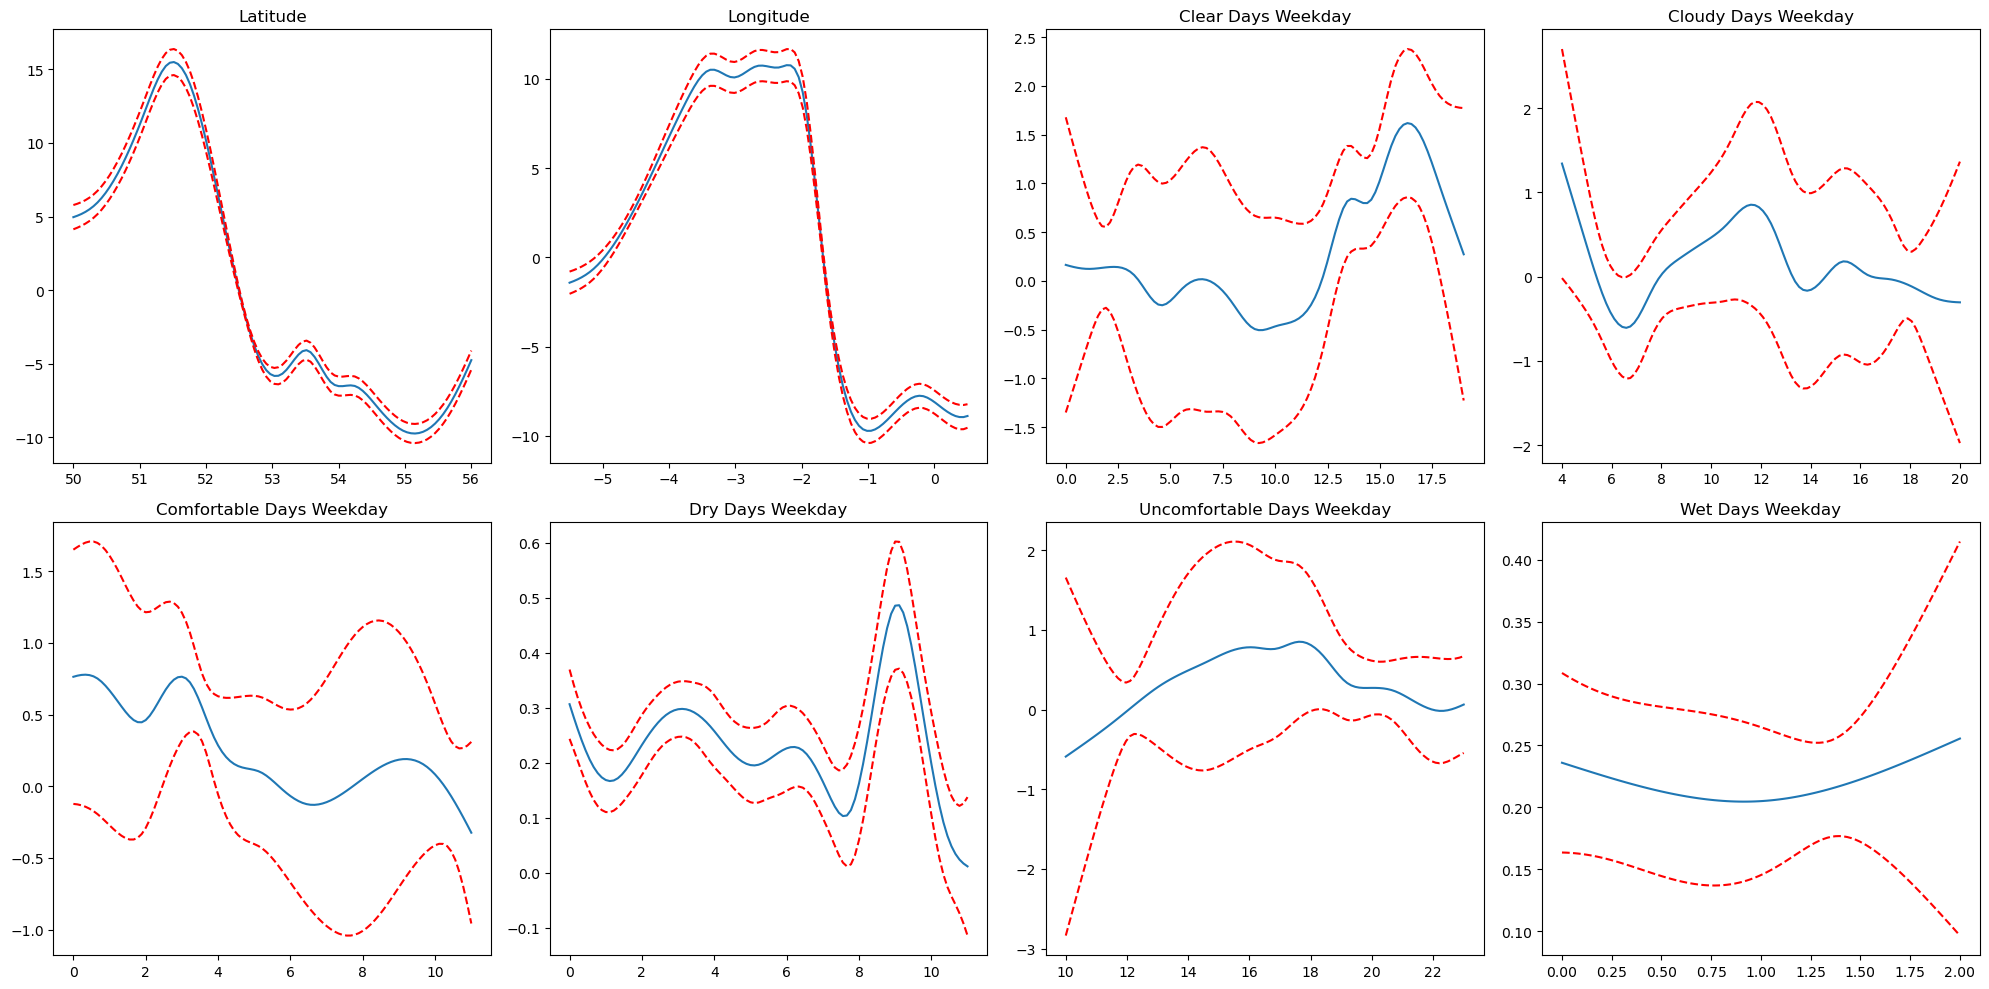

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


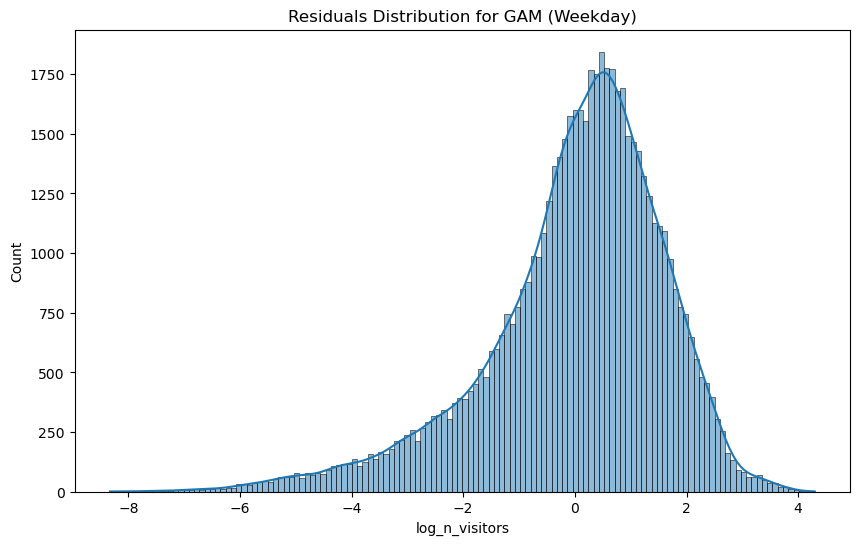

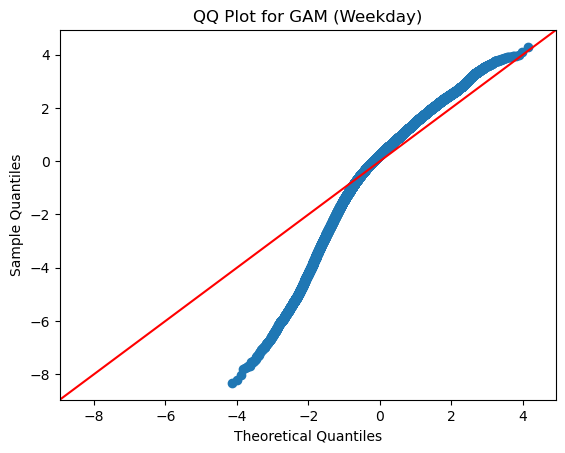

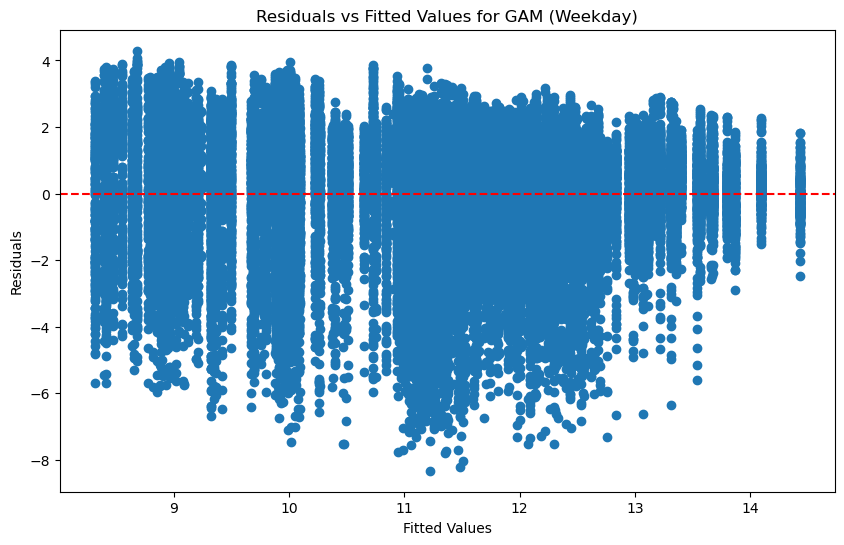

In [105]:
from pygam import LinearGAM, s, f
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a GAM model with smoothing splines for each continuous predictor
X_gam = ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
y_gam = ruralurban_weekday['log_n_visitors']

# Include smoothing for all predictors
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_gam, y_gam)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gam = gam.predict(X_gam)
r2 = r2_score(y_gam, y_pred_gam)
mae = mean_absolute_error(y_gam, y_pred_gam)
mse = mean_squared_error(y_gam, y_pred_gam)
rmse = np.sqrt(mse)

print(f"GAM R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the partial dependence of each feature
num_terms = X_gam.shape[1]  # Number of terms in the model
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the grid size based on the number of terms
titles = ['Latitude', 'Longitude', 'Clear Days Weekday', 'Cloudy Days Weekday',
          'Comfortable Days Weekday', 'Dry Days Weekday',
          'Uncomfortable Days Weekday', 'Wet Days Weekday']
axs = axs.flatten()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()

# Residuals plot for GAM
residuals_gam = y_gam - y_pred_gam
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gam, kde=True)
plt.title('Residuals Distribution for GAM (Weekday)')
plt.show()

# Q-Q plot for normality check in GAM
sm.qqplot(residuals_gam, line='45')
plt.title('QQ Plot for GAM (Weekday)')
plt.show()

# Plot residuals vs fitted values for GAM
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gam, residuals_gam)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for GAM (Weekday)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Random Forest R-squared: 0.3710483365111328
Mean Absolute Error (MAE): 1.220603688171319
Mean Squared Error (MSE): 2.6325605063054365
Root Mean Squared Error (RMSE): 1.6225167198847095


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


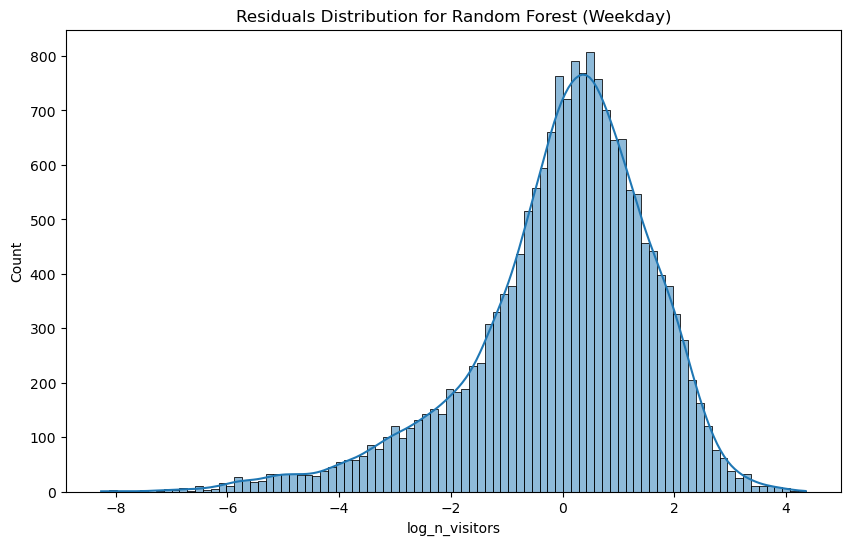

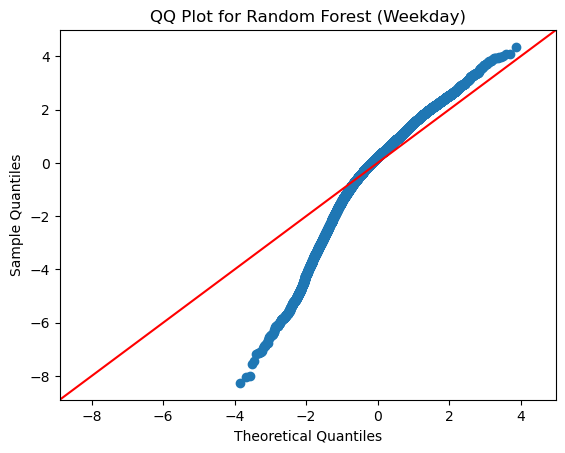

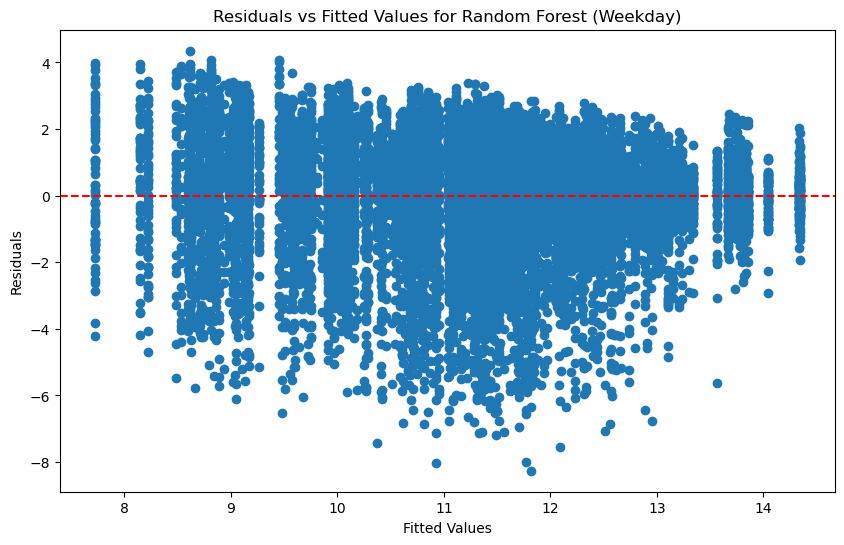

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Prepare data
X_rf = ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
y_rf = ruralurban_weekday['log_n_visitors']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_rf = rf.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Random Forest R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True)
plt.title('Residuals Distribution for Random Forest (Weekday)')
plt.show()

# Q-Q plot for normality check in Random Forest
sm.qqplot(residuals_rf, line='45')
plt.title('QQ Plot for Random Forest (Weekday)')
plt.show()

# Plot residuals vs fitted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Random Forest (Weekday)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Gradient Boosting R-squared: 0.3682339956245533
Mean Absolute Error (MAE): 1.2258944805446683
Mean Squared Error (MSE): 2.6443403029088692
Root Mean Squared Error (RMSE): 1.6261427683044527


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


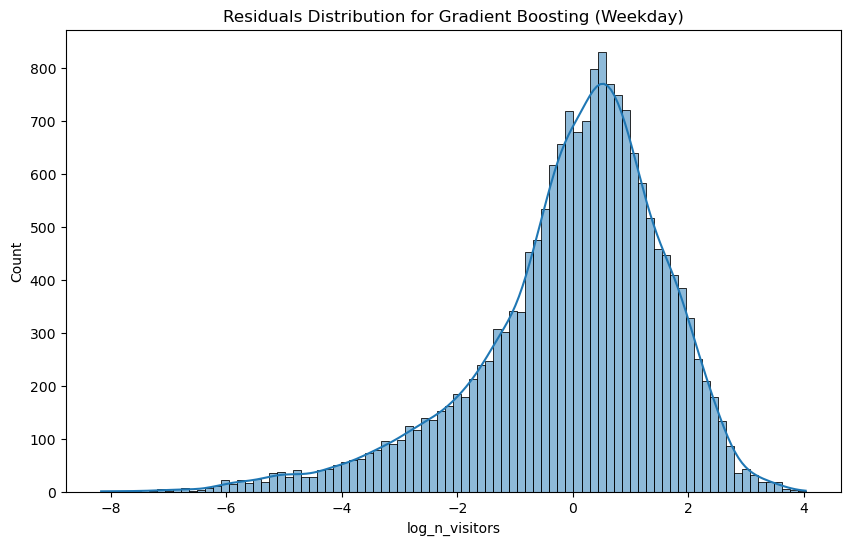

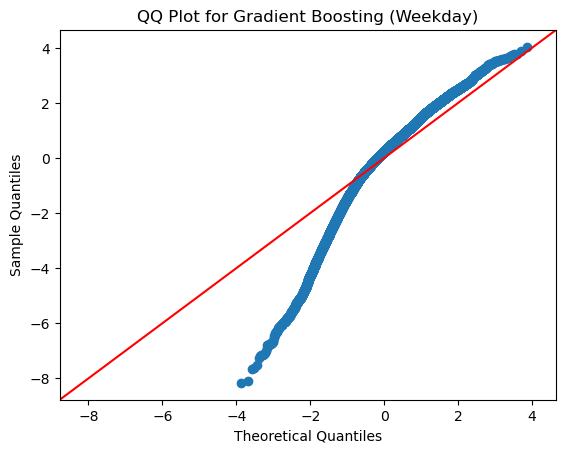

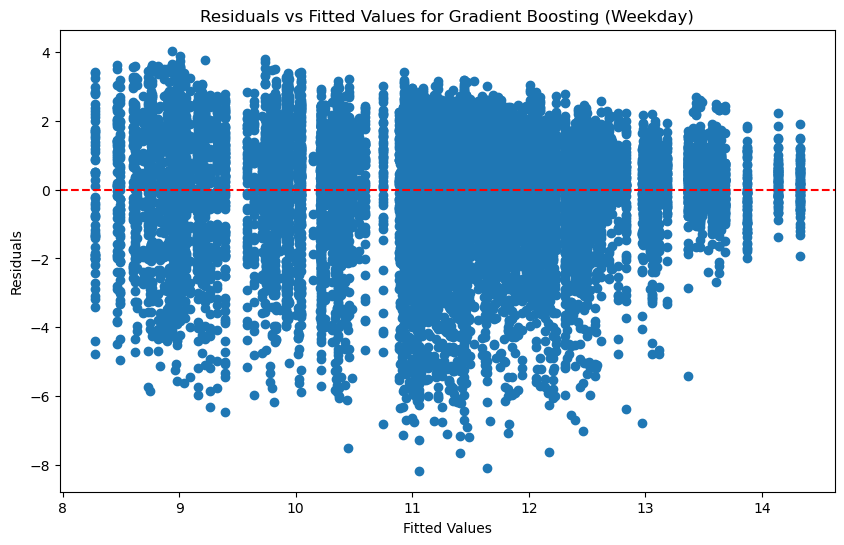

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gb = gb.predict(X_test)
r2 = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
mse = mean_squared_error(y_test, y_pred_gb)
rmse = np.sqrt(mse)

print(f"Gradient Boosting R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Gradient Boosting
residuals_gb = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gb, kde=True)
plt.title('Residuals Distribution for Gradient Boosting (Weekday)')
plt.show()

# Q-Q plot for normality check in Gradient Boosting
sm.qqplot(residuals_gb, line='45')
plt.title('QQ Plot for Gradient Boosting (Weekday)')
plt.show()

# Plot residuals vs fitted values for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb, residuals_gb)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Gradient Boosting (Weekday)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


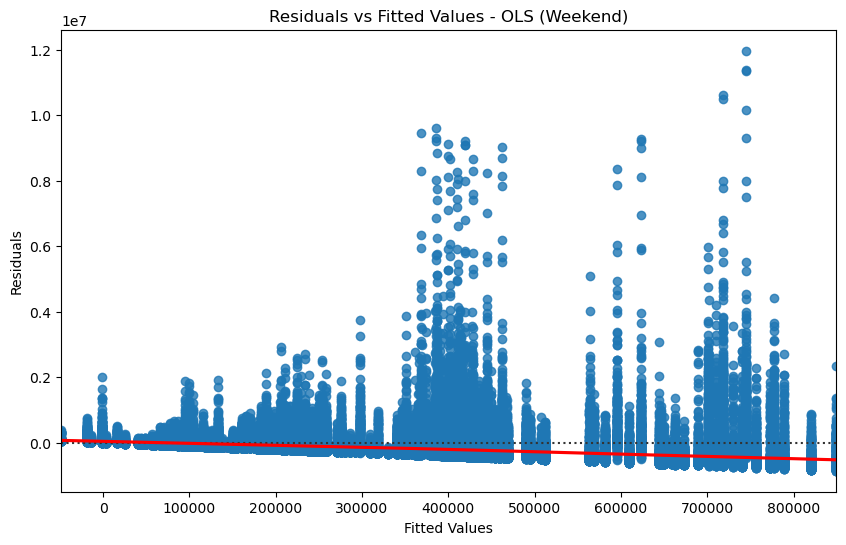

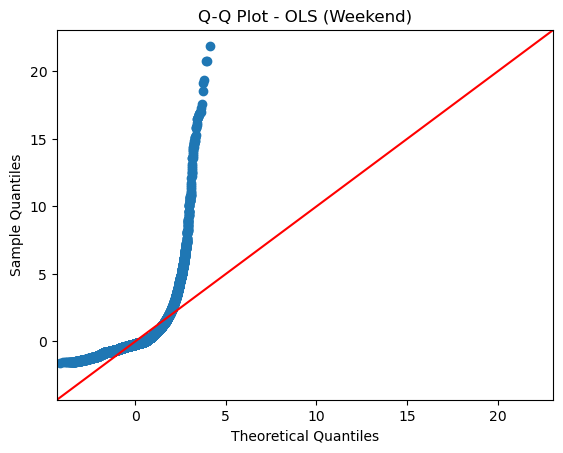

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


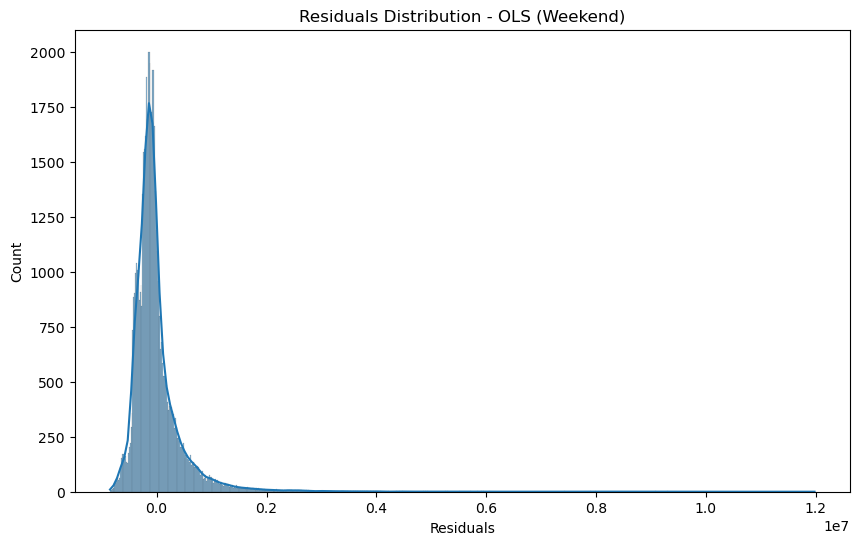

                            OLS Regression Results                            
Dep. Variable:             n_visitors   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     701.2
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:22:58   Log-Likelihood:            -8.2940e+05
No. Observations:               59226   AIC:                         1.659e+06
Df Residuals:                   59217   BIC:                         1.659e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [108]:
import pandas as pd
import statsmodels.api as sm

#Linear Regression

# Define the dependent variable (Y) and independent variables (X)
X = ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']]
Y = ruralurban_weekend['n_visitors']

# Add a constant to the model (intercept)
X = sm.add_constant(X)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# Generate the predicted values (fitted values)
fitted_values = model.fittedvalues

# Generate the residuals
residuals = model.resid

# 1. Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - OLS (Weekend)')
plt.show()

# 2. Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot - OLS (Weekend)')
plt.show()

# 3. Residuals Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution - OLS (Weekend)')
plt.show()

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1126.
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:23:39   Log-Likelihood:            -1.2274e+05
No. Observations:               59226   AIC:                         2.455e+05
Df Residuals:                   59217   BIC:                         2.456e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


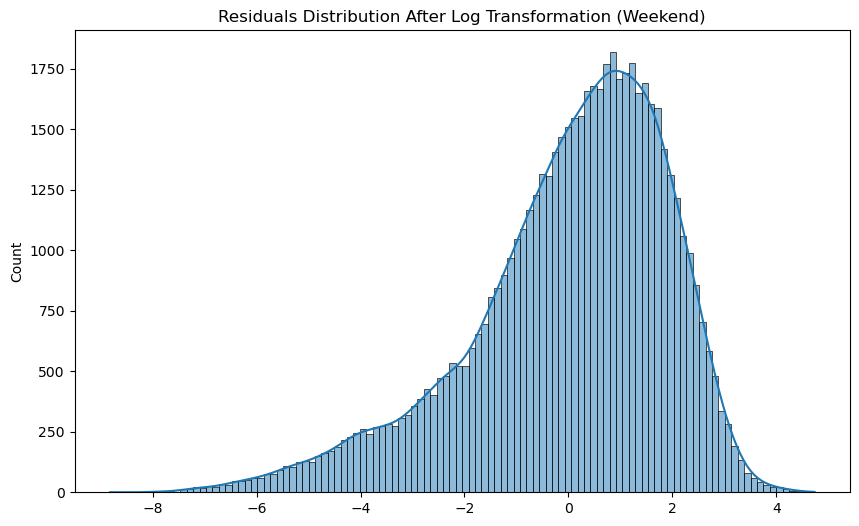

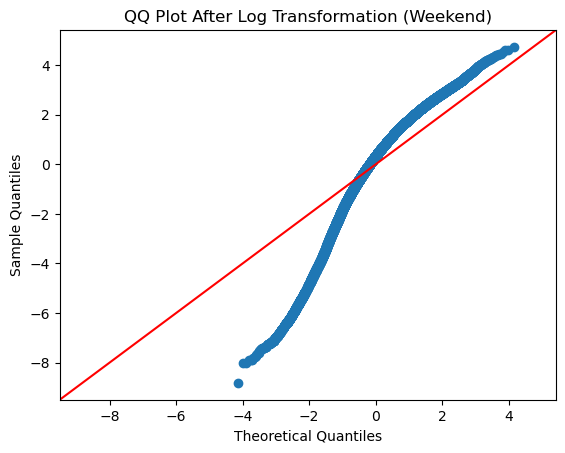

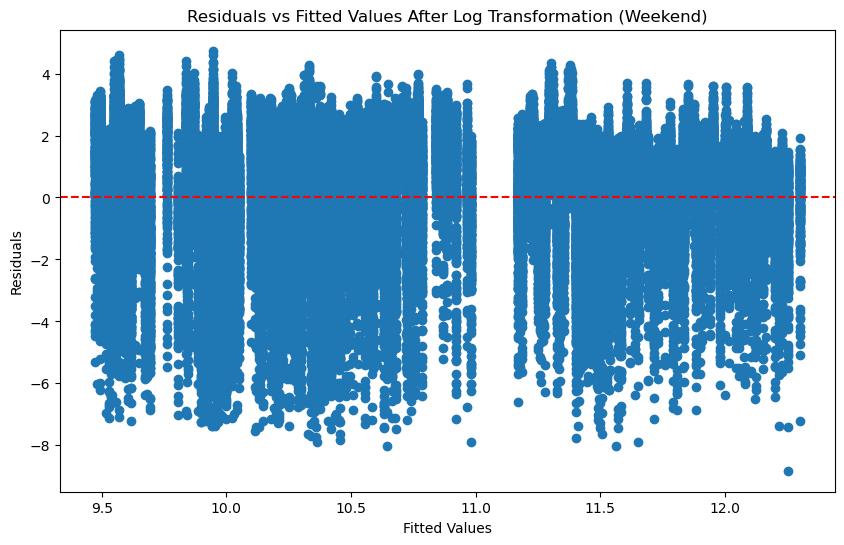

In [109]:
# Log transform the dependent variable
ruralurban_weekend['log_n_visitors'] = np.log1p(ruralurban_weekend['n_visitors'])

# Re-run the regression with the transformed dependent variable
X = ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']]

X = sm.add_constant(X)
model_log = sm.OLS(ruralurban_weekend['log_n_visitors'], X).fit()

# Print the summary
print(model_log.summary())

# Plot residuals to check for improvements
residuals_log = model_log.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_log, kde=True)
plt.title('Residuals Distribution After Log Transformation (Weekend)')
plt.show()

# Q-Q plot for normality check after transformation
sm.qqplot(residuals_log, line='45')
plt.title('QQ Plot After Log Transformation (Weekend)')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after transformation
plt.figure(figsize=(10, 6))
plt.scatter(model_log.fittedvalues, residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Log Transformation (Weekend)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:         log_n_visitors   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     170.7
Date:                Sat, 31 Aug 2024   Prob (F-statistic):               0.00
Time:                        08:22:29   Log-Likelihood:            -1.1609e+05
No. Observations:               59226   AIC:                         2.325e+05
Df Residuals:                   59072   BIC:                         2.339e+05
Df Model:                         153                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        477.7283     23.009     20.763      0.0

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


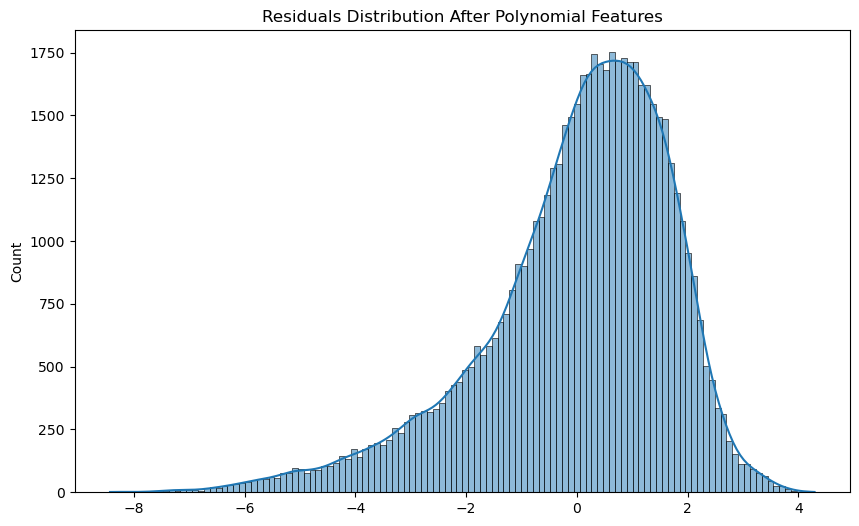

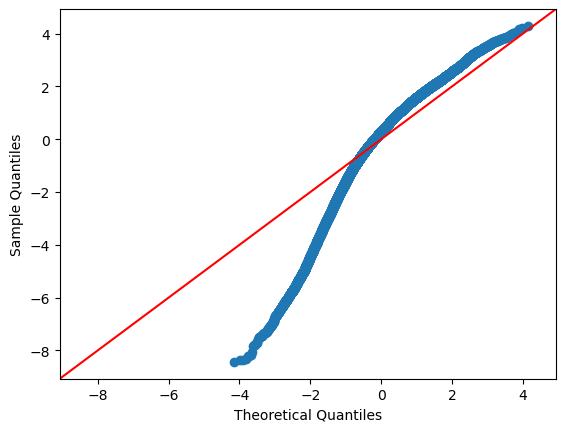

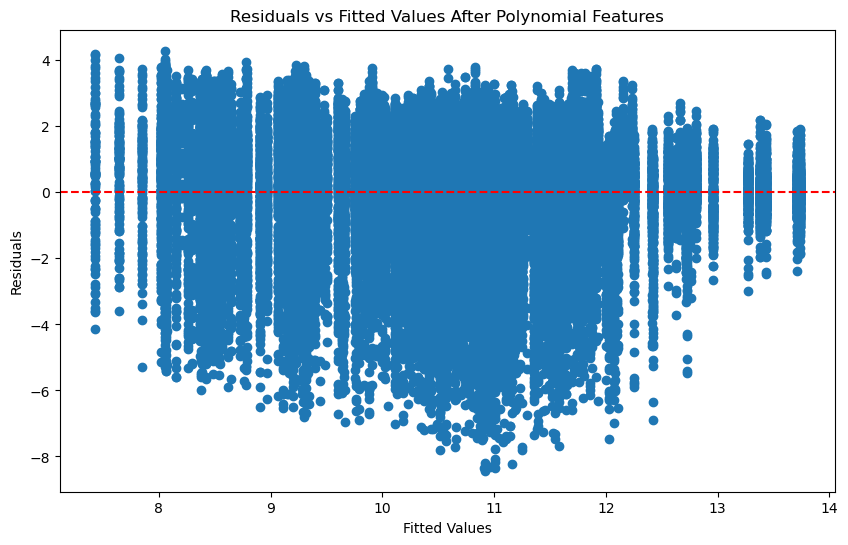

In [53]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features of degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']])

# Fit the model with polynomial features
model_poly = sm.OLS(ruralurban_weekend['log_n_visitors'], sm.add_constant(X_poly)).fit()

# Print the summary-
print(model_poly.summary())

# Check residuals after using polynomial features
residuals_poly = model_poly.resid
plt.figure(figsize=(10, 6))
sns.histplot(residuals_poly, kde=True)
plt.title('Residuals Distribution After Polynomial Features (Weekend)')
plt.show()

# Q-Q plot for normality check after polynomial features
sm.qqplot(residuals_poly, line='45')
plt.title('QQ Plot ')
plt.show()

# Plot residuals vs fitted values to check for non-linearity after polynomial features
plt.figure(figsize=(10, 6))
plt.scatter(model_poly.fittedvalues, residuals_poly)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values After Polynomial Features (Weekend)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


GAM R-squared: 0.35581502982399815
Mean Absolute Error (MAE): 1.2513725491296548
Mean Squared Error (MSE): 2.742216123892468
Root Mean Squared Error (RMSE): 1.655963805127536


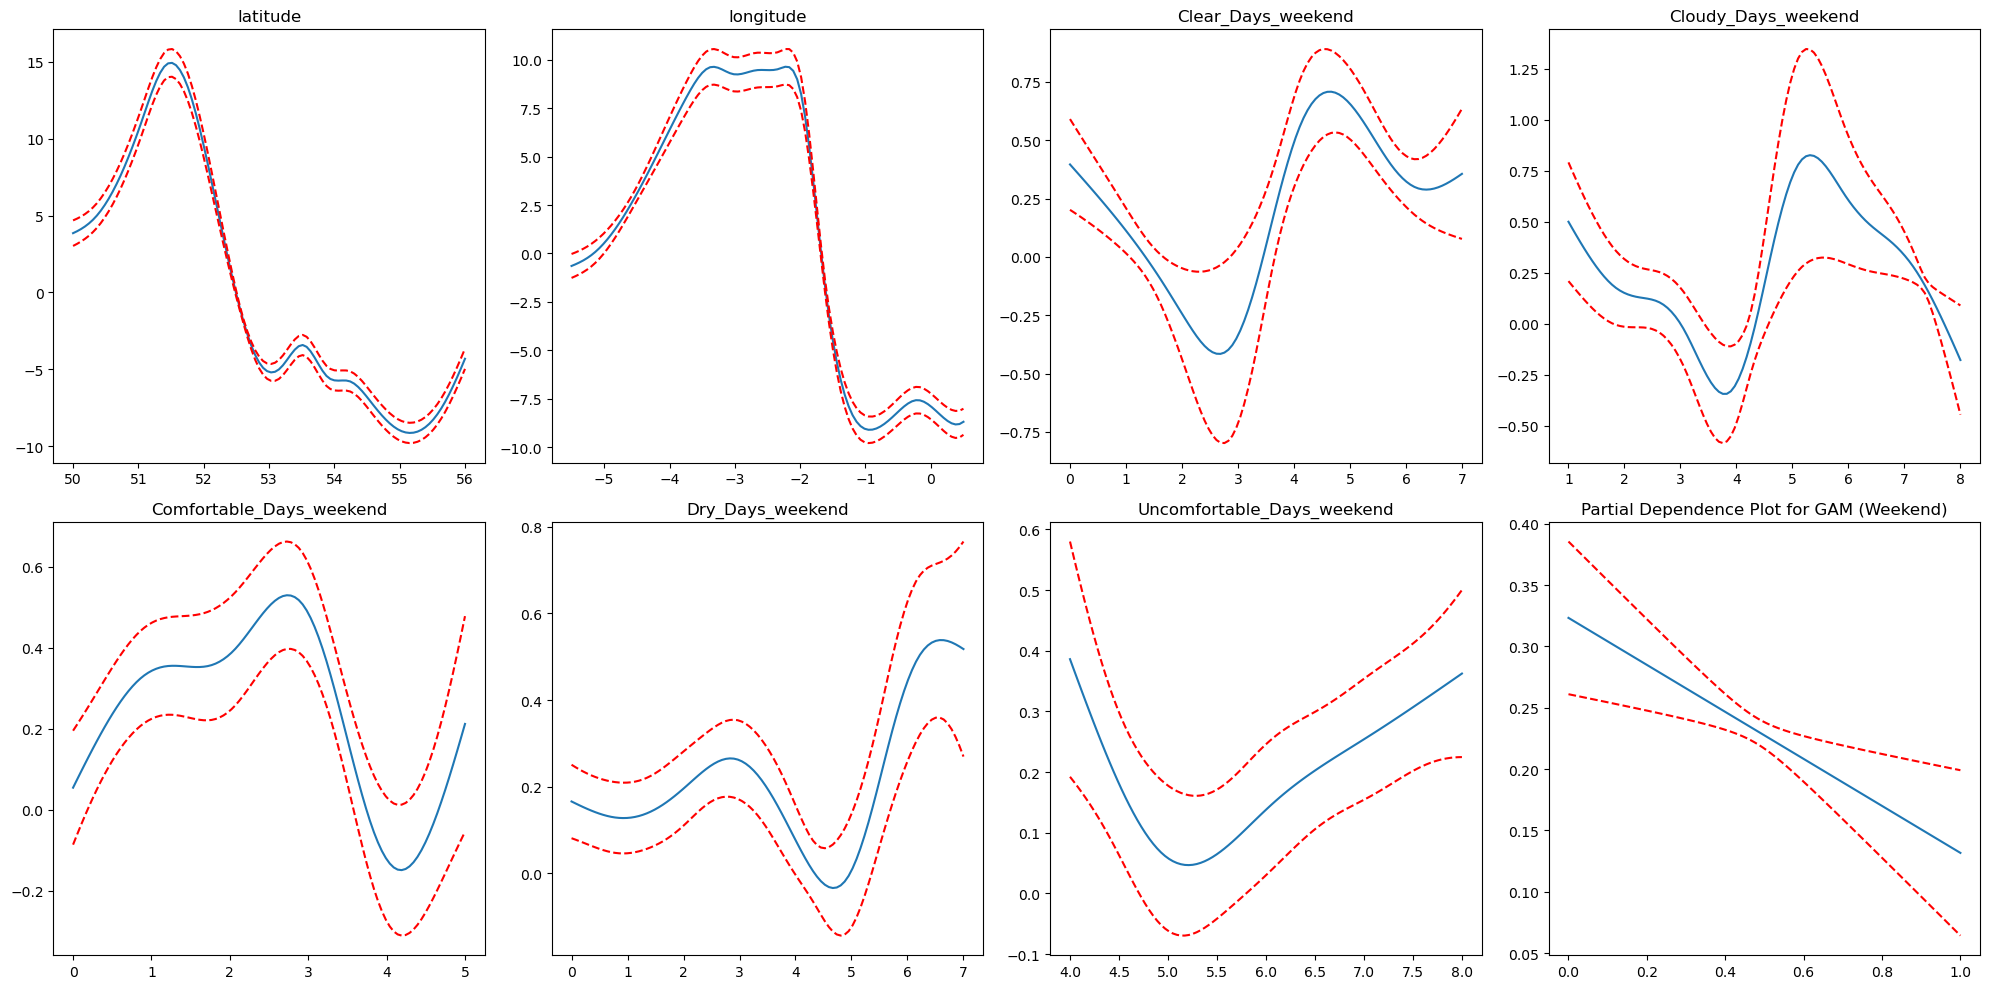

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


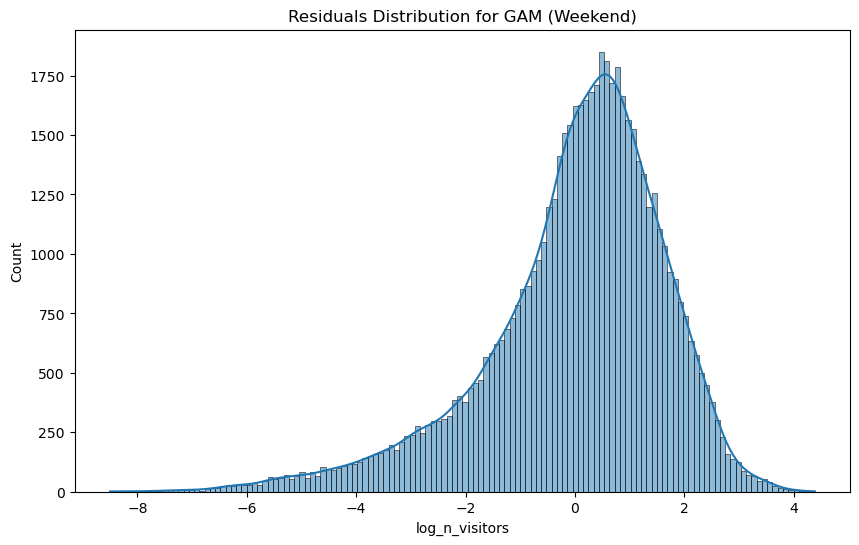

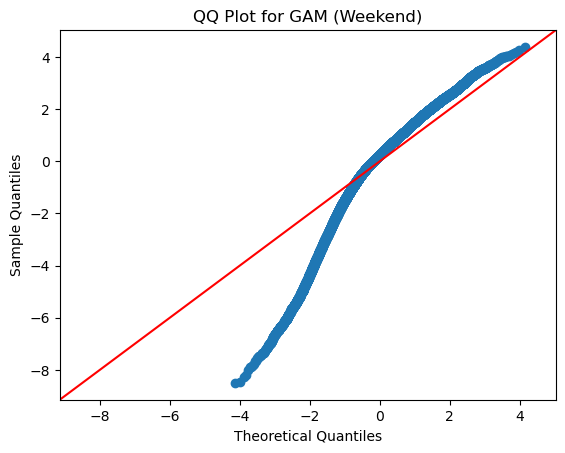

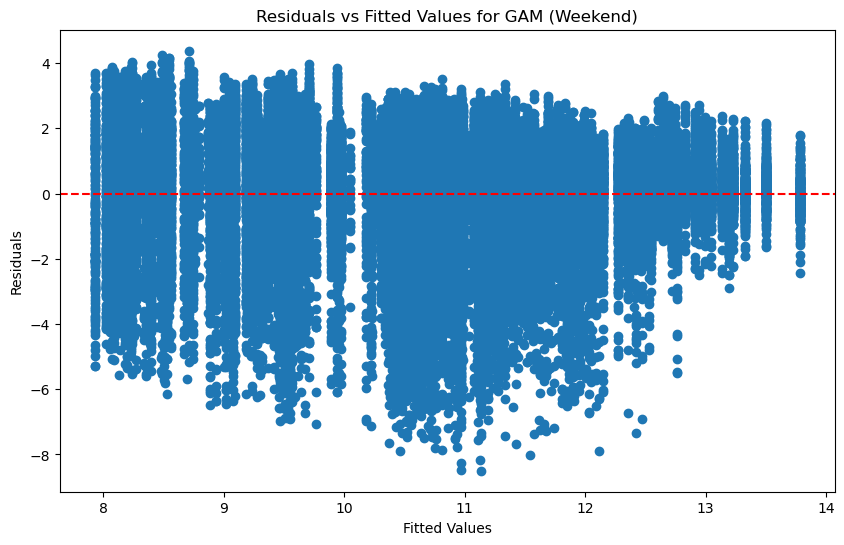

In [112]:
from pygam import LinearGAM, s, f
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a GAM model with smoothing splines for each continuous predictor
X_gam = ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']]
y_gam = ruralurban_weekend['log_n_visitors']

# Include smoothing for all predictors
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_gam, y_gam)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gam = gam.predict(X_gam)
r2 = r2_score(y_gam, y_pred_gam)
mae = mean_absolute_error(y_gam, y_pred_gam)
mse = mean_squared_error(y_gam, y_pred_gam)
rmse = np.sqrt(mse)

print(f"GAM R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the partial dependence of each feature
num_terms = X_gam.shape[1]  # Number of terms in the model
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the grid size based on the number of terms
titles = ['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']
axs = axs.flatten()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
plt.tight_layout()
plt.title('Partial Dependence Plot for GAM (Weekend)')
plt.show()

# Residuals plot for GAM
residuals_gam = y_gam - y_pred_gam
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gam, kde=True)
plt.title('Residuals Distribution for GAM (Weekend)')
plt.show()

# Q-Q plot for normality check in GAM
sm.qqplot(residuals_gam, line='45')
plt.title('QQ Plot for GAM (Weekend)')
plt.show()

# Plot residuals vs fitted values for GAM
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gam, residuals_gam)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for GAM (Weekend)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Random Forest R-squared: 0.36887030924324904
Mean Absolute Error (MAE): 1.2317283008982478
Mean Squared Error (MSE): 2.669422407189953
Root Mean Squared Error (RMSE): 1.6338367137477212


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


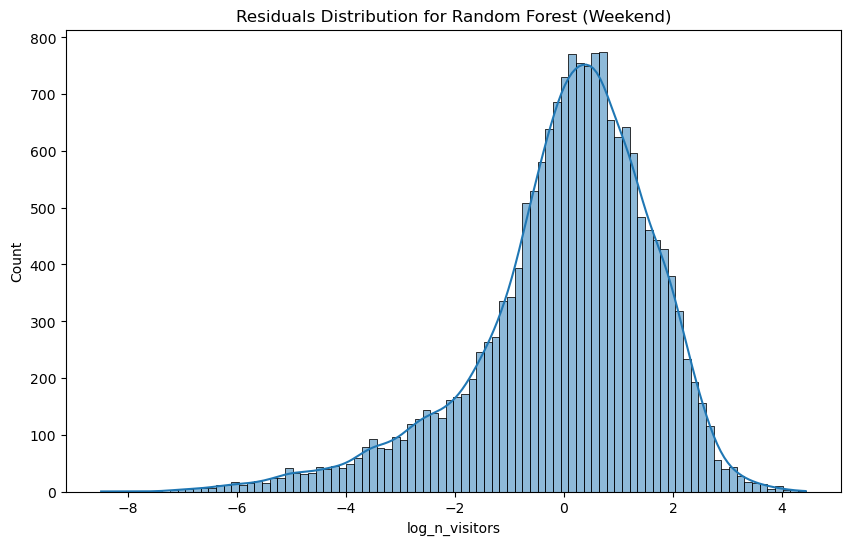

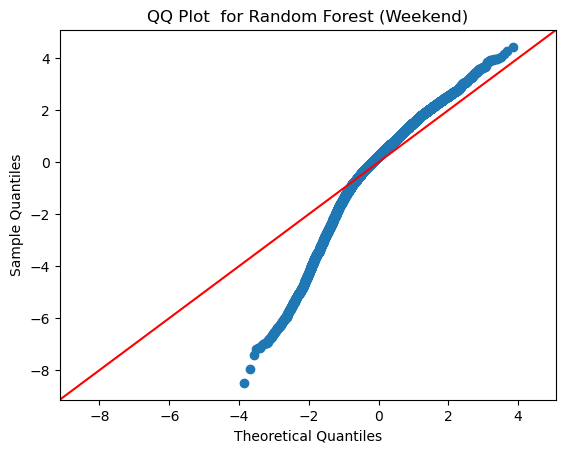

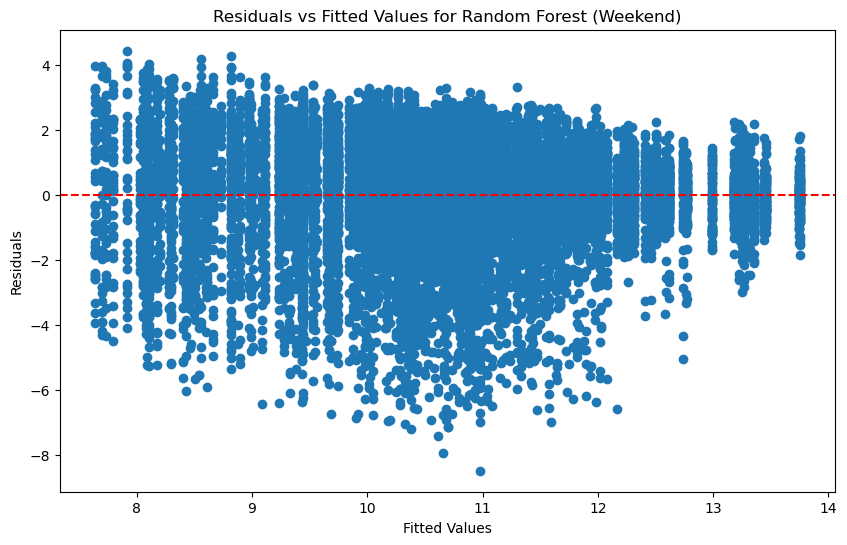

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Prepare data
X_rf = ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']]
y_rf = ruralurban_weekend['log_n_visitors']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_rf = rf.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print(f"Random Forest R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True)
plt.title('Residuals Distribution for Random Forest (Weekend)')
plt.show()

# Q-Q plot for normality check in Random Forest
sm.qqplot(residuals_rf, line='45')
plt.title('QQ Plot  for Random Forest (Weekend)')
plt.show()

# Plot residuals vs fitted values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Random Forest (Weekend)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Gradient Boosting R-squared: 0.3659692793791548
Mean Absolute Error (MAE): 1.2352172756328852
Mean Squared Error (MSE): 2.6816925859449006
Root Mean Squared Error (RMSE): 1.6375874284889038


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


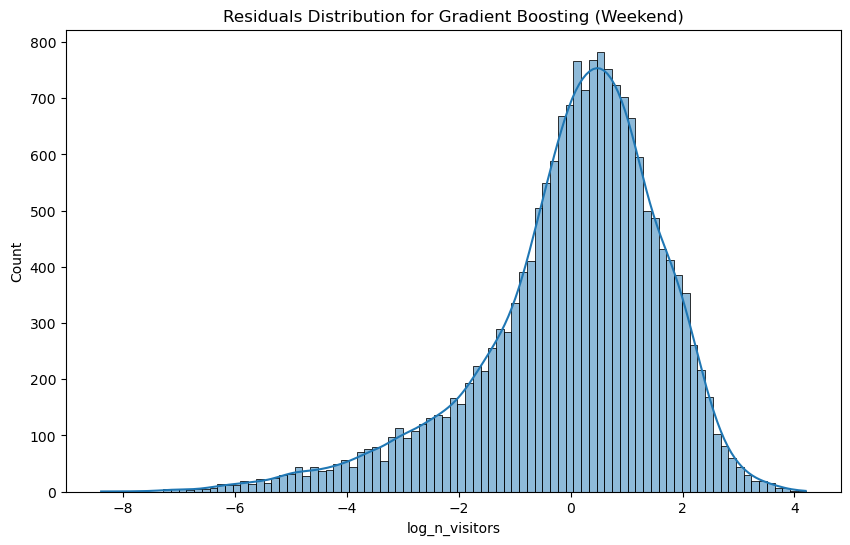

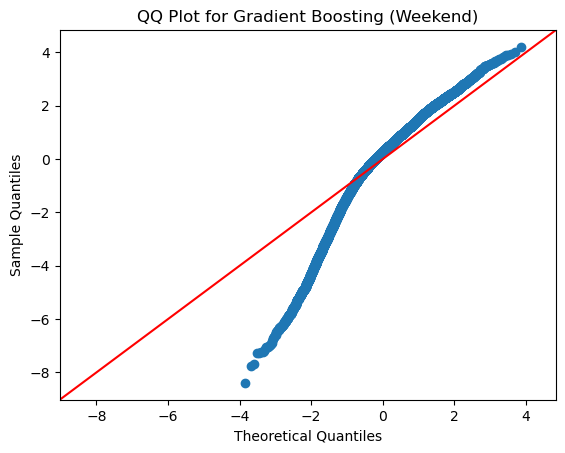

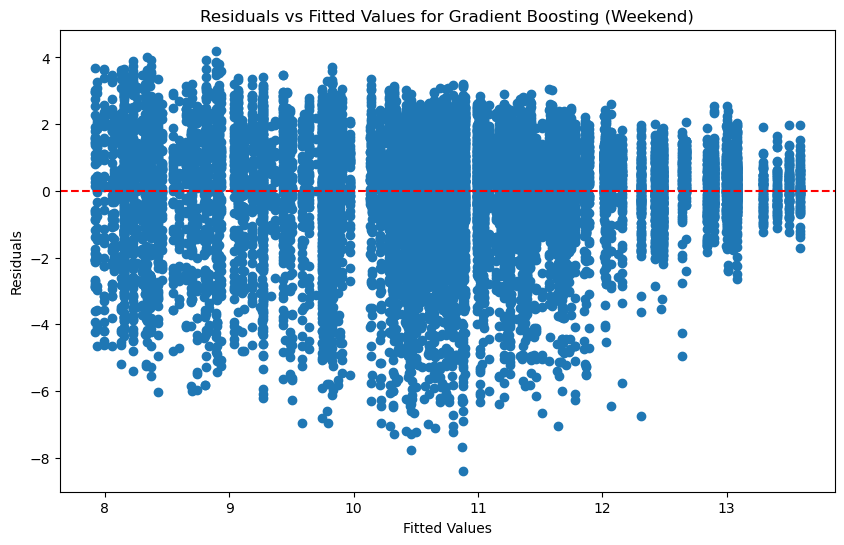

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Fit a Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Predict and calculate R-squared, MAE, MSE, RMSE
y_pred_gb = gb.predict(X_test)
r2 = r2_score(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
mse = mean_squared_error(y_test, y_pred_gb)
rmse = np.sqrt(mse)

print(f"Gradient Boosting R-squared: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Residuals plot for Gradient Boosting
residuals_gb = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gb, kde=True)
plt.title('Residuals Distribution for Gradient Boosting (Weekend)')
plt.show()

# Q-Q plot for normality check in Gradient Boosting
sm.qqplot(residuals_gb, line='45')
plt.title('QQ Plot for Gradient Boosting (Weekend)')
plt.show()

# Plot residuals vs fitted values for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gb, residuals_gb)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values for Gradient Boosting (Weekend)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


## 5.9 Confidence Intervals

### 5.9.1 Confidence Interval for GAM

In [63]:
from pygam import LinearGAM, s, f
import numpy as np

# Fit a GAM model with smoothing splines for each continuous predictor
X_gam = ruralurban_weekday[['latitude', 'longitude', 'Clear_Days_weekday',
       'Cloudy_Days_weekday', 'Comfortable_Days_weekday', 'Dry_Days_weekday',
       'Uncomfortable_Days_weekday', 'Wet_Days_weekday']]
y_gam = ruralurban_weekday['log_n_visitors']

# Fit the model with smoothing terms for each feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_gam, y_gam)

# Use the summary method to get p-values and confidence intervals
gam.summary()

# Get the confidence intervals for all terms in the model
confidence_intervals = gam.confidence_intervals(X_gam)

# Print the confidence intervals for each term
for i, term in enumerate(X_gam.columns):
    print(f"Confidence Intervals for term {i} ({term}):")
    print(f"Lower bound: {confidence_intervals[i][0]}, Upper bound: {confidence_intervals[i][1]}")




LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     72.9855
Link Function:                     IdentityLink Log Likelihood:                               -122796.2932
Number of Samples:                        59254 AIC:                                           245740.5572
                                                AICc:                                          245740.7447
                                                GCV:                                                2.6247
                                                Scale:                                              2.6189
                                                Pseudo R-Squared:                                   0.3744
Feature Function                  Lam

/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_91898/1341702129.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Confidence Intervals for term 0 (latitude):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 1 (longitude):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 2 (Clear_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 3 (Cloudy_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 4 (Comfortable_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 5 (Dry_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 6 (Uncomfortable_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786
Confidence Intervals for term 7 (Wet_Days_weekday):
Lower bound: 12.605090061757279, Upper bound: 13.070915211017786


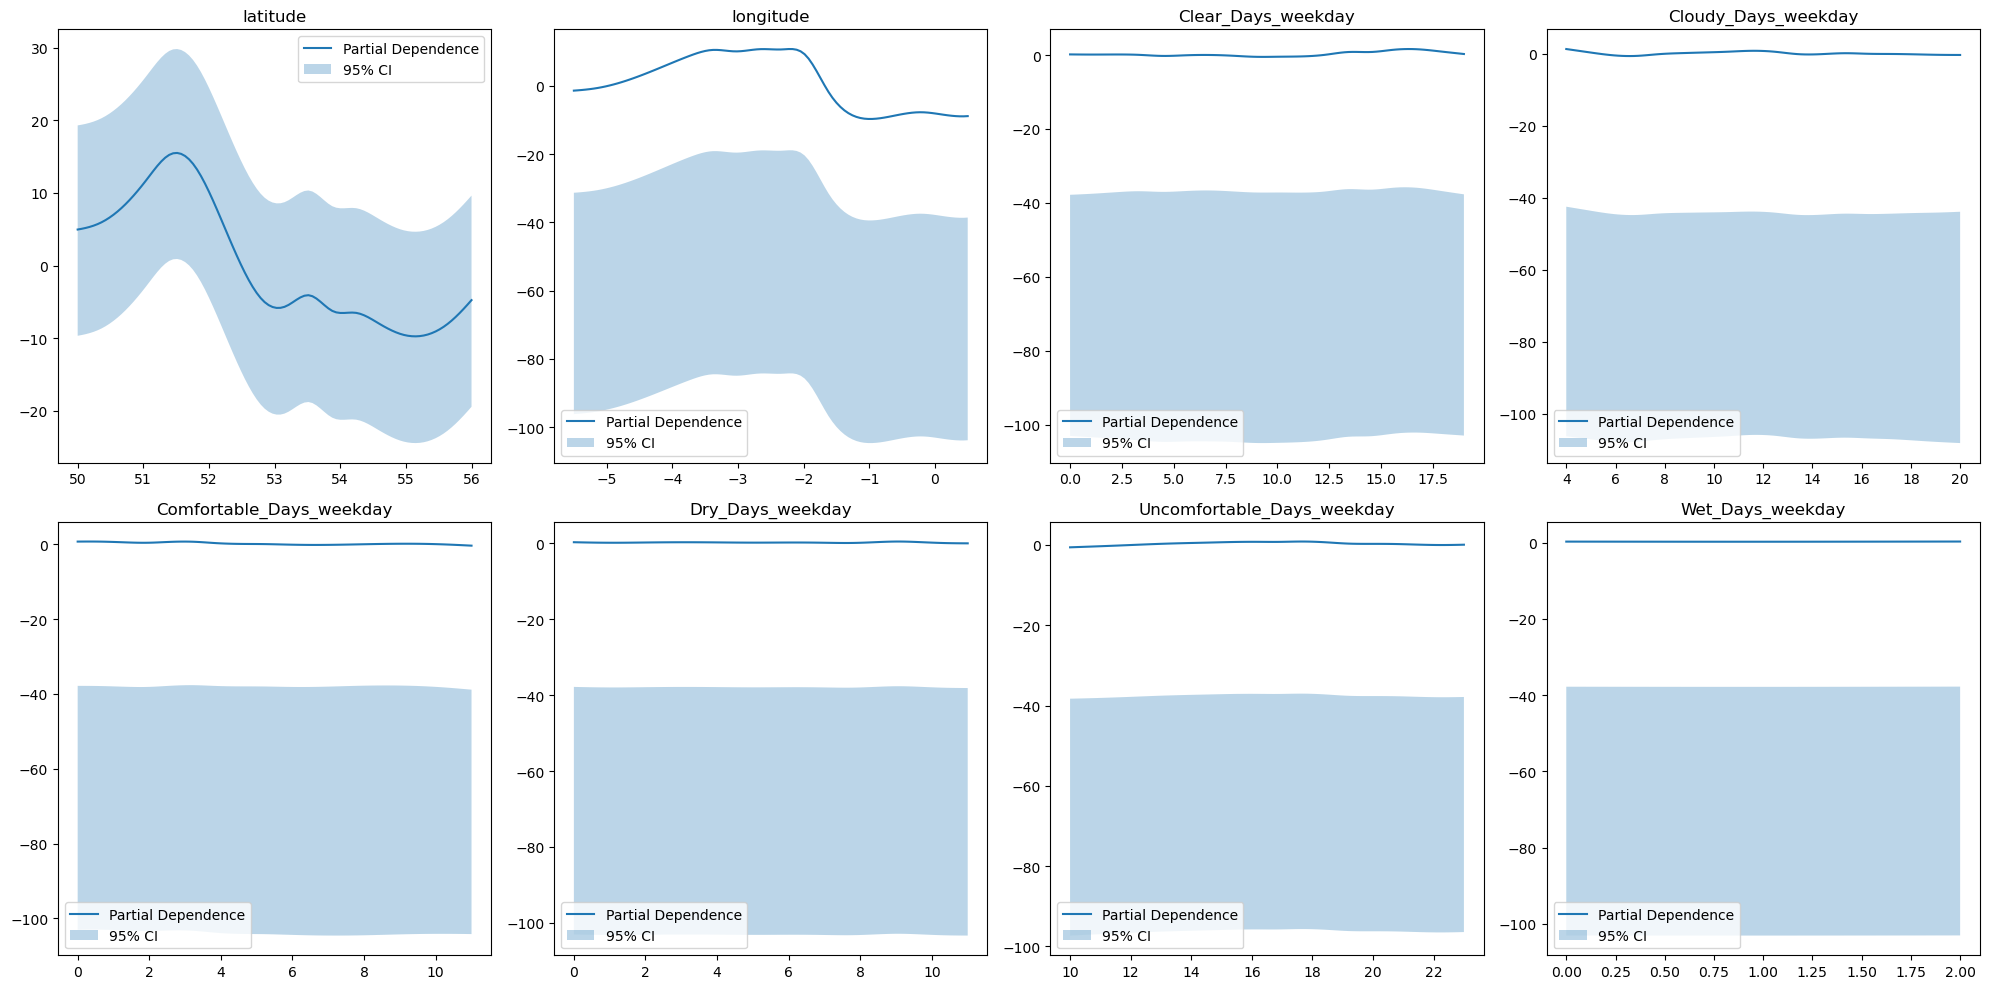

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Number of features
num_terms = X_gam.shape[1]

# Plot partial dependence with confidence intervals for each feature
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust based on the number of features
axs = axs.flatten()

titles = X_gam.columns  # The feature names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    partial_dep = gam.partial_dependence(term=i, X=XX)
    confidence_intervals = gam.confidence_intervals(X=XX)
    
    # Plot partial dependence and confidence intervals
    ax.plot(XX[:, i], partial_dep, label='Partial Dependence')
    ax.fill_between(XX[:, i], confidence_intervals[:, 0], confidence_intervals[:, 1], alpha=0.3, label='95% CI')
    
    ax.set_title(titles[i])
    ax.legend()

plt.tight_layout()
plt.show()


In [60]:
from pygam import LinearGAM, s, f
import numpy as np

# Fit a GAM model with smoothing splines for each continuous predictor
X_gam = ruralurban_weekend[['latitude', 'longitude', 'Clear_Days_weekend',
       'Cloudy_Days_weekend', 'Comfortable_Days_weekend', 'Dry_Days_weekend',
       'Uncomfortable_Days_weekend', 'Wet_Days_weekend']]
y_gam = ruralurban_weekend['log_n_visitors']

# Fit the model with smoothing terms for each feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_gam, y_gam)

# Use the summary method to get p-values and confidence intervals
gam.summary()

# Get the confidence intervals for all terms in the model
confidence_intervals = gam.confidence_intervals(X_gam)

# Print the confidence intervals for each term
for i, term in enumerate(X_gam.columns):
    print(f"Confidence Intervals for term {i} ({term}):")
    print(f"Lower bound: {confidence_intervals[i][0]}, Upper bound: {confidence_intervals[i][1]}")


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.2754
Link Function:                     IdentityLink Log Likelihood:                                 -124999.88
Number of Samples:                        59226 AIC:                                           250098.3107
                                                AICc:                                          250098.3944
                                                GCV:                                                2.7485
                                                Scale:                                              2.7445
                                                Pseudo R-Squared:                                   0.3558
Feature Function                  Lam

/var/folders/y6/rbs796bx78jcl293lzj57pnm0000gn/T/ipykernel_91898/1537987963.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Confidence Intervals for term 0 (latitude):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 1 (longitude):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 2 (Clear_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 3 (Cloudy_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 4 (Comfortable_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 5 (Dry_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 6 (Uncomfortable_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163
Confidence Intervals for term 7 (Wet_Days_weekend):
Lower bound: 11.874287295384418, Upper bound: 12.113481391524163


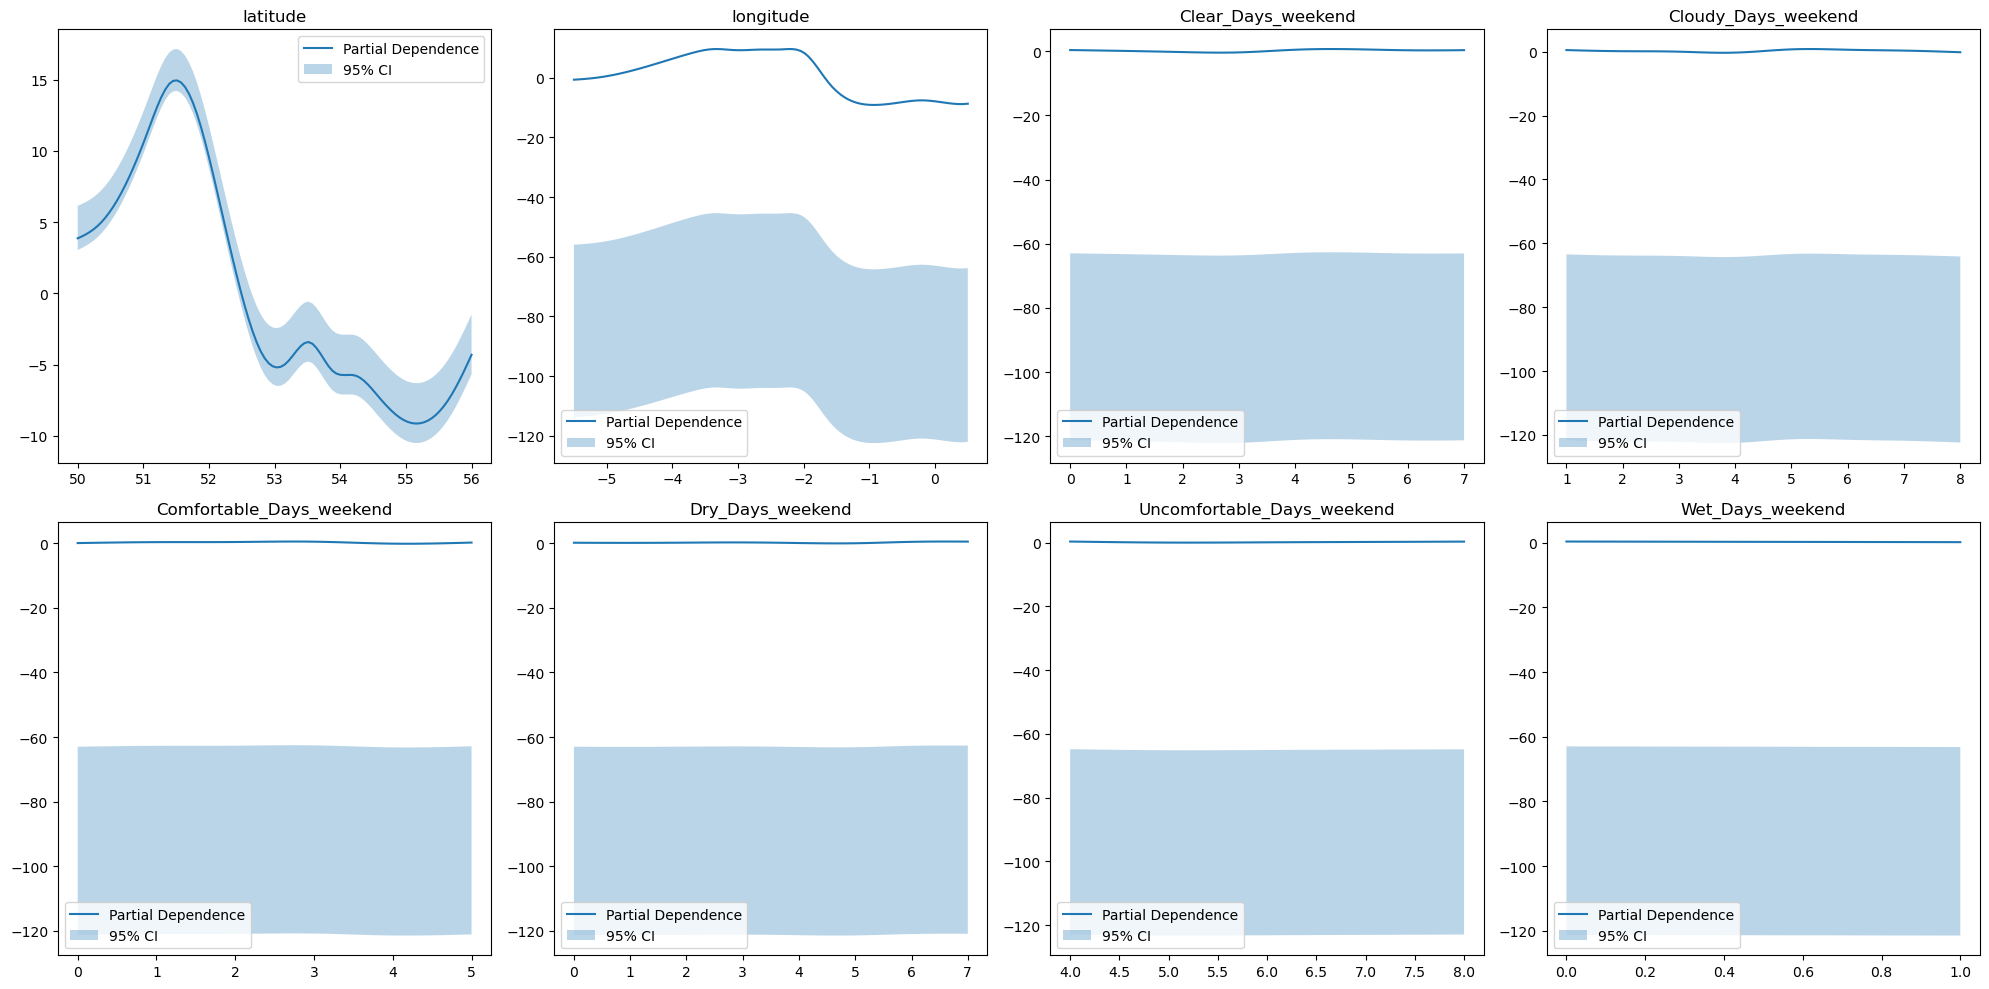

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Number of features
num_terms = X_gam.shape[1]

# Plot partial dependence with confidence intervals for each feature
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust based on the number of features
axs = axs.flatten()

titles = X_gam.columns  # The feature names
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    partial_dep = gam.partial_dependence(term=i, X=XX)
    confidence_intervals = gam.confidence_intervals(X=XX)
    
    # Plot partial dependence and confidence intervals
    ax.plot(XX[:, i], partial_dep, label='Partial Dependence')
    ax.fill_between(XX[:, i], confidence_intervals[:, 0], confidence_intervals[:, 1], alpha=0.3, label='95% CI')
    
    ax.set_title(titles[i])
    ax.legend()

plt.tight_layout()
plt.show()


## 5.9.2 Bootstrapping and Non-OLS Models

In [65]:
#Weekday

import numpy as np
from pygam import LinearGAM, s
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstrap_samples = 1000

# Store bootstrap results
bootstrap_results = []

# Run the bootstrap process
for i in range(n_bootstrap_samples):
    # Resample the data
    X_resampled, y_resampled = resample(X_gam, y_gam)
    
    # Fit the GAM model on resampled data
    gam_bootstrap = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_resampled, y_resampled)
    
    # Extract the partial dependence for each term at this bootstrap iteration
    term_effects = []
    for j in range(X_gam.shape[1]):
        XX = gam_bootstrap.generate_X_grid(term=j)
        partial_dep = gam_bootstrap.partial_dependence(term=j, X=XX)
        term_effects.append(np.mean(partial_dep))  # Store the average effect of each term

    # Store the term effects
    bootstrap_results.append(term_effects)

# Convert results to a NumPy array for easier manipulation
bootstrap_results = np.array(bootstrap_results)

# Calculate the 95% confidence intervals for each predictor
lower_percentile = np.percentile(bootstrap_results, 2.5, axis=0)
upper_percentile = np.percentile(bootstrap_results, 97.5, axis=0)

# Check if the confidence intervals exclude zero for weather-related predictors
for i, predictor in enumerate(X_gam.columns):
    print(f"95% Confidence Interval for {predictor}: [{lower_percentile[i]}, {upper_percentile[i]}]")
    
    # Check if zero is in the confidence interval
    if lower_percentile[i] > 0 or upper_percentile[i] < 0:
        print(f"The effect of {predictor} is statistically significant and we can reject the null hypothesis.")
    else:
        print(f"The effect of {predictor} is not statistically significant, and we cannot reject the null hypothesis.")


95% Confidence Interval for latitude: [0.011713261350271415, 0.12203314632156119]
The effect of latitude is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for longitude: [0.9750582951123681, 1.1487734529718894]
The effect of longitude is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Clear_Days_weekday: [-0.1330905208746421, 0.6617171428780835]
The effect of Clear_Days_weekday is not statistically significant, and we cannot reject the null hypothesis.
95% Confidence Interval for Cloudy_Days_weekday: [-0.1851275008611106, 0.43948618603643974]
The effect of Cloudy_Days_weekday is not statistically significant, and we cannot reject the null hypothesis.
95% Confidence Interval for Comfortable_Days_weekday: [0.042597034800281895, 0.4479635782778204]
The effect of Comfortable_Days_weekday is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Dry_Days_weekday: [0.1

In [62]:
#Weekend

import numpy as np
from pygam import LinearGAM, s
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstrap_samples = 1000

# Store bootstrap results
bootstrap_results = []

# Run the bootstrap process
for i in range(n_bootstrap_samples):
    # Resample the data
    X_resampled, y_resampled = resample(X_gam, y_gam)
    
    # Fit the GAM model on resampled data
    gam_bootstrap = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_resampled, y_resampled)
    
    # Extract the partial dependence for each term at this bootstrap iteration
    term_effects = []
    for j in range(X_gam.shape[1]):
        XX = gam_bootstrap.generate_X_grid(term=j)
        partial_dep = gam_bootstrap.partial_dependence(term=j, X=XX)
        term_effects.append(np.mean(partial_dep))  # Store the average effect of each term

    # Store the term effects
    bootstrap_results.append(term_effects)

# Convert results to a NumPy array for easier manipulation
bootstrap_results = np.array(bootstrap_results)

# Calculate the 95% confidence intervals for each predictor
lower_percentile = np.percentile(bootstrap_results, 2.5, axis=0)
upper_percentile = np.percentile(bootstrap_results, 97.5, axis=0)

# Check if the confidence intervals exclude zero for weather-related predictors
for i, predictor in enumerate(X_gam.columns):
    print(f"95% Confidence Interval for {predictor}: [{lower_percentile[i]}, {upper_percentile[i]}]")
    
    # Check if zero is in the confidence interval
    if lower_percentile[i] > 0 or upper_percentile[i] < 0:
        print(f"The effect of {predictor} is statistically significant and we can reject the null hypothesis.")
    else:
        print(f"The effect of {predictor} is not statistically significant, and we cannot reject the null hypothesis.")


95% Confidence Interval for latitude: [0.08683859192227429, 0.17483809770938827]
The effect of latitude is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for longitude: [0.8555709062993018, 1.034105855253255]
The effect of longitude is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Clear_Days_weekend: [0.15200494704812828, 0.23556527856397264]
The effect of Clear_Days_weekend is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Cloudy_Days_weekend: [0.19478919730016467, 0.29031872215678334]
The effect of Cloudy_Days_weekend is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Comfortable_Days_weekend: [0.21216823950212899, 0.26397764358893405]
The effect of Comfortable_Days_weekend is statistically significant and we can reject the null hypothesis.
95% Confidence Interval for Dry_Days_weekend: [0.1856511252763349, 

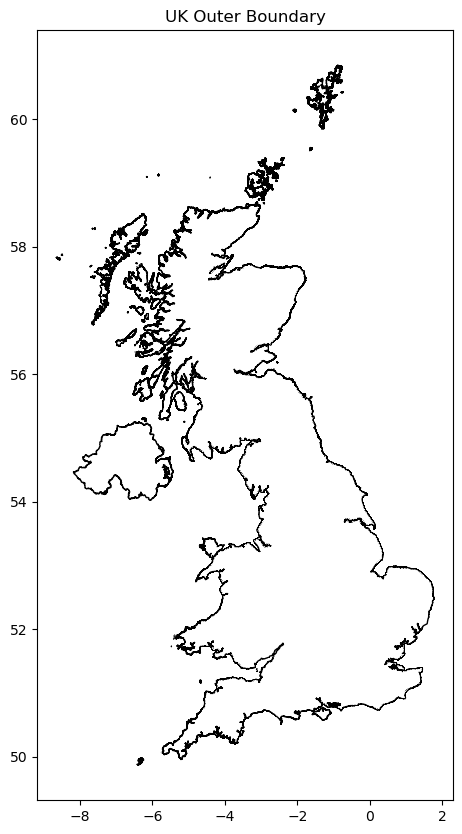

In [118]:
import geopandas as gpd

# Load the shapefile
shapefile_path = 'gadm41_GBR_shp/gadm41_GBR_0.shp'  # Use the correct path
uk_map = gpd.read_file(shapefile_path)

# Dissolve internal boundaries to get only the external boundary using the 'COUNTRY' column
uk_map_dissolved = uk_map.dissolve(by='COUNTRY')

# Now, when you plot, it should only show the outer boundary of the UK
import matplotlib.pyplot as plt

# Example plot to show the dissolved boundary
fig, ax = plt.subplots(figsize=(10, 10))
uk_map_dissolved.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('UK Outer Boundary')
plt.show()

In [128]:
data = Mobility_Data
data

qk_id   time_aggregation  n_visitors   Month corrected_qk_id  \
0  3113113013203      weekend - all        1664  August  03113113013203   
1  3113131000300  weekend - evening         152  August  03113131000300   
2  3113213320202  weekday - evening       56956  August  03113213320202   
3  3113301300300  weekend - workday        4137  August  03113301300300   
4  3113303010023  weekend - evening        7162  August  03113303010023   

   latitude  longitude                   geometry  
0      60.0      -0.75  POINT (-0.85000 60.79000)  
1      60.0      -1.25  POINT (-1.31000 60.19000)  
2      57.5      -6.25  POINT (-6.32000 57.45000)  
3      58.5      -3.50  POINT (-3.42000 58.40000)  
4      58.0      -3.75  POINT (-3.83000 58.04000)

In [129]:
data = data[['Month', 'n_visitors','latitude', 'longitude']]
data.head()

Month  n_visitors  latitude  longitude
0  August        1664      60.0      -0.75
1  August         152      60.0      -1.25
2  August       56956      57.5      -6.25
3  August        4137      58.5      -3.50
4  August        7162      58.0      -3.75

In [134]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors

# Load the UK shapefile and dissolve internal boundaries to get only the external boundary
shapefile_path = 'gadm41_GBR_shp/gadm41_GBR_0.shp'  # Use the correct path
uk_map = gpd.read_file(shapefile_path)
uk_map_dissolved = uk_map.dissolve(by='COUNTRY')

# Load and merge NetCDF data (weather data)
file_2023 = 'ERA5/adaptor.mars.internal-1721856561.1070611-1835-12-e8a32e2e-096c-4f59-a2f2-37a2e926b482(Aug23-Dec23).nc'
file_2024 = 'ERA5/adaptor.mars.internal-1722165117.2444587-9919-18-2447c9b4-5cd6-4fb7-8a73-4b95480e95ae(Jan24-Apr24).nc'

ds_2023 = xr.open_dataset(file_2023)
ds_2024 = xr.open_dataset(file_2024)

# Concatenate the datasets along the time dimension
ds = xr.concat([ds_2023, ds_2024], dim='time')

# Select the total precipitation variable and aggregate it to daily totals
tp = ds['tp'].resample(time='1D').sum()

# Define the logic to categorize the dates into months
def categorize_dates(date):
    if date >= np.datetime64('2023-08-01') and date <= np.datetime64('2023-08-31'):
        return 'August 2023'
    elif date >= np.datetime64('2023-09-01') and date <= np.datetime64('2023-09-30'):
        return 'September 2023'
    elif date >= np.datetime64('2023-10-23') and date <= np.datetime64('2023-11-19'):
        return 'October 2023'
    elif date >= np.datetime64('2023-11-20') and date <= np.datetime64('2023-12-17'):
        return 'November 2023'
    elif date >= np.datetime64('2023-12-18') and date <= np.datetime64('2024-01-14'):
        return 'December 2023'
    elif date >= np.datetime64('2024-01-15') and date <= np.datetime64('2024-02-11'):
        return 'January 2024'
    elif date >= np.datetime64('2024-02-12') and date <= np.datetime64('2024-03-10'):
        return 'February 2024'
    elif date >= np.datetime64('2024-03-11') and date <= np.datetime64('2024-04-07'):
        return 'March 2024'
    else:
        return 'Others'

# Apply the categorization function to the time dimension
tp_daily = tp.assign_coords(month=('time', [categorize_dates(d) for d in tp['time'].values]))

# Convert the dataset to a DataFrame for easier handling
tp_daily_df = tp_daily.to_dataframe().reset_index()

# Filter out the 'Others' category
tp_daily_df = tp_daily_df[tp_daily_df['month'] != 'Others']

# Define a function to categorize each day as 'wet', 'dry', or 'neutral' based on precipitation thresholds
def categorize_day(precipitation):
    if precipitation < 0.0001:
        return 'dry'
    elif precipitation > 0.025:
        return 'wet'
    else:
        return 'neutral'

# Apply the categorization to the precipitation data
tp_daily_df['day_type'] = tp_daily_df['tp'].apply(categorize_day)

# Group by latitude, longitude, and month to count the number of dry and wet days
grouped_df = tp_daily_df.groupby(['latitude', 'longitude', 'month']).apply(
    lambda x: pd.Series({
        'dry_days': (x['day_type'] == 'dry').sum(),
        'wet_days': (x['day_type'] == 'wet').sum()
    })
).reset_index()

# Ensure the months are ordered correctly
month_order = ['August 2023', 'September 2023', 'October 2023', 'November 2023', 
               'December 2023', 'January 2024', 'February 2024', 'March 2024']

# Load the actual visitors data
df_visitors = pd.DataFrame(data)

# Iterate through each month and plot the three required graphs per row
for month in month_order:
    # Prepare data for Dry and Wet Days
    df_month_weather = grouped_df[grouped_df['month'] == month]
    unique_lats = np.sort(df_month_weather['latitude'].unique())
    unique_lons = np.sort(df_month_weather['longitude'].unique())

    dry_days_grid = df_month_weather.pivot_table(index='latitude', columns='longitude', values='dry_days').reindex(index=unique_lats, columns=unique_lons).values
    wet_days_grid = df_month_weather.pivot_table(index='latitude', columns='longitude', values='wet_days').reindex(index=unique_lats, columns=unique_lons).values

    # Prepare data for Visitors
    df_month_visitors = df_visitors[df_visitors['Month'] == month.split()[0]]
    visitors_grid = df_month_visitors.pivot_table(index='latitude', columns='longitude', values='n_visitors').reindex(index=unique_lats, columns=unique_lons).values

    # Calculate the percentiles dynamically for visitors
    min_visitors = df_month_visitors['n_visitors'].min()
    p25_visitors = df_month_visitors['n_visitors'].quantile(0.25)
    p50_visitors = df_month_visitors['n_visitors'].quantile(0.50)
    p75_visitors = df_month_visitors['n_visitors'].quantile(0.75)
    max_visitors = df_month_visitors['n_visitors'].max()

    # Defining levels based on the monthly percentiles
    levels = [min_visitors, p25_visitors, p50_visitors, p75_visitors, 
              (p75_visitors + max_visitors) / 2, max_visitors]  # Additional mid-max level for smoother gradient

    # Create the figure with 3 subplots for each month
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150)  # Three plots side by side

    # Plot Dry Days
    ax = axs[0]
    uk_map_dissolved.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Country boundary
    contour_dry = ax.pcolormesh(unique_lons, unique_lats, dry_days_grid, cmap='Blues', shading='auto', vmin=0, vmax=np.nanmax(dry_days_grid))
    cbar_dry = fig.colorbar(contour_dry, ax=ax, label='Number of Dry Days')
    cbar_dry.set_ticks(np.arange(0, np.nanmax(dry_days_grid) + 1, 1))  # Distinct integer ticks
    ax.set_title(f'{month} - Dry Days')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot Visitors
    ax = axs[1]
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", ['green', 'yellow', 'orange', 'red'], N=8)
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    uk_map_dissolved.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Country boundary
    contour_visitors = ax.contourf(unique_lons, unique_lats, visitors_grid, levels=levels, cmap=cmap, norm=norm)
    cbar_visitors = fig.colorbar(contour_visitors, ax=ax, ticks=levels, extend='max', format='%d')  # Format labels as integers
    cbar_visitors.set_label('Number of Visitors')
    ax.set_title(f'{month} - Number of Visitors')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot Wet Days
    ax = axs[2]
    uk_map_dissolved.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Country boundary
    contour_wet = ax.pcolormesh(unique_lons, unique_lats, wet_days_grid, cmap='Purples', shading='auto', vmin=0, vmax=np.nanmax(wet_days_grid))
    cbar_wet = fig.colorbar(contour_wet, ax=ax, label='Number of Wet Days')
    cbar_wet.set_ticks(np.arange(0, np.nanmax(wet_days_grid) + 1, 1))  # Distinct integer ticks
    ax.set_title(f'{month} - Wet Days')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plots
#    plt.tight_layout()
 #   plt.show()

     # Save the plot instead of displaying it
    plt.tight_layout()
    plt.savefig(f'{month.replace(" ", "_")}_plots.png', dpi=300)  # Save the plot as a PNG file with high resolution
    plt.close(fig)  # Close the figure to free up memory
